In [1]:
import os
import h5py
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import skimage
import imageio

import tifffile as tf
import cv2

import pyclesperanto_prototype as cle
from skimage.exposure import match_histograms, rescale_intensity
from skimage import exposure, util, filters, restoration

import pandas as pd

from cellpose import models,core

C:\Users\mwang698\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import random
import numpy as np
import pandas as pd
from matplotlib.pyplot import scatter
from matplotlib.pyplot import Line2D
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.rcParams['figure.dpi'] = 600
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import textwrap

In [3]:
def contrast_str(img, n_min=10, n_max=100):
    p2, p98 = np.percentile(img, (n_min, n_max))
    img_rescale = rescale_intensity(img, in_range=(p2, p98))
    img_rescale = util.img_as_ubyte(img_rescale)
    return img_rescale

In [5]:
def extract_numeric(filename):
    return int(filename.split('_')[-1].split('.')[0])

In [6]:
if core.use_gpu()==False: 
    use_GPU=False
else:
    print('GPU applied')
    use_GPU=True

GPU applied


In [ ]:
# cytotoxic T cell
imgs_processed_all_cytotoxic = []

path1 = r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\CytoCoc\hdf5\processed\CD8T_pos1_5.hdf5"
path2 = r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\CytoCoc\hdf5\processed\CD8T_pos2_16.hdf5"

for path in [path1, path2]:
    with h5py.File(path, "r") as f:
        markers_cytotoxic = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]
    imgs_processed = skimage.exposure.adjust_log(imgs) 
    imgs_processed  = np.clip(imgs_processed , a_min=0, a_max=imgs_processed.max())
    imgs_processed = contrast_str(imgs_processed, n_min=0, n_max=100)
    imgs_processed_all_cytotoxic.append(imgs_processed)

In [ ]:
# naive T cell
imgs_processed_all_naive = []

path1 = r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\NaiveCoC\hdf5\processed\CD8T_pos1_10.hdf5"
path2 = r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\NaiveCoC\hdf5\processed\CD8T_pos2_10.hdf5"

for path in [path1, path2]:
    with h5py.File(path, "r") as f:
        markers_naive = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]
    imgs_processed = skimage.exposure.adjust_log(imgs) 
    imgs_processed  = np.clip(imgs_processed , a_min=0, a_max=imgs_processed.max())
    imgs_processed = contrast_str(imgs_processed, n_min=0, n_max=100)
    imgs_processed_all_naive.append(imgs_processed)

In [9]:
Cyto_holder = imgs_processed_all_cytotoxic.copy()
naive_holder = imgs_processed_all_naive.copy()

In [10]:
from joblib import Parallel, delayed
from skimage import measure
from functools import reduce

### Helper function
def read_intensity_per_cell(img, mask):
    props = skimage.measure.regionprops_table(
        mask, img, properties=["label", "mean_intensity", "area"]
    )
    df_prop = pd.DataFrame(props)
    df_prop["mean_intensity"] = df_prop["mean_intensity"]
    df_prop.drop("area", axis=1, inplace=True)

    df_prop["mean_intensity"] = np.arcsinh(df_prop[["mean_intensity"]])

    return df_prop

def create_cell_mean_expression(mask, cell2int, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    for cell, int in cell2int.items():
        img = np.where(mask == cell, int, img)
    return img

In [11]:
from skimage.io import imread
naive_cyto_mask_pos1 = imread("Y:\coskun-undergrads\Mingshuang\Thomas\CoCulture\imgs\masks\CD8T_pos1_10_cp_masks.png")
naive_cyto_mask_pos2 = imread("Y:\coskun-undergrads\Mingshuang\Thomas\CoCulture\imgs\masks\CD8T_pos2_10_cp_masks.png")

cytotoxic_cyto_mask_pos1 = tf.imread(r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\CytoCoc\masks\pos1_5.tif")
cytotoxic_cyto_mask_pos2 = tf.imread(r"Y:\coskun-lab\Thomas\20_MouseCocultureMatrigel\data\CytoCoc\masks\pos2_16.tif")

C:\Users\mwang698\AppData\Local\anaconda3\Lib\site-packages\imageio\plugins\pillow.py:320: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


In [12]:
# Cytotoxic

# Extract mean intensity per mask
cyto_masks_cytotoxic = [cytotoxic_cyto_mask_pos1, cytotoxic_cyto_mask_pos2]
# df_appended_list_cytotoxic = pd.DataFrame()
df_appended_list_cytotoxic_all = []
for i, img_processed in enumerate(imgs_processed_all_cytotoxic):
    cyto_mask = cyto_masks_cytotoxic[i]
    df_appended_list = []
    for i, img in enumerate(img_processed):
        if markers_cytotoxic[i] == 'DNA' and i != 0:
            continue 
        df_prop = read_intensity_per_cell(img, cyto_mask)
        df_prop.columns = ["Cell_label", markers_cytotoxic[i]]
        df_appended_list.append(df_prop)
    df_appended_list_cytotoxic_all.append(df_appended_list)


In [13]:
# Naive

# Extract mean intensity per mask
cyto_masks_naive = [naive_cyto_mask_pos1, naive_cyto_mask_pos2]
df_appended_list_naive_all = []
for i, img_processed in enumerate(imgs_processed_all_naive):
    cyto_mask = cyto_masks_naive[i]
    df_appended_list = []
    for i, img in enumerate(img_processed):
        if markers_naive[i] == 'DNA' and i != 0:
            continue 
        df_prop = read_intensity_per_cell(img, cyto_mask)
        df_prop.columns = ["Cell_label", markers_naive[i]]
        df_appended_list.append(df_prop)
    df_appended_list_naive_all.append(df_appended_list)


In [14]:
# cytotoxic
df_cell_intensity_pos1_cyto = reduce(
    lambda left, right: pd.merge(left, right, on=["Cell_label"]),
    df_appended_list_cytotoxic_all[0],
)

df_cell_intensity_pos2_cyto = reduce(
    lambda left, right: pd.merge(left, right, on=["Cell_label"]),
    df_appended_list_cytotoxic_all[1],
)

In [15]:
# naive
df_cell_intensity_pos1_naive = reduce(
    lambda left, right: pd.merge(left, right, on=["Cell_label"]),
    df_appended_list_naive_all[0],
)

df_cell_intensity_pos2_naive = reduce(
    lambda left, right: pd.merge(left, right, on=["Cell_label"]),
    df_appended_list_naive_all[1],
)

In [16]:
# cytotoxic
props = skimage.measure.regionprops_table(
    cytotoxic_cyto_mask_pos1, properties=["label", "centroid"]
)
rows = props["centroid-0"] 
cols = props["centroid-1"] 
centroid_cytotoxic = np.array(list(zip(cols, rows)))
df_cell_intensity_pos1_cyto['Row'] = rows
df_cell_intensity_pos1_cyto['Cols'] = cols
df_cell_intensity_pos1_cyto['FOV'] = 'pos1'
df_prop_cytotoxic = df_cell_intensity_pos1_cyto

props = skimage.measure.regionprops_table(
    cytotoxic_cyto_mask_pos2, properties=["label", "centroid"]
)
rows = props["centroid-0"] 
cols = props["centroid-1"] 
centroid_cytotoxic = np.concatenate([centroid_cytotoxic, np.array(list(zip(cols, rows)))])
df_cell_intensity_pos2_cyto['Row'] = rows
df_cell_intensity_pos2_cyto['Cols'] = cols
df_cell_intensity_pos2_cyto['FOV'] = 'pos2'
# df_prop_cytotoxic = df_prop_cytotoxic.append(df_cell_intensity_pos2_cyto)
df_prop_cytotoxic = pd.concat([df_prop_cytotoxic, df_cell_intensity_pos2_cyto])

In [17]:
df_prop_cytotoxic = df_prop_cytotoxic.drop(['Concavalin A', 'WGA'], axis = 1)

In [18]:
# naive
props = skimage.measure.regionprops_table(
    naive_cyto_mask_pos1, properties=["label", "centroid"]
)
rows = props["centroid-0"] 
cols = props["centroid-1"] 
centroid_naive = np.array(list(zip(cols, rows)))
df_cell_intensity_pos1_naive['Row'] = rows
df_cell_intensity_pos1_naive['Cols'] = cols
df_cell_intensity_pos1_naive['FOV'] = 'pos1'
df_prop_naive = df_cell_intensity_pos1_naive

props = skimage.measure.regionprops_table(
    naive_cyto_mask_pos2, properties=["label", "centroid"]
)
rows = props["centroid-0"] 
cols = props["centroid-1"] 
centroid_naive = np.concatenate([centroid_naive, np.array(list(zip(cols, rows)))])
df_cell_intensity_pos2_naive['Row'] = rows
df_cell_intensity_pos2_naive['Cols'] = cols
df_cell_intensity_pos2_naive['FOV'] = 'pos2'
# df_prop_naive = df_prop_naive.append(df_cell_intensity_pos2_naive)
df_prop_naive = pd.concat([df_prop_naive, df_cell_intensity_pos2_naive])

In [19]:
# import seaborn as sns
# df_subset = df_prop[['CD44','E-cadherin']].copy()
# sns.scatterplot(data=df_subset, x="CD44", y='E-cadherin')

df_DNA_cyto = df_prop_cytotoxic[['DNA']].copy()
df_marker_cyto = df_prop_cytotoxic[['CD44','E-cadherin']].copy()

df_DNA_naive = df_prop_naive[['DNA']].copy()
df_marker_naive = df_prop_naive[['CD44','E-cadherin']].copy()

In [20]:
centroid_cytotoxic = centroid_cytotoxic[df_prop_cytotoxic['DNA'] > 2, :]
df_prop_cytotoxic = df_prop_cytotoxic[df_prop_cytotoxic['DNA'] > 2]

centroid_naive = centroid_naive[df_prop_naive['DNA'] > 2, :]
df_prop_naive = df_prop_naive[df_prop_naive['DNA'] > 2]

In [21]:
# Define cell type
df_prop_cytotoxic['Cell Type'] = 0
df_prop_cytotoxic.loc[df_prop_cytotoxic['E-cadherin'] > 0.1, 'Cell Type'] = 1
df_prop_cytotoxic.loc[df_prop_cytotoxic['E-cadherin'] <= 0.1, 'Cell Type'] = 2

In [22]:
# Define cell type
df_prop_naive['Cell Type'] = 0
df_prop_naive.loc[df_prop_naive['E-cadherin'] > 0.1, 'Cell Type'] = 1
df_prop_naive.loc[df_prop_naive['E-cadherin'] <= 0.1, 'Cell Type'] = 2

In [23]:
df_cytotoxic_value = df_prop_cytotoxic.iloc[:,1:32]
df_cytotoxic_value_norm = (df_cytotoxic_value - df_cytotoxic_value.min()) / (df_cytotoxic_value.max() - df_cytotoxic_value.min())
# print(df_cytotoxic_value_norm)
df_prop_cytotoxic.iloc[:,1:32] = df_cytotoxic_value_norm

In [24]:
df_naive_value = df_prop_naive.iloc[:,1:32]
df_naive_value_norm = (df_naive_value - df_naive_value.min()) / (df_naive_value.max() - df_naive_value.min())
df_prop_naive.iloc[:,1:32] = df_naive_value_norm

In [25]:
markers_cytotoxic = markers_cytotoxic[:41]

In [26]:
df_prop_cytotoxic['Cell_type_name'] = df_prop_cytotoxic['Cell Type'].apply(lambda x: {0:'Other', 1: 'cancer cell interacting with CytoT', 2:'Cytotoxic T cell'}.get(x,x))
df_cytotoxic = df_prop_cytotoxic.loc[:,np.concatenate([markers_cytotoxic, ['Cell_type_name']])].copy()
df_cytotoxic = df_cytotoxic[df_cytotoxic.Cell_type_name != 'Other']

In [27]:
df_prop_naive['Cell_type_name'] = df_prop_naive['Cell Type'].apply(lambda x: {0:'Other', 1: 'cancer cell interacting with NaiveT', 2:'Naive T cell'}.get(x,x))
df_naive = df_prop_naive.loc[:,np.concatenate([markers_naive, ['Cell_type_name']])].copy()
df_naive = df_naive[df_naive.Cell_type_name != 'Other']

In [27]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(24,7)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True, size=2.5)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star',comparisons_correction="bonferroni",loc='inside', verbose=0)
        result = annot.apply_test().annotate()
        print(result)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#         plt.savefig(save_path, bbox_inches = 'tight')
        
def plot3(plotting, figsize=(37,8)):
    c1, c2, c3 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2), (e, c3)) for e in plotting['data'][plotting['x']].unique()]
    pairs = []
    for e in plotting['data'][plotting['x']].unique():
        pairs.append([(e, c1), (e, c2)])
        pairs.append([(e, c1), (e, c3)])
        pairs.append([(e, c2), (e, c3)])

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True, size=2.5)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', comparisons_correction="bonferroni", loc='inside')
#         result = annot.apply_test().annotate()
        _, corrected_results = annot.apply_and_annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

def plot2(plotting, figsize=(24,7)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.violinplot(**plotting, showfliers=False, ax=ax)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [31]:
df_melt_cytotoxic = df_cytotoxic.melt(id_vars=['Cell_type_name'])
df_melt_cytotoxic.columns = ['Cell Type', 'Marker', 'Expression']
df_melt_cytotoxic.head()

Cell Type Marker  Expression
0                    Cytotoxic T cell    DNA    0.629755
1                    Cytotoxic T cell    DNA    0.555044
2  cancer cell interacting with CytoT    DNA    0.457348
3  cancer cell interacting with CytoT    DNA    0.753128
4  cancer cell interacting with CytoT    DNA    0.882889

In [32]:
df_melt_naive = df_naive.melt(id_vars=['Cell_type_name'])
df_melt_naive.columns = ['Cell Type', 'Marker', 'Expression']
df_melt_naive.head()


Cell Type Marker  Expression
0  cancer cell interacting with NaiveT    DNA    0.601785
1  cancer cell interacting with NaiveT    DNA    0.534948
2                         Naive T cell    DNA    0.662756
3                         Naive T cell    DNA    0.510995
4  cancer cell interacting with NaiveT    DNA    0.459844

In [33]:
df_melt_all = pd.concat([df_melt_naive, df_melt_cytotoxic])

In [34]:
df_melt_all_corrected = df_melt_all[(~(df_melt_all['Marker'] == 'WGA'))]
df_melt_all_corrected = df_melt_all_corrected[(~(df_melt_all_corrected['Marker'] == 'Concavalin A'))]

In [51]:
df_melt_all_corrected = df_melt_all_corrected[~((df_melt_all_corrected['Cell Type'] == 'cancer cell interacting with NaiveT') | (df_melt_all_corrected['Cell Type'] == 'cancer cell interacting with CytoT'))]

In [35]:
df_melt_all_corrected['Marker'] = df_melt_all_corrected['Marker'].replace('ASNA', 'ASNS')

In [54]:
from statannotations.Annotator import Annotator

def plot(plotting, figsize=(24,7)):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]
    print(pairs)

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        # ax = sns.swarmplot(**plotting, ax=ax, dodge=True)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
        result = annot.apply_test().annotate()
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [55]:
df_melt_all_corrected.to_csv('sns_testing2.csv')

In [ ]:
# Boxplot per cell
import seaborn as sns
plotting = {
    "data": df_melt_all_corrected,
    "x": "Marker",
    "y": "Expression",
    "hue": "Cell Type"
}

plot(plotting)
sns.despine()

In [36]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
import scanpy as sc

def get_distance(centroid_fit, centroid_search):
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(centroid_fit)

    d, n = neigh.kneighbors(centroid_search, return_distance=True)

    return d

In [37]:
centroid_cytotoxic_copy = centroid_cytotoxic.copy()
centroid_naive_copy = centroid_naive.copy()

In [63]:
df_pos1_cytotoxic = df_prop_cytotoxic[df_prop_cytotoxic['FOV'] == 'pos1']
df_pos2_cytotoxic = df_prop_cytotoxic[df_prop_cytotoxic['FOV'] == 'pos2']

df_pos1_naive = df_prop_naive[df_prop_naive['FOV'] == 'pos1']
df_pos2_naive = df_prop_naive[df_prop_naive['FOV'] == 'pos2']

In [ ]:
#cytotoxic

# Get distance
centroid_all_pos1_cyto = centroid_cytotoxic[df_prop_cytotoxic.FOV == 'pos1']
centroid_tcell_pos1_cyto = centroid_all_pos1_cyto[df_pos1_cytotoxic.Cell_type_name == 'Cytotoxic T cell']
d = get_distance(centroid_tcell_pos1_cyto, centroid_all_pos1_cyto)

# Assign to dataframe
df_pos1_cytotoxic['Distance to T-cell'] = d

# Get distance
centroid_all_pos2_cyto = centroid_cytotoxic[df_prop_cytotoxic.FOV == 'pos2']
centroid_tcell_pos2_cyto = centroid_all_pos2_cyto[df_pos2_cytotoxic.Cell_type_name == 'Cytotoxic T cell']
d = get_distance(centroid_tcell_pos2_cyto, centroid_all_pos2_cyto)

# Assign to dataframe
df_pos2_cytotoxic['Distance to T-cell'] = d

In [ ]:
#naive

# Get distance
centroid_all_pos1_naive = centroid_naive[df_prop_naive.FOV == 'pos1']
centroid_tcell_pos1_naive = centroid_all_pos1_naive[df_pos1_naive.Cell_type_name == 'Naive T cell']
d = get_distance(centroid_tcell_pos1_naive, centroid_all_pos1_naive)
# Assign to dataframe
df_pos1_naive['Distance to T-cell'] = d

# Get distance
centroid_all_pos2_naive = centroid_naive[df_prop_naive.FOV == 'pos2']
centroid_tcell_pos2_naive = centroid_all_pos2_naive[df_pos2_naive.Cell_type_name == 'Naive T cell']
d = get_distance(centroid_tcell_pos2_naive, centroid_all_pos2_naive)

# Assign to dataframe
df_pos2_naive['Distance to T-cell'] = d

In [66]:
df_both_cytotoxic = pd.concat([df_pos1_cytotoxic, df_pos2_cytotoxic])
df_both_naive = pd.concat([df_pos1_naive, df_pos2_naive])

In [67]:
# Tumor cell: marker expression versus distance with respect to T cell:
# df_cancer_cyto = df_both_cytotoxic[df_both_cytotoxic.Cell_type_name == 'Cancer cell'].copy()
# df_cancer_cyto.drop(['Row', 'Cols', 'FOV', 'Cell Type', 'Cell_type_name', 'Cell_label'], axis=1, inplace=True)
# df_cancer_cyto['neighbor'] = 'Cytotoxic T cell'


# df_cancer_naive = df_both_naive[df_both_naive.Cell_type_name == 'Cancer cell'].copy()
# df_cancer_naive.drop(['Row', 'Cols', 'FOV', 'Cell Type', 'Cell_type_name', 'Cell_label'], axis=1, inplace=True)
# df_cancer_naive['neighbor'] = 'Naive T cell'

# df_all_cancer = pd.concat([df_cancer_cyto, df_cancer_naive])
df_cancer_cyto = df_both_cytotoxic[df_both_cytotoxic.Cell_type_name == 'cancer cell interacting with CytoT'].copy()
df_cancer_cyto.drop(['Row', 'Cols', 'FOV', 'Cell Type', 'Cell_type_name', 'Cell_label'], axis=1, inplace=True)
df_cancer_cyto['neighbor'] = 'Cytotoxic T cell'


df_cancer_naive = df_both_naive[df_both_naive.Cell_type_name == 'cancer cell interacting with NaiveT'].copy()
df_cancer_naive.drop(['Row', 'Cols', 'FOV', 'Cell Type', 'Cell_type_name', 'Cell_label'], axis=1, inplace=True)
df_cancer_naive['neighbor'] = 'Naive T cell'

df_all_cancer = pd.concat([df_cancer_cyto, df_cancer_naive])


In [69]:
df_all_cancer[f'Distance T-cell'] = pd.qcut(df_all_cancer['Distance to T-cell'], 5, duplicates='drop')
LE = LabelEncoder()
df_all_cancer[f'Distance T-cell bucket'] = LE.fit_transform(df_all_cancer[f'Distance T-cell'])

In [70]:
df_all_cancer
df_cytotoxic = df_all_cancer[df_all_cancer['neighbor'] == 'Cytotoxic T cell']
df_naive = df_all_cancer[df_all_cancer['neighbor'] == 'Naive T cell']

In [71]:
df_all_cancer_corrected = pd.concat([df_naive, df_cytotoxic])

DNA
(<Axes: xlabel='Distance T-cell', ylabel='DNA'>, [<statannotations.Annotation.Annotation object at 0x0000021F6077A610>, <statannotations.Annotation.Annotation object at 0x0000021F4DFF2CD0>, <statannotations.Annotation.Annotation object at 0x0000021F46F27390>, <statannotations.Annotation.Annotation object at 0x0000021F4FA6FDD0>, <statannotations.Annotation.Annotation object at 0x0000021F471CFE10>, <statannotations.Annotation.Annotation object at 0x0000021F471CCA10>, <statannotations.Annotation.Annotation object at 0x0000021F471CF390>, <statannotations.Annotation.Annotation object at 0x0000021F471CFA50>, <statannotations.Annotation.Annotation object at 0x0000021F471CF450>, <statannotations.Annotation.Annotation object at 0x0000021F471CE310>])


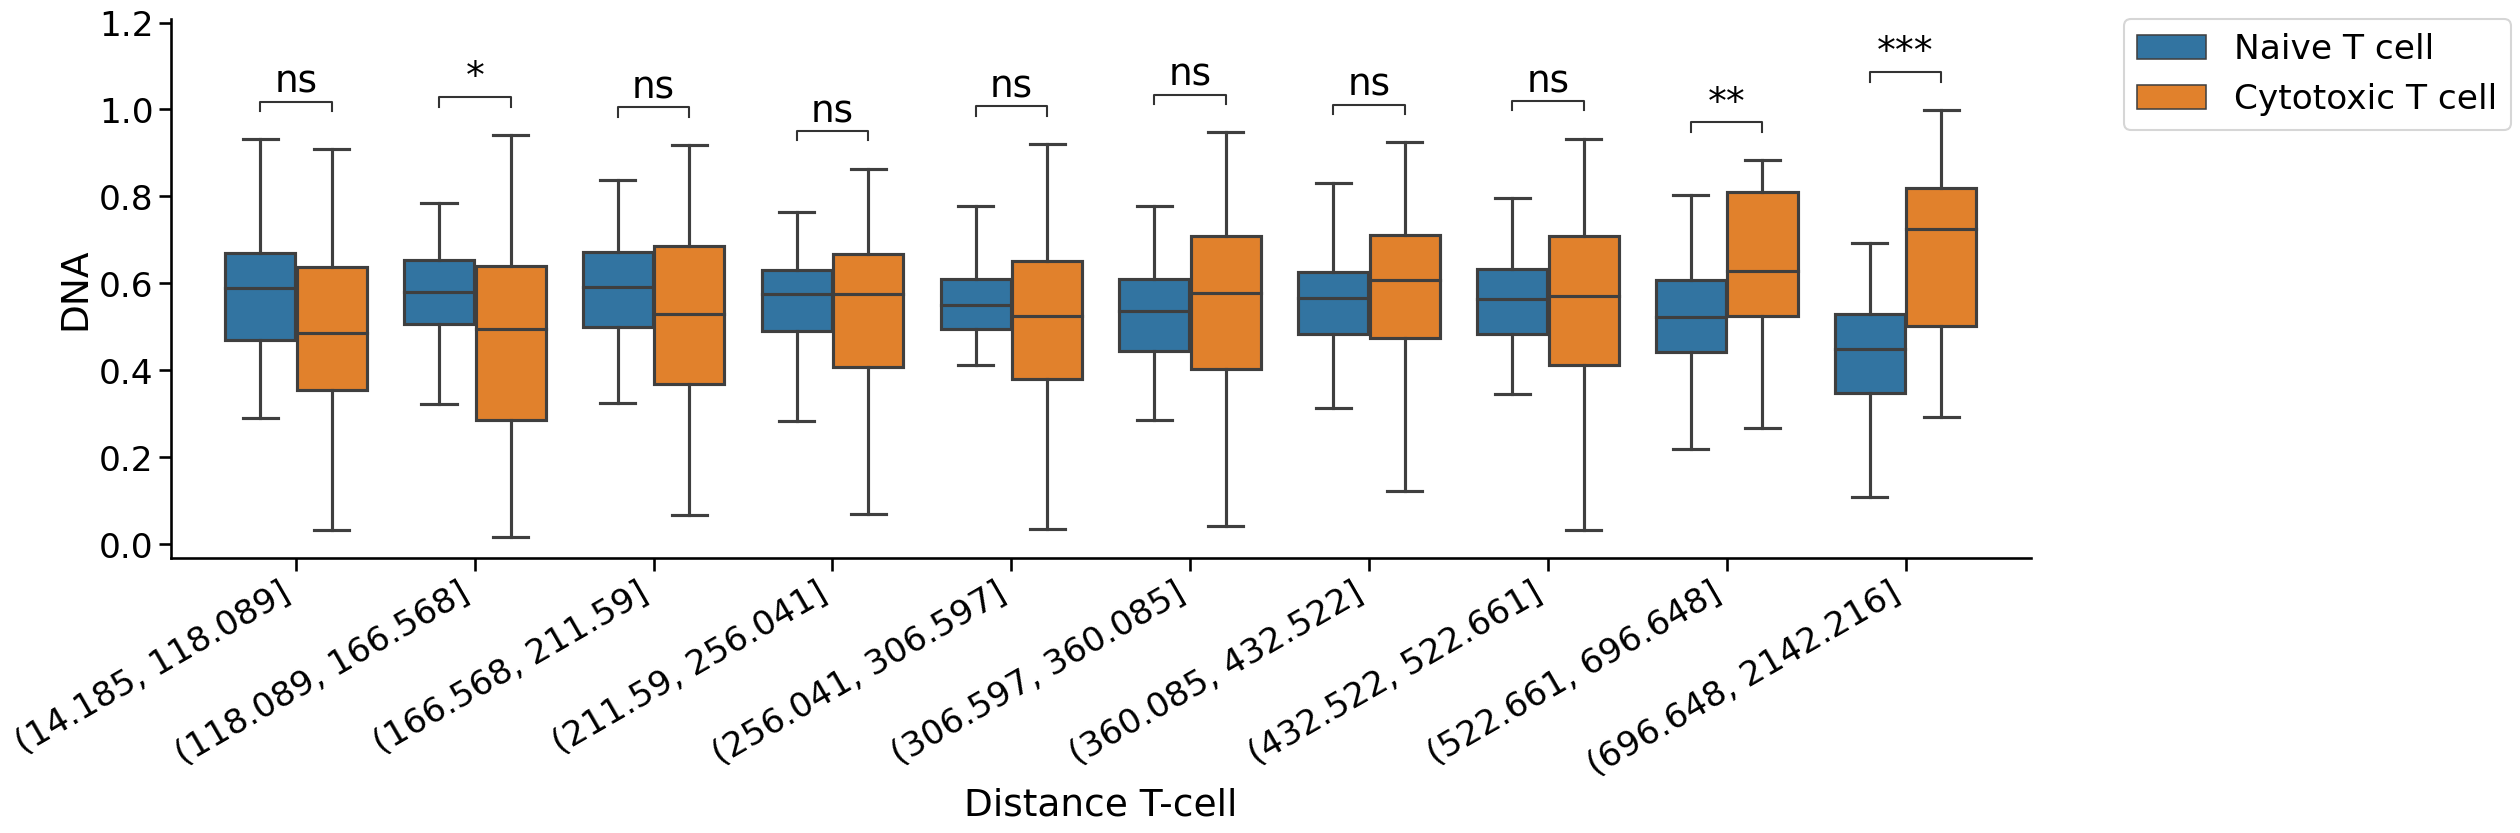

In [103]:
# Boxplot per cell
save_path = r"Y:\coskun-undergrads\Mingshuang\Thomas\CoCulture\results\cancer_cell_comparison"
for i in df_all_cancer_corrected:
    if (i == 'neighbor') | (i == 'Distance T-cell bucket') | (i == 'Distance to T-cell') | (i == 'Distance T-cell'):
        continue
    if (i == 'DNA'):

        print(i)
        A = df_all_cancer_corrected[[i, 'neighbor',"Distance T-cell"]]
        plotting = {
            "data": A,
            "x": "Distance T-cell",
            "y": i,
            "hue": "neighbor"
        }
        full_path = os.path.join(save_path, f'cancer_{i}')
        plot(plotting, full_path)
        sns.despine()

In [ ]:
#cytotoxic

# Get distance
centroid_all_pos1_cyto = centroid_cytotoxic[df_prop_cytotoxic.FOV == 'pos1']
centroid_can_pos1_cyto = centroid_all_pos1_cyto[df_pos1_cytotoxic.Cell_type_name == 'cancer cell interacting with CytoT']
d = get_distance(centroid_can_pos1_cyto, centroid_all_pos1_cyto)

# Assign to dataframe
df_pos1_cytotoxic['Distance to cancer-cell'] = d

# Get distance
centroid_all_pos2_cyto = centroid_cytotoxic[df_prop_cytotoxic.FOV == 'pos2']
centroid_can_pos2_cyto = centroid_all_pos2_cyto[df_pos2_cytotoxic.Cell_type_name == 'cancer cell interacting with CytoT']
d = get_distance(centroid_can_pos2_cyto, centroid_all_pos2_cyto)

# Assign to dataframe
df_pos2_cytotoxic['Distance to cancer-cell'] = d

In [ ]:
#naive

# Get distance
centroid_all_pos1_naive = centroid_naive[df_prop_naive.FOV == 'pos1']
centroid_can_pos1_naive = centroid_all_pos1_naive[df_pos1_naive.Cell_type_name == 'cancer cell interacting with NaiveT']
d = get_distance(centroid_can_pos1_naive, centroid_all_pos1_naive)
# Assign to dataframe
df_pos1_naive['Distance to cancer-cell'] = d

# Get distance
centroid_all_pos2_naive = centroid_naive[df_prop_naive.FOV == 'pos2']
centroid_can_pos2_naive = centroid_all_pos2_naive[df_pos2_naive.Cell_type_name == 'cancer cell interacting with NaiveT']
d = get_distance(centroid_can_pos2_naive, centroid_all_pos2_naive)

# Assign to dataframe
df_pos2_naive['Distance to cancer-cell'] = d

In [42]:
df_both_cytotoxic = pd.concat([df_pos1_cytotoxic, df_pos2_cytotoxic])
df_both_naive = pd.concat([df_pos1_naive, df_pos2_naive])

In [45]:
# Tumor cell: marker expression versus distance with respect to T cell:
df_cancer_cyto = df_both_cytotoxic[df_both_cytotoxic.Cell_type_name == 'Cytotoxic T cell'].copy()
df_cancer_cyto.drop(['Row', 'Cols', 'FOV', 'Cell Type', 'Cell_label'], axis=1, inplace=True)


df_cancer_naive = df_both_naive[df_both_naive.Cell_type_name == 'Naive T cell'].copy()
df_cancer_naive.drop(['Row', 'Cols', 'FOV', 'Cell Type', 'Cell_label'], axis=1, inplace=True)

df_all_T = pd.concat([df_cancer_cyto, df_cancer_naive])

In [47]:
df_all_T[f'Distance cancer-cell'] = pd.qcut(df_all_T['Distance to cancer-cell'], 5, duplicates='drop')
LE = LabelEncoder()
df_all_T[f'Distance cancer-cell bucket'] = LE.fit_transform(df_all_T[f'Distance cancer-cell'])

In [48]:
df_cytotoxic = df_all_T[df_all_T['Cell_type_name'] == 'Cytotoxic T cell']
df_naive = df_all_T[df_all_T['Cell_type_name'] == 'Naive T cell']

In [49]:
df_all_T_corrected = pd.concat([df_cytotoxic, df_naive])

In [ ]:
# Boxplot per cell
save_path = r"Y:\coskun-undergrads\Mingshuang\Thomas\CoCulture\results\cancer_cell_comparison"
for i in df_all_cancer_corrected:
    if (i == 'neighbor') | (i == 'Distance T-cell bucket') | (i == 'Distance to T-cell') | (i == 'Distance T-cell'):
        continue
    print(i)
    A = df_all_cancer_corrected[[i, 'neighbor',"Distance T-cell"]]
    plotting = {
        "data": A,
        "x": "Distance T-cell",
        "y": i,
        "hue": "neighbor"
    }
    full_path = os.path.join(save_path, f'cancer_{i}')
    plot(plotting, full_path)
    sns.despine()

DNA
PanCK
Phalloidin
COXIV
PD-1
CD44
CD8
CD62L
GLUD12
TCF17
HIF-1
HK I
Granzyme B
ASNA
CD103
AMPK
pRB
ACADM
CPT1A
Cyclin E1
Arginase


C:\Users\mwang698\AppData\Local\Temp\ipykernel_62884\4080773797.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


NBD-Golgi
G6PD
GLUT1
MCT1
CD36
E-cadherin
PGC1a
PKM2
LDHA
Ki67
Cell_type_name
Distance to cancer-cell
Distance cancer-cell
Distance cancer-cell bucket


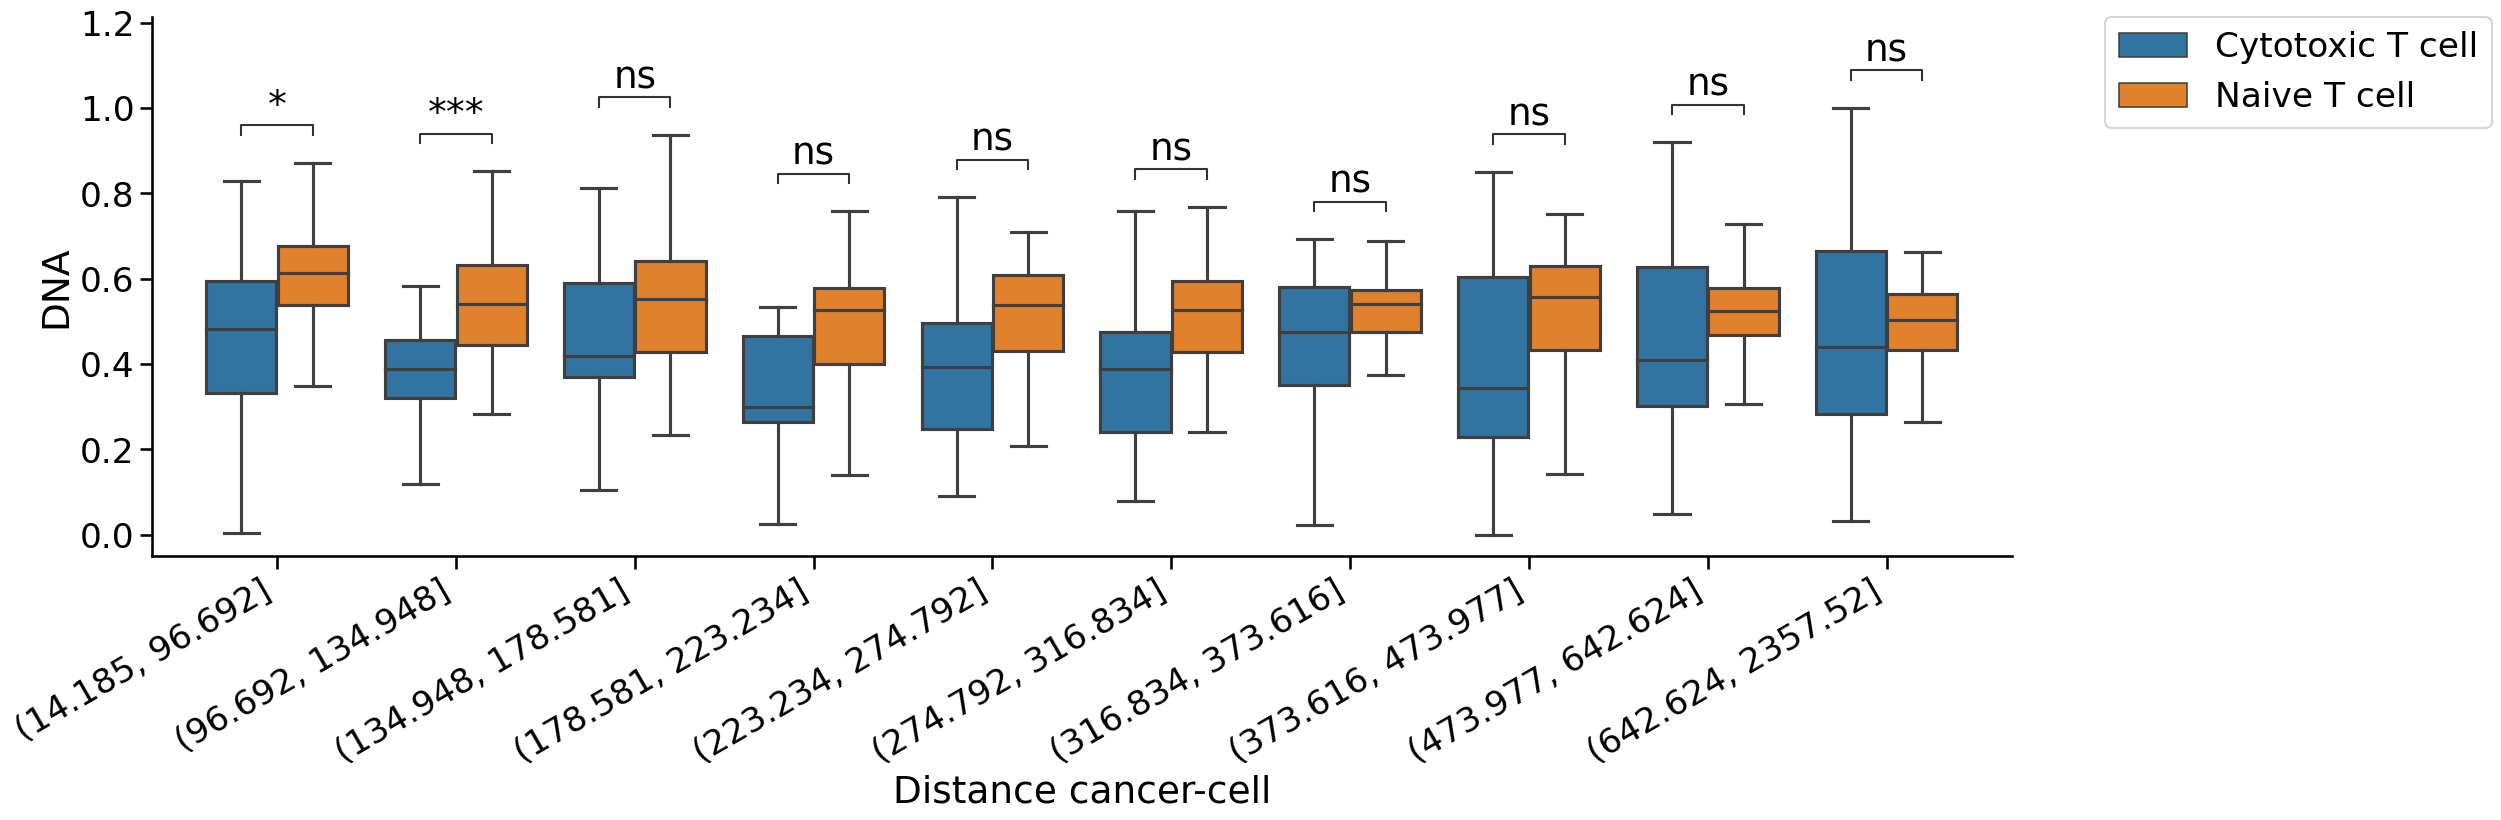

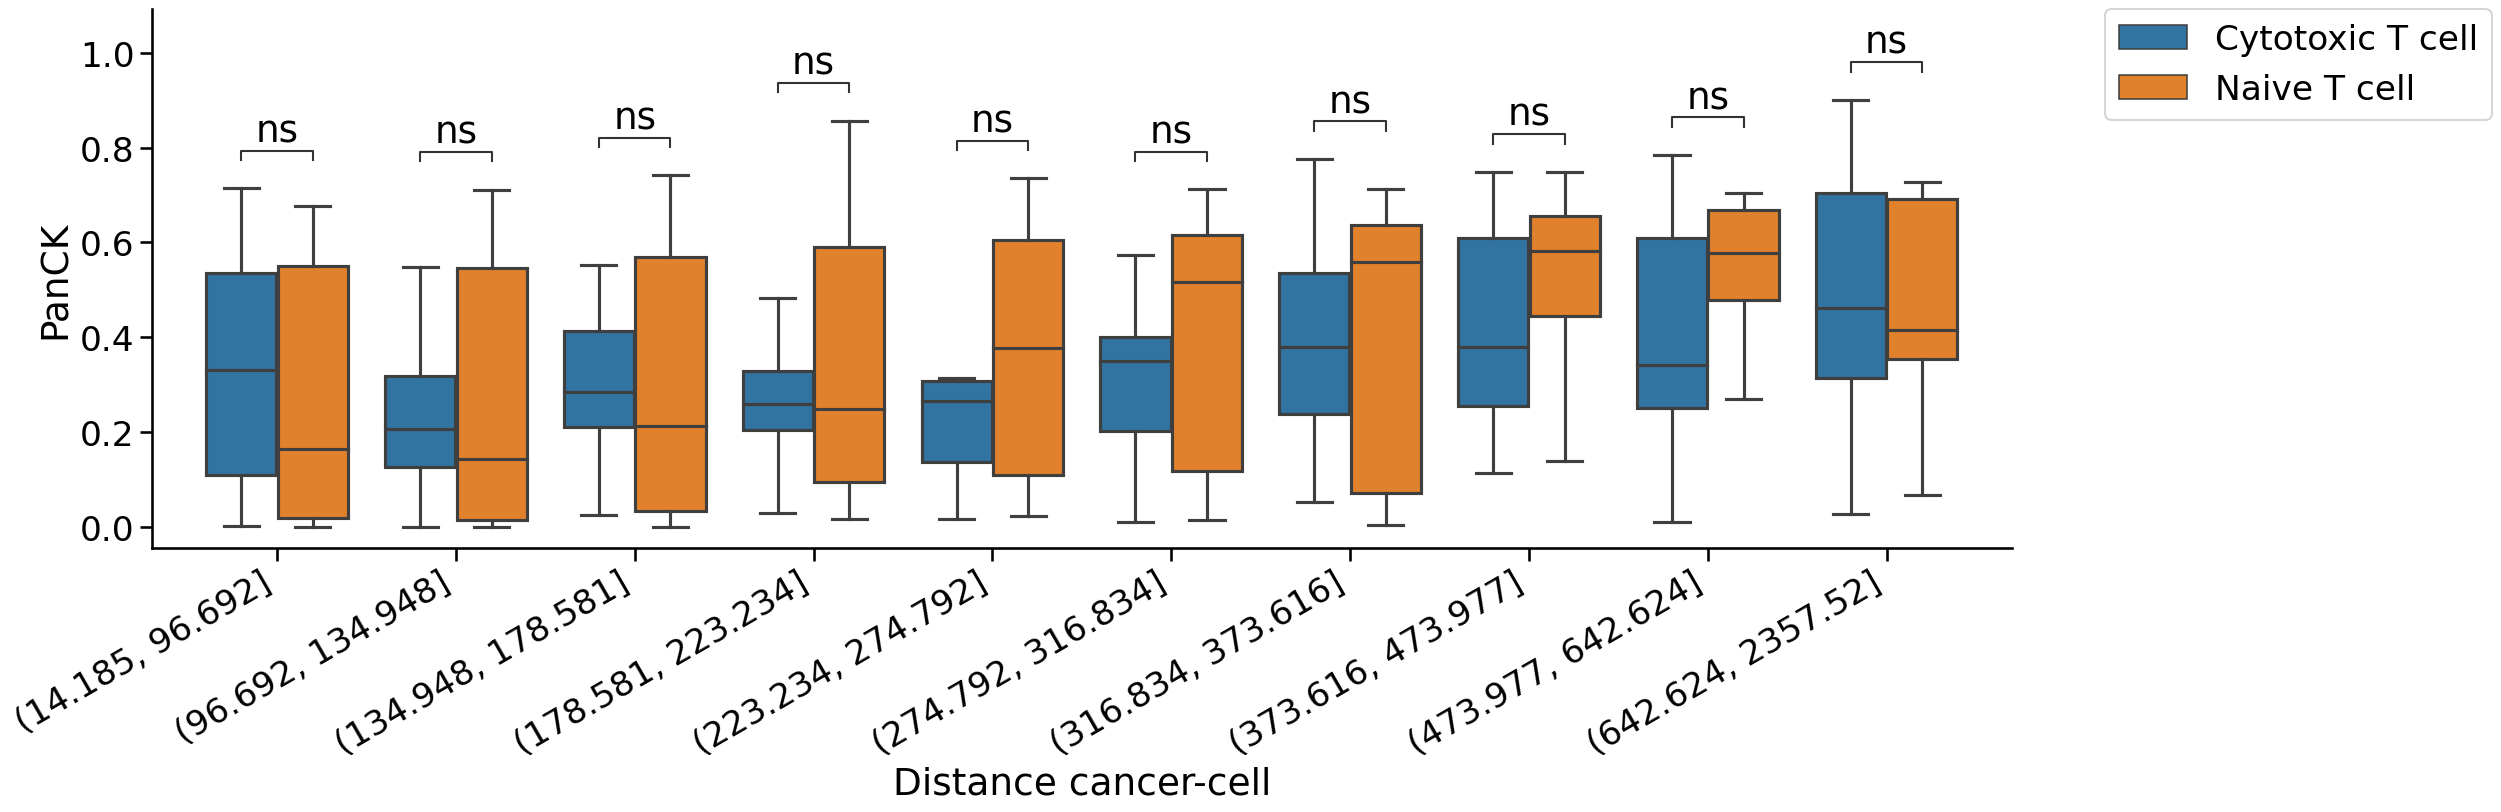

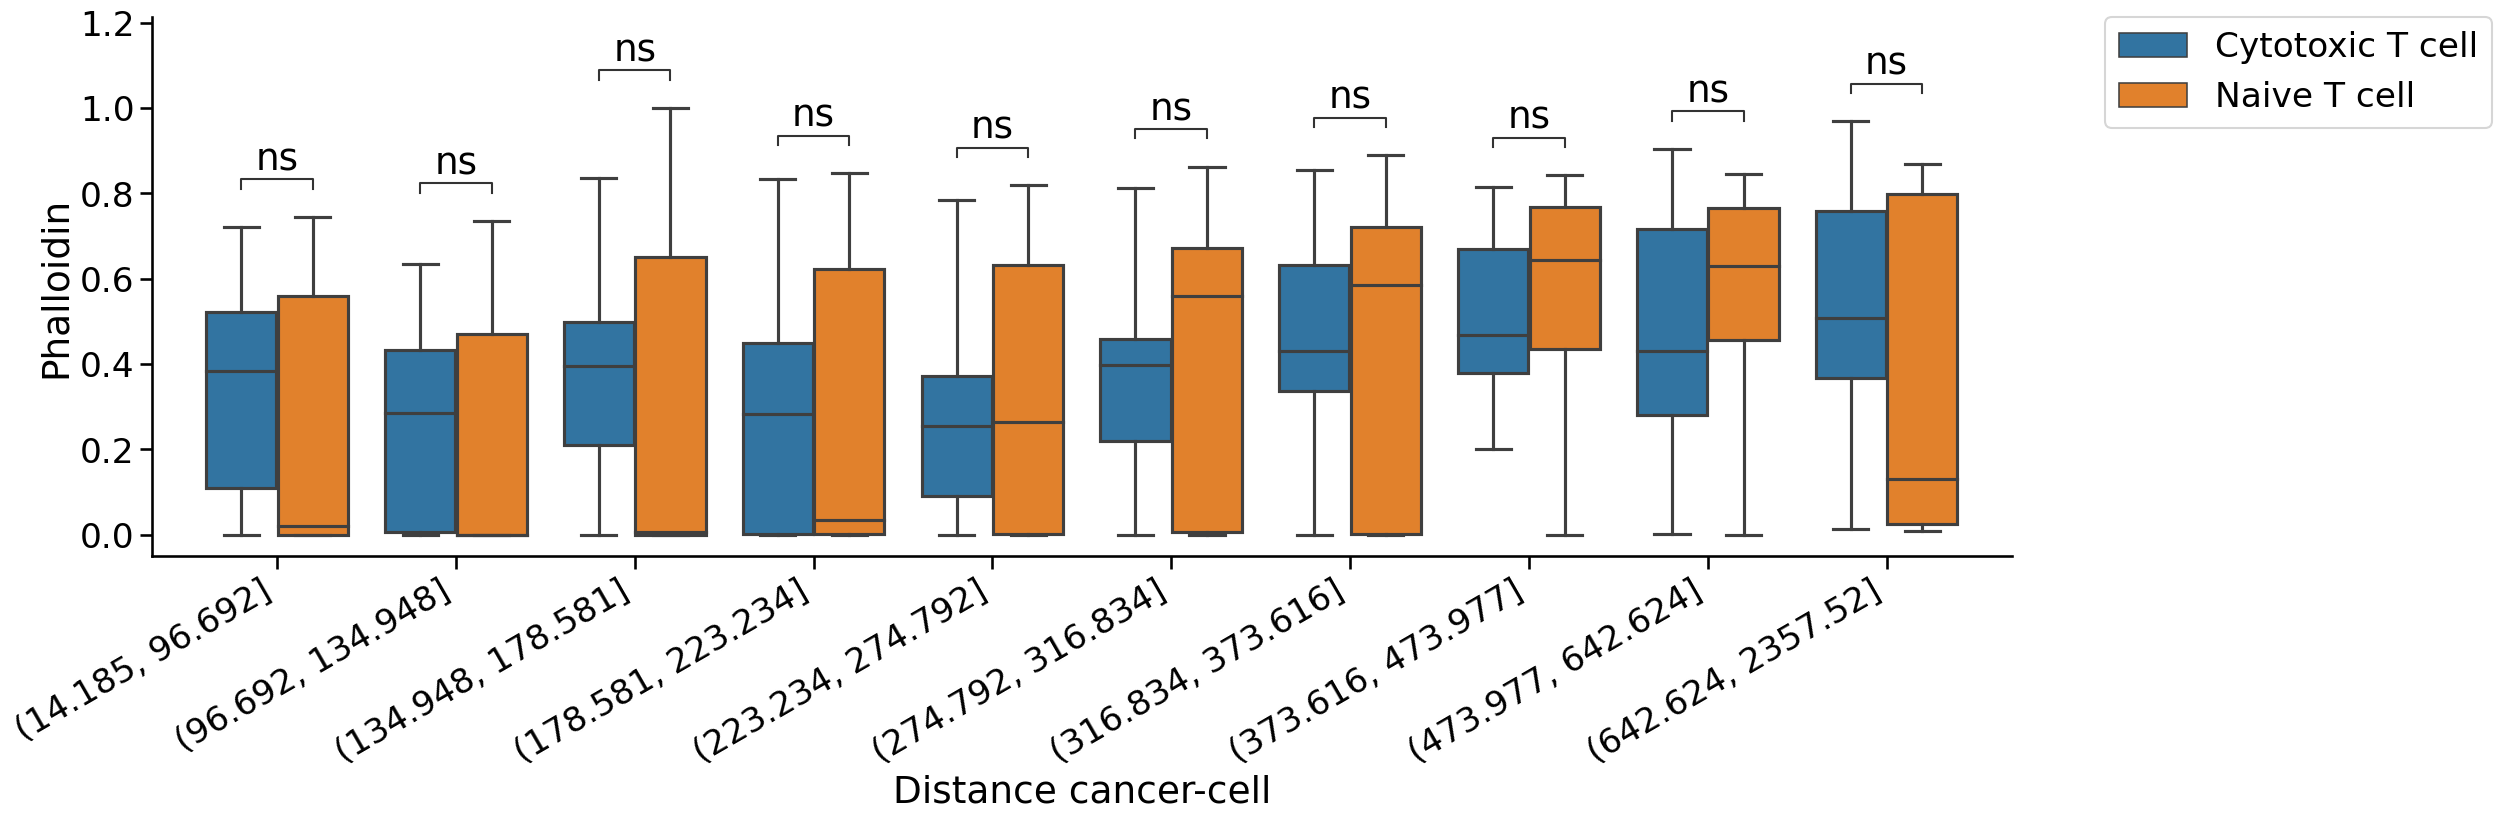

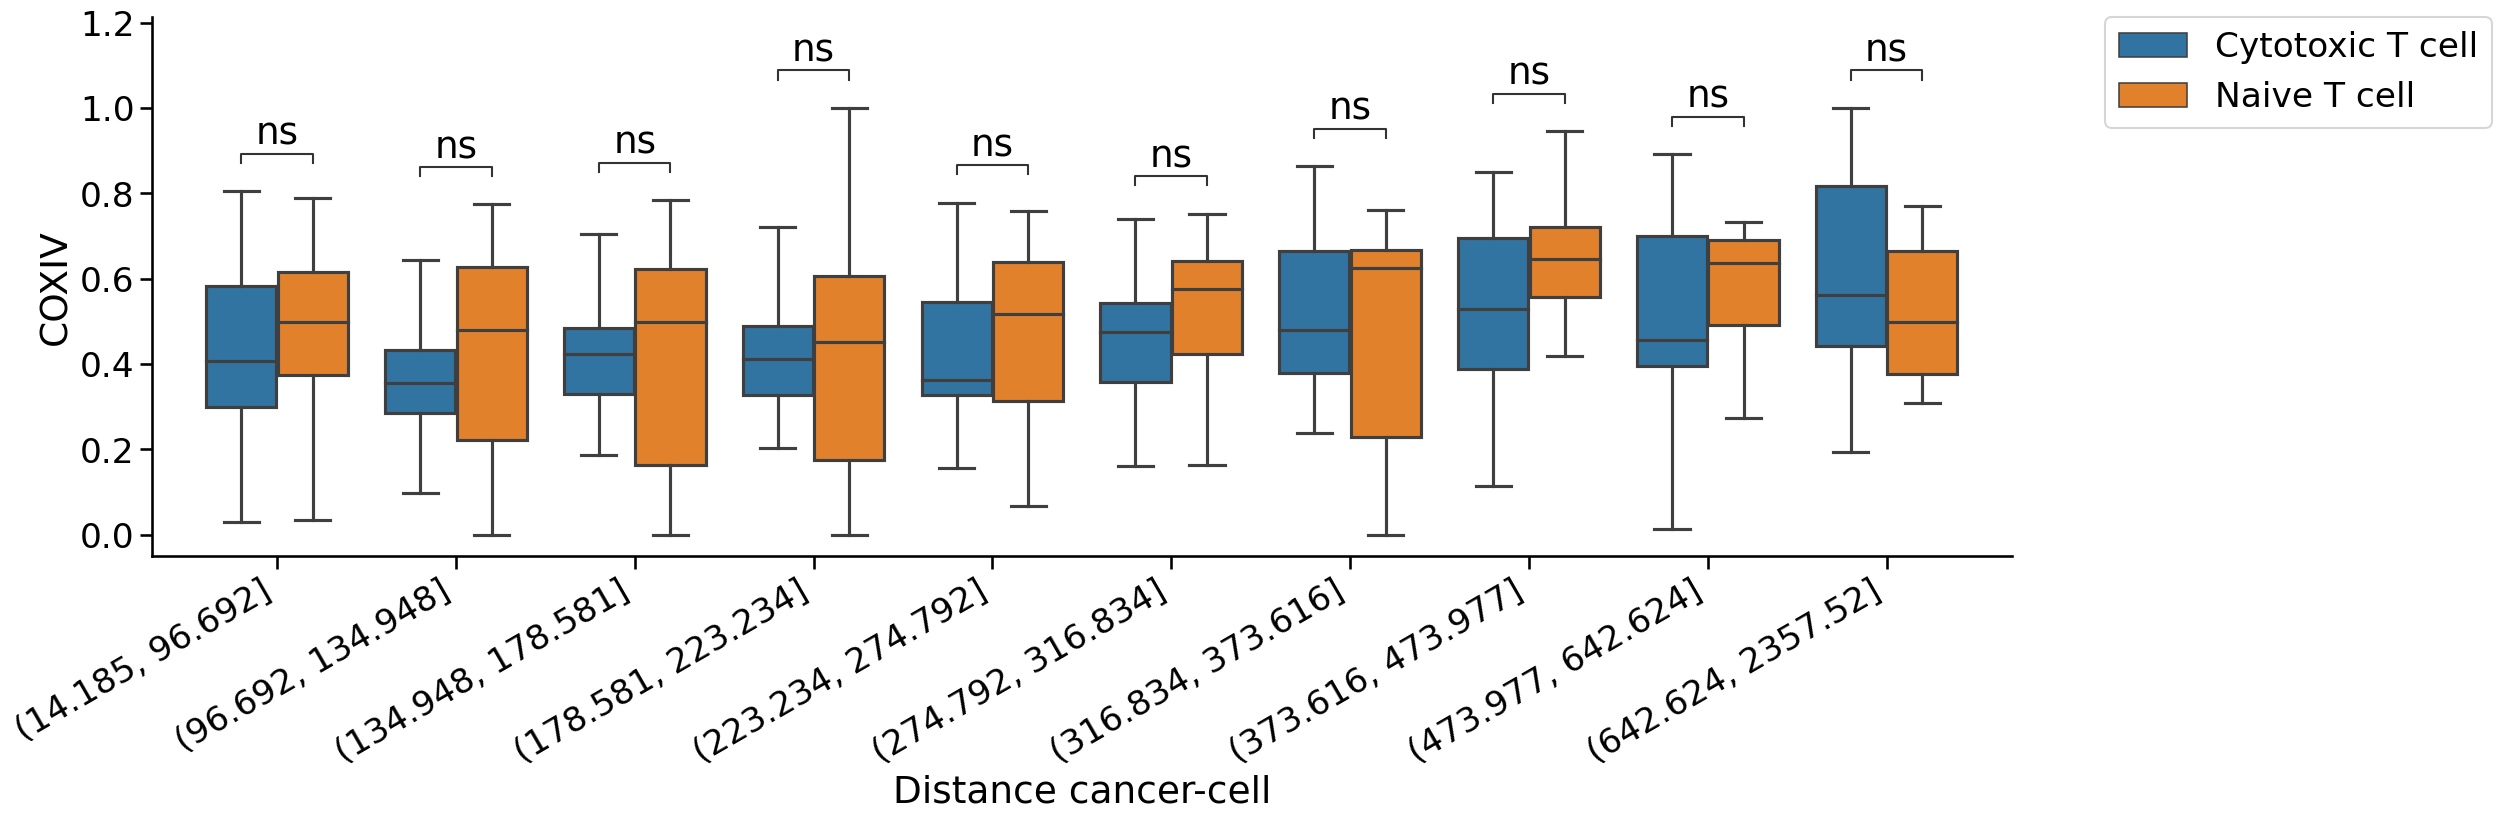

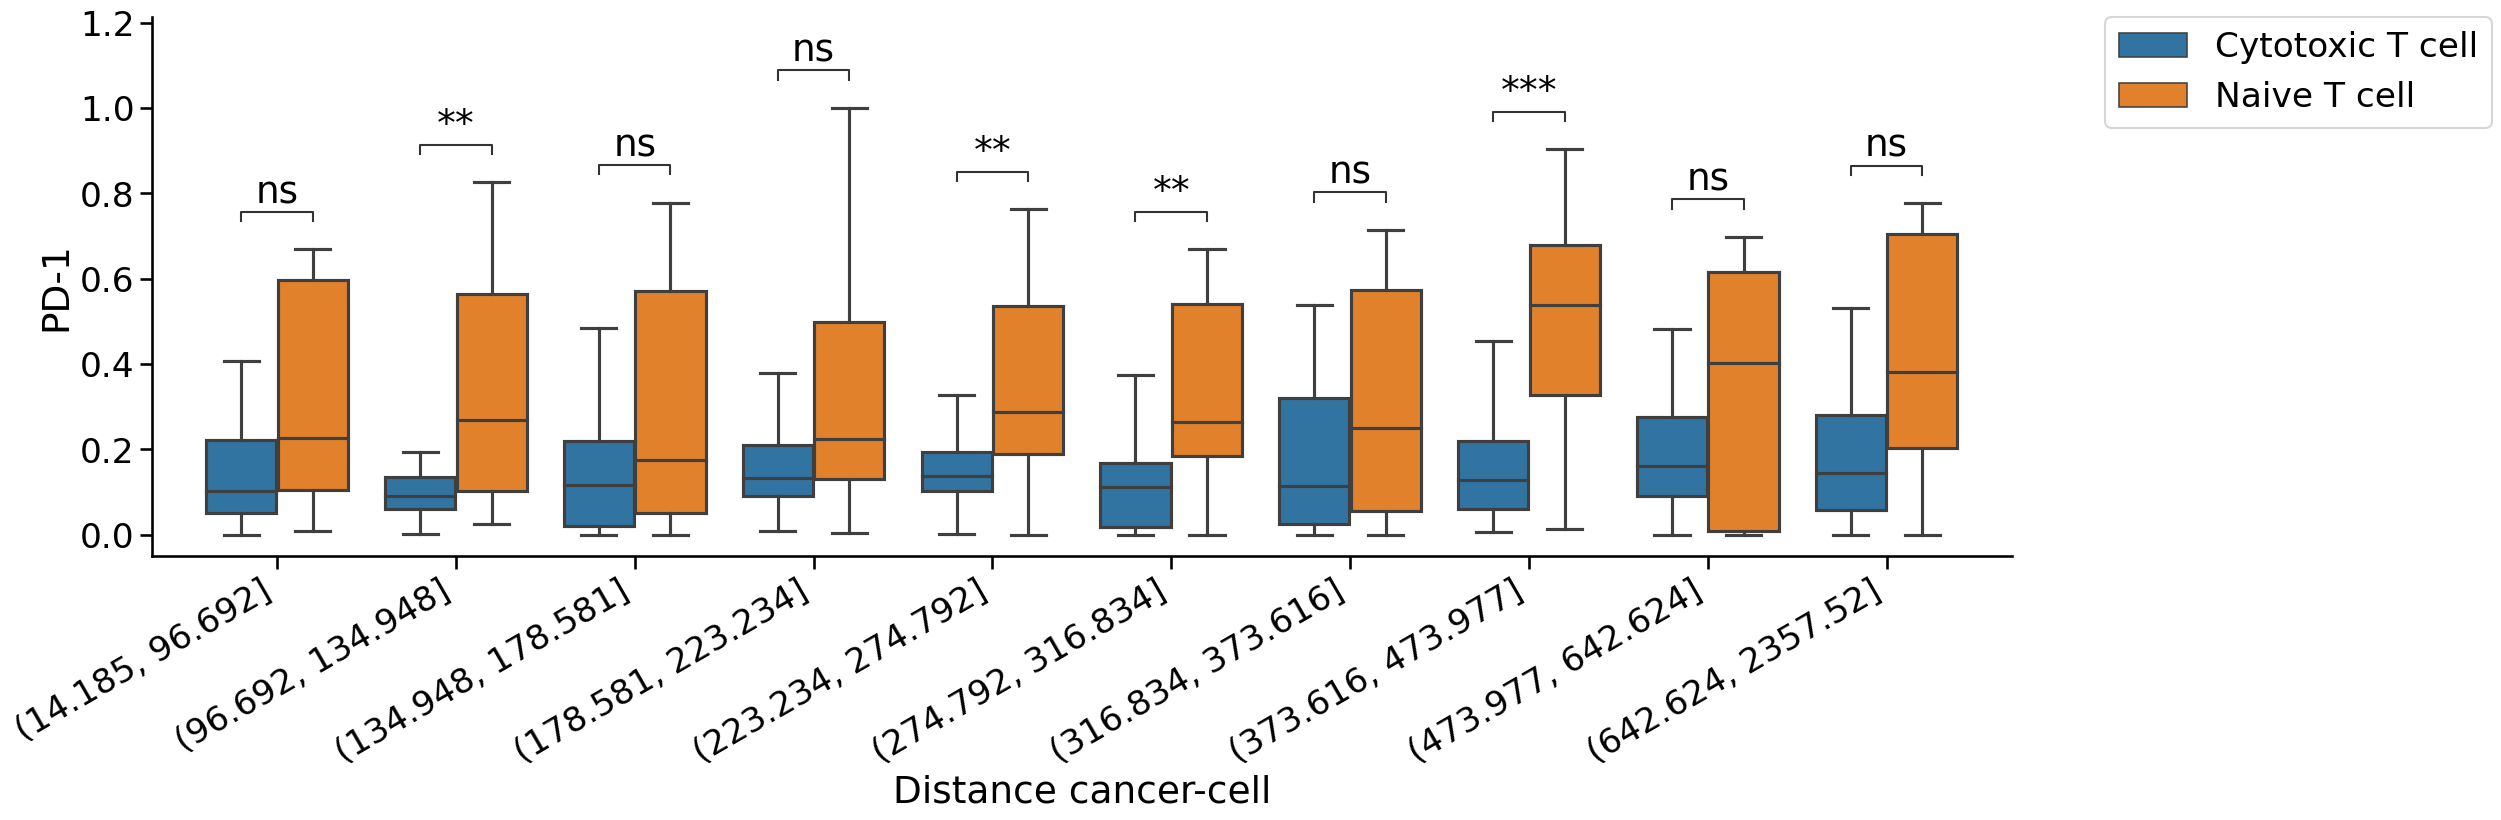

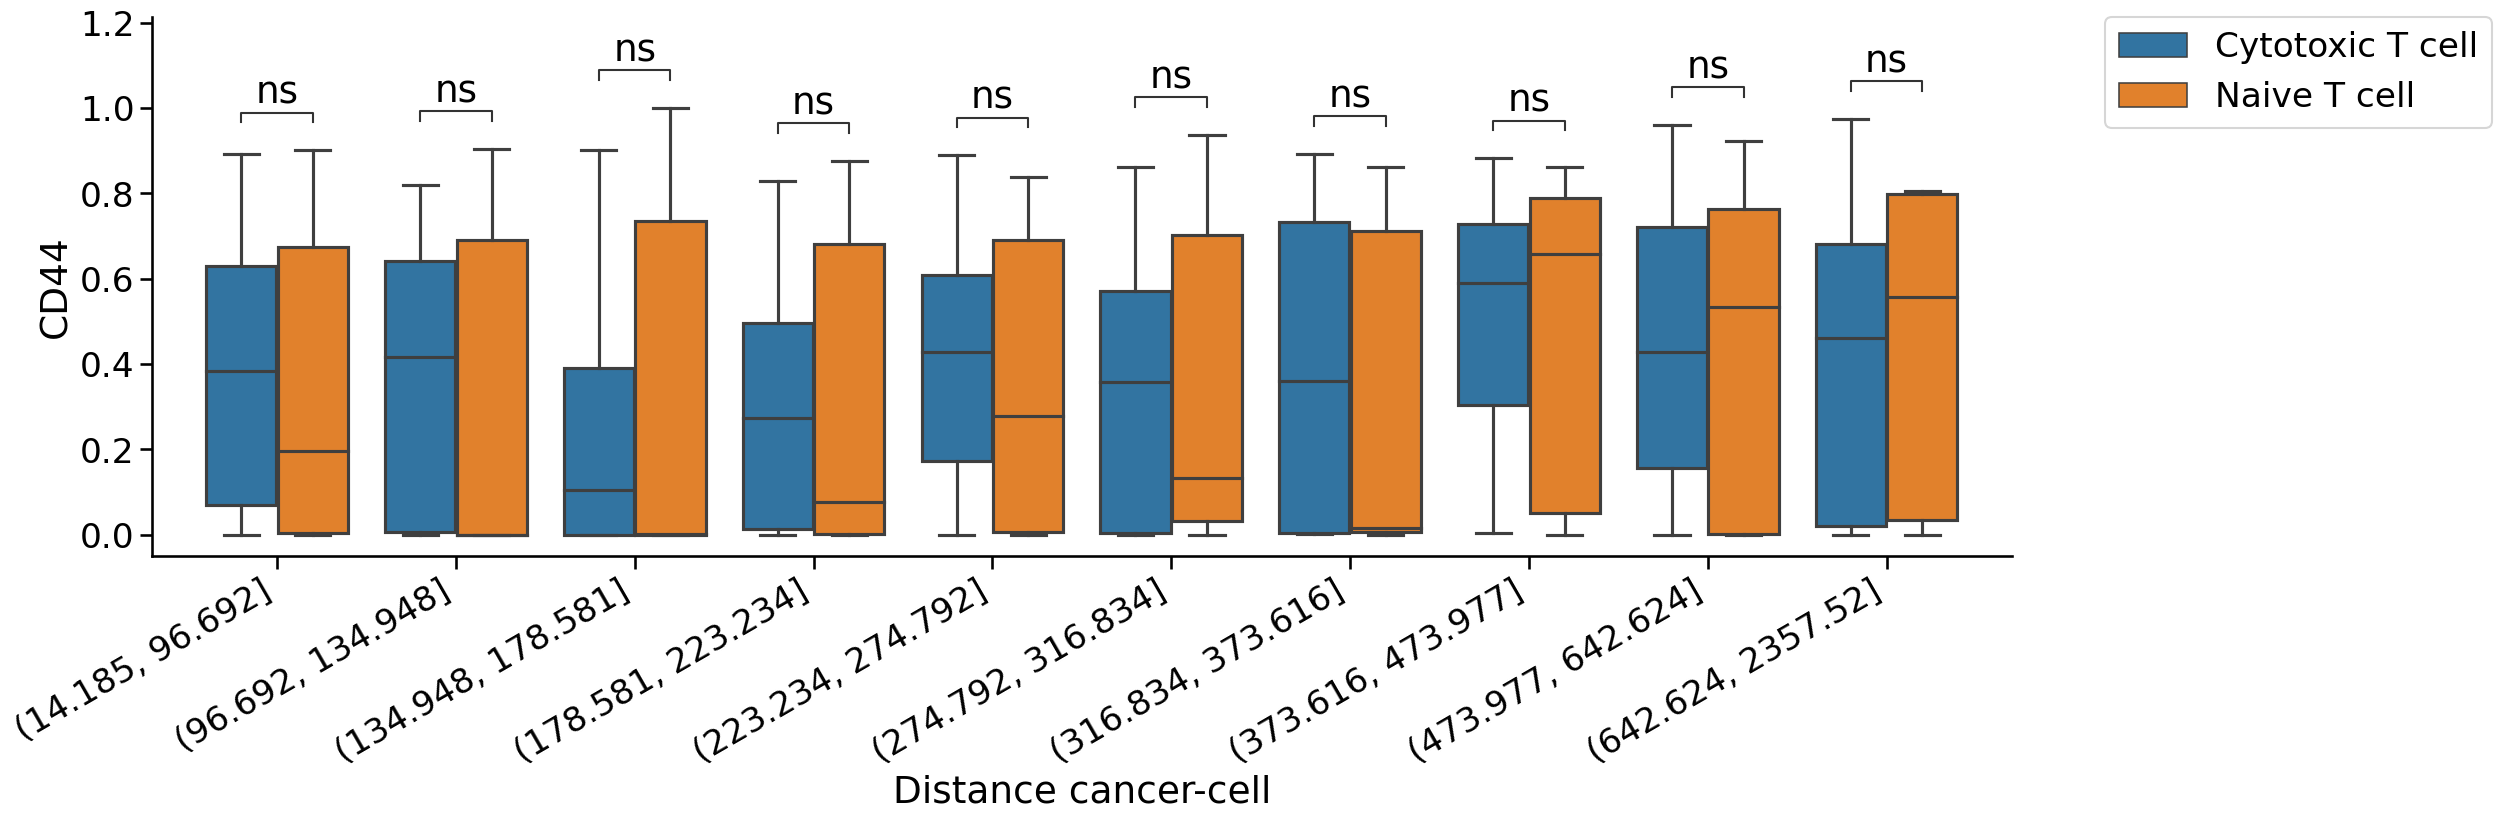

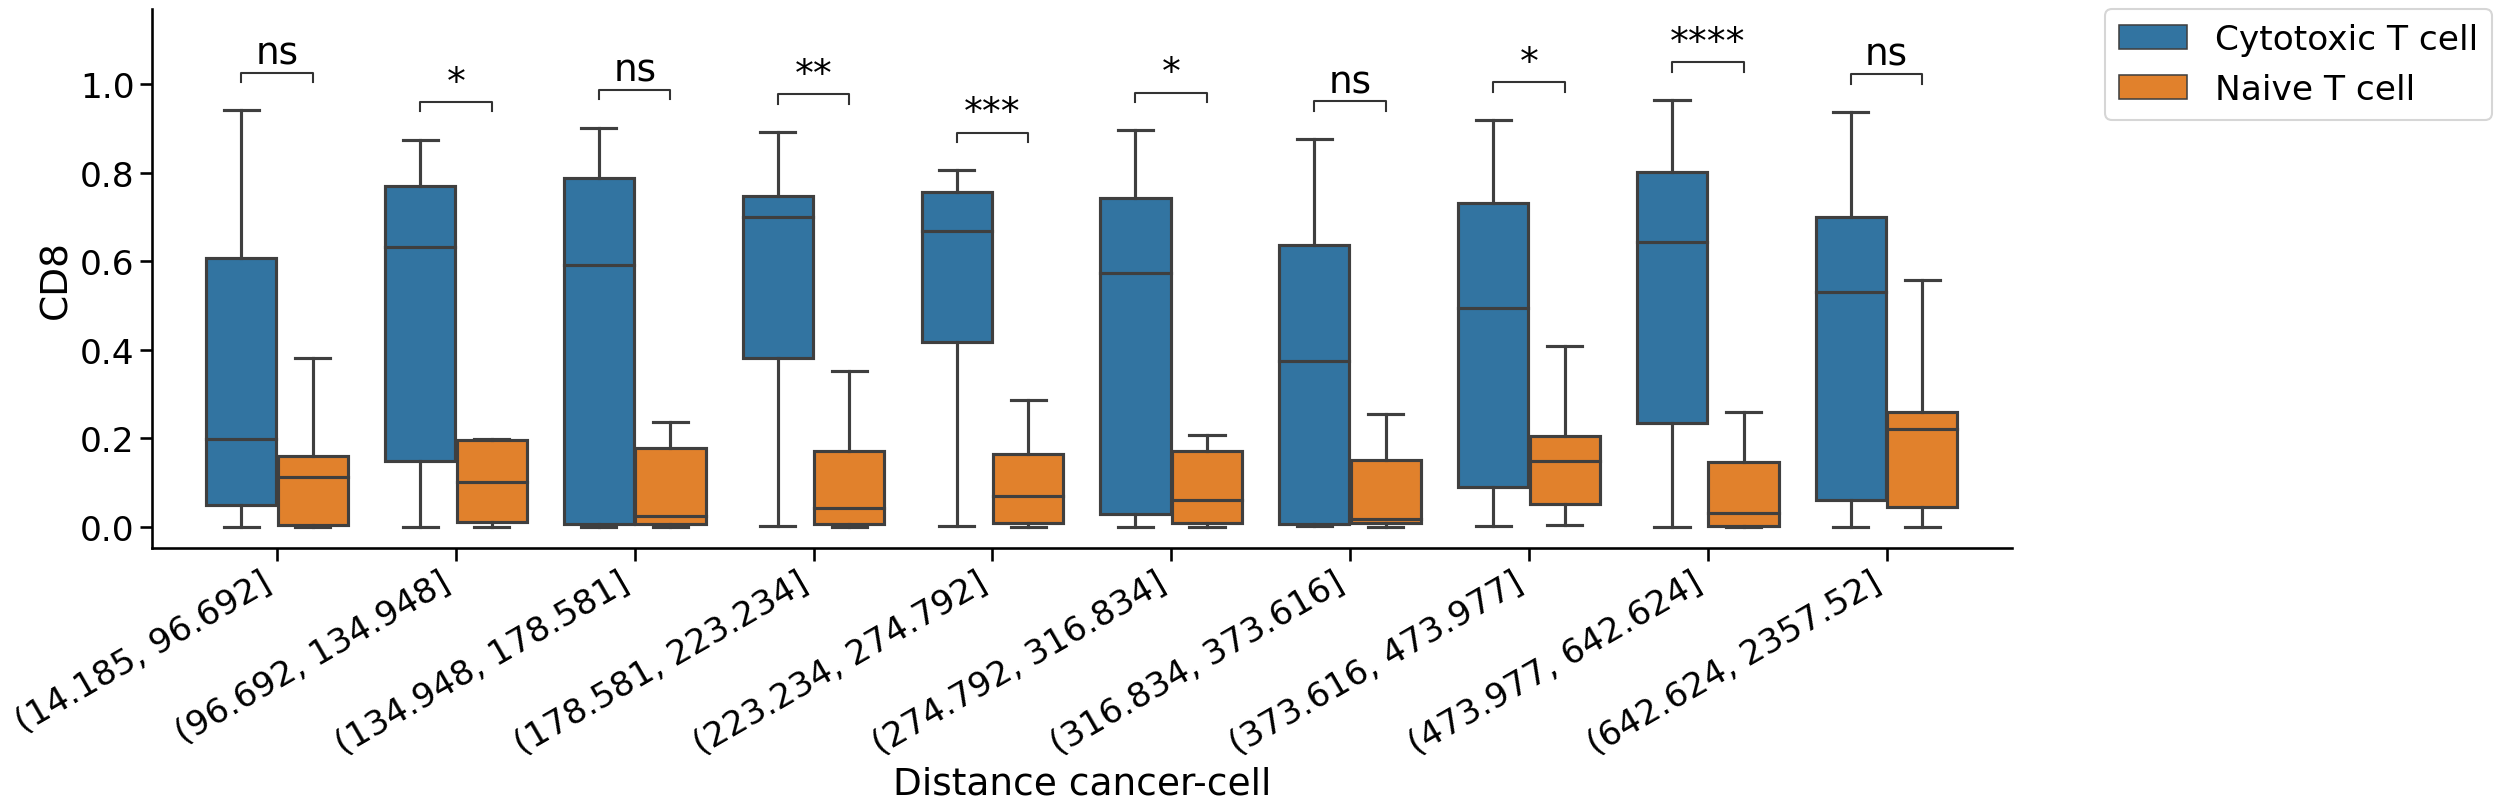

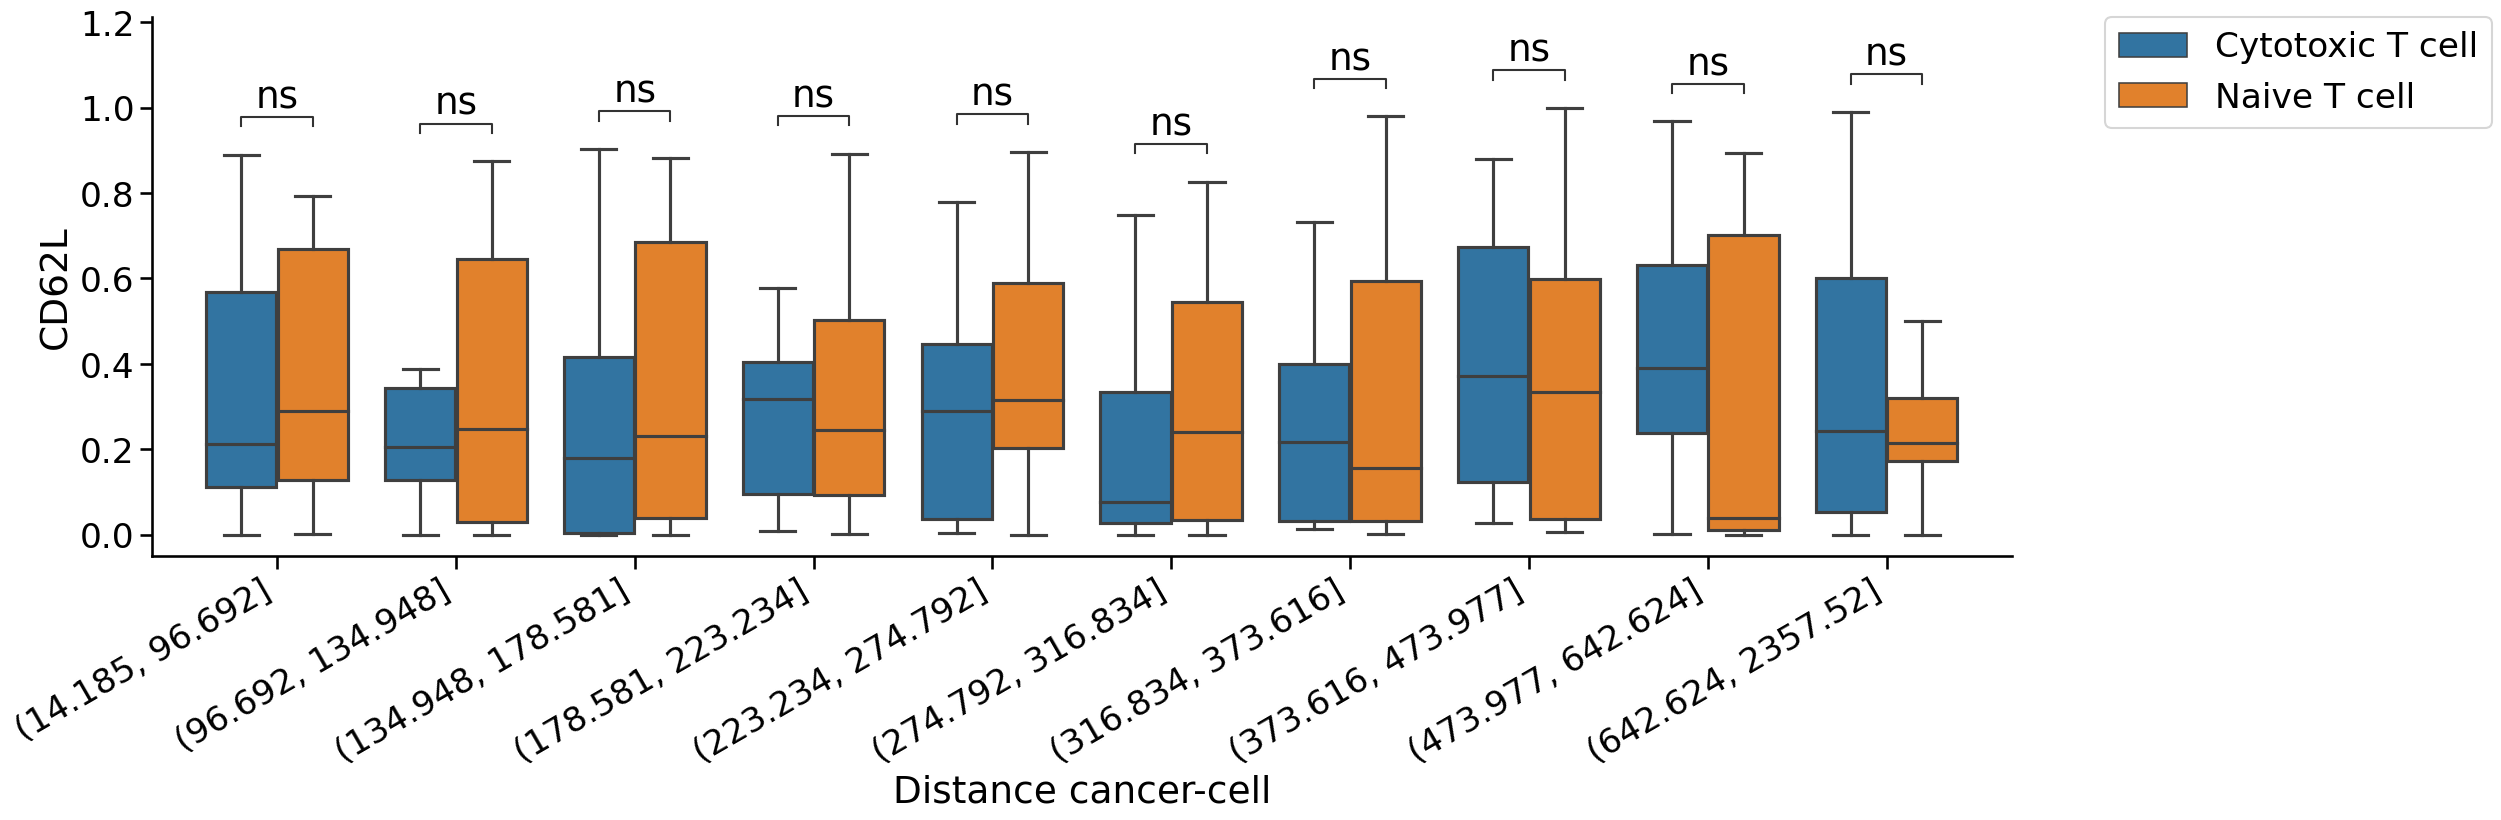

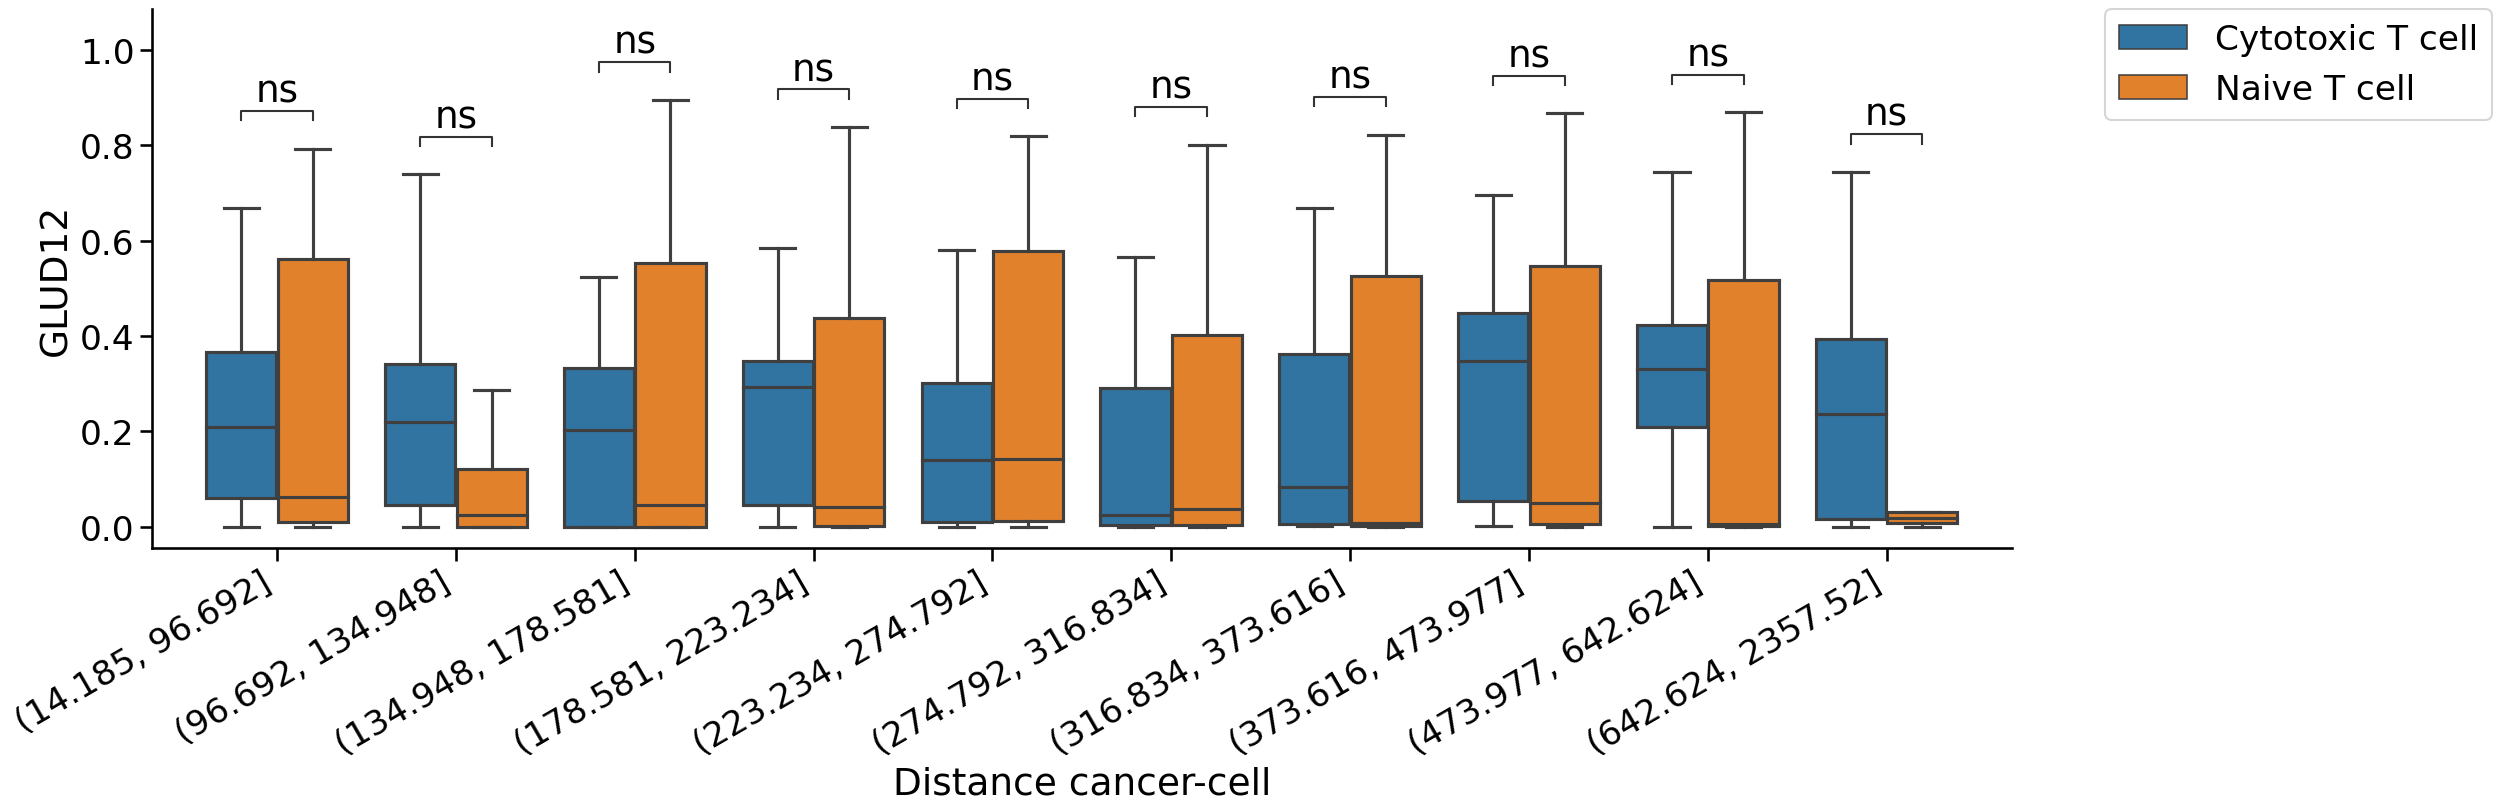

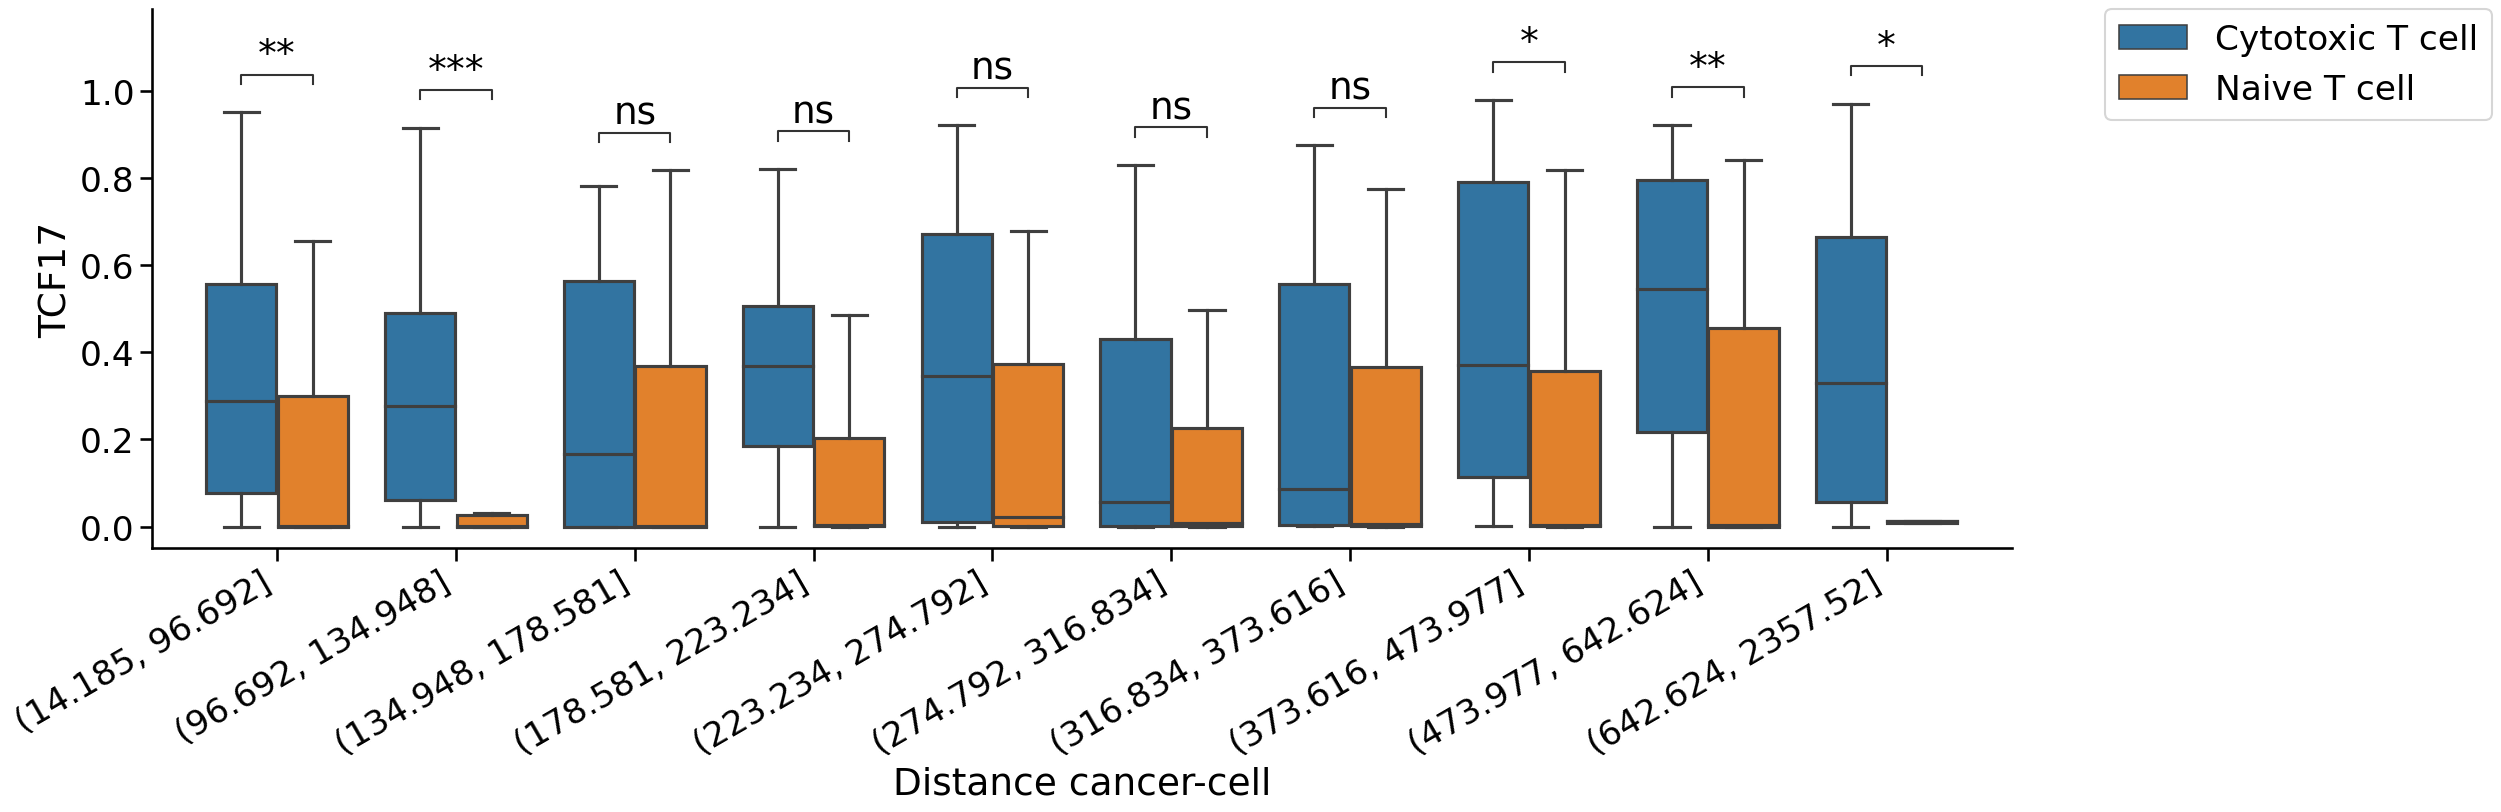

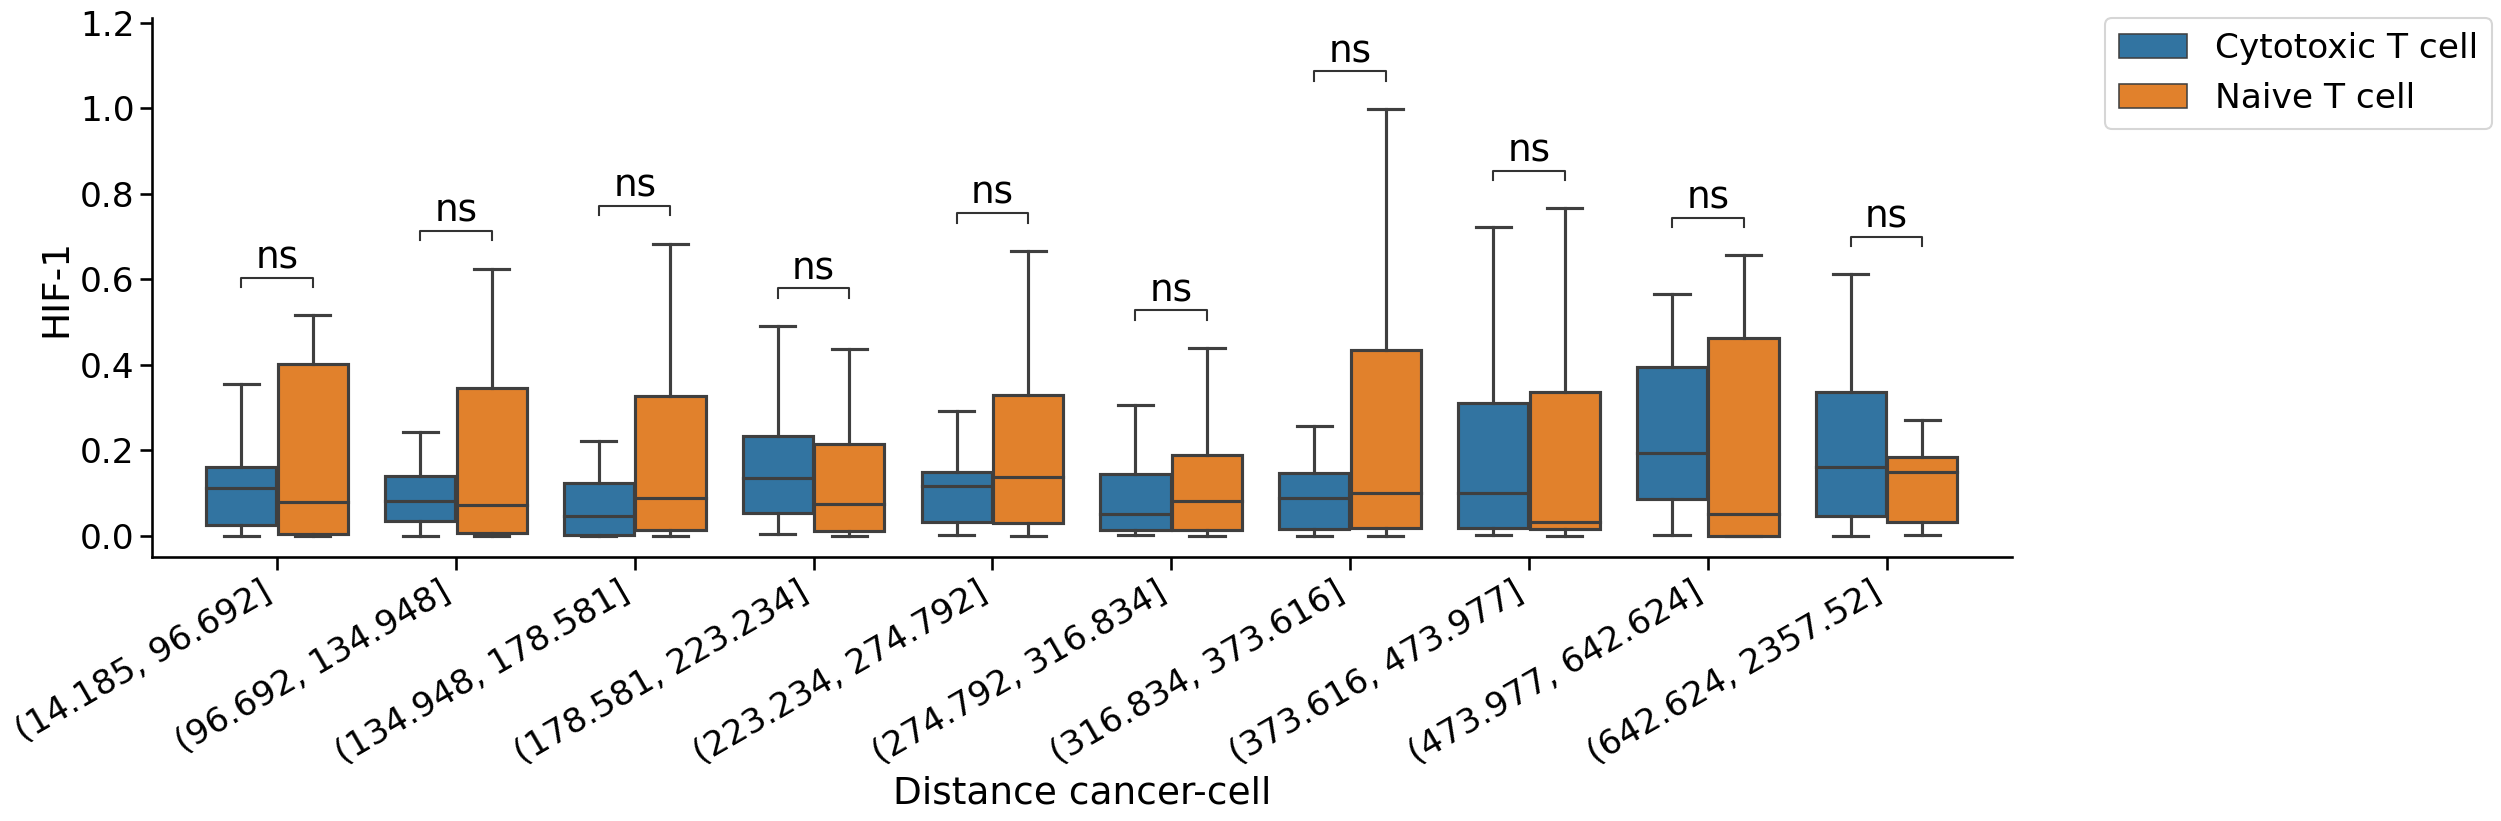

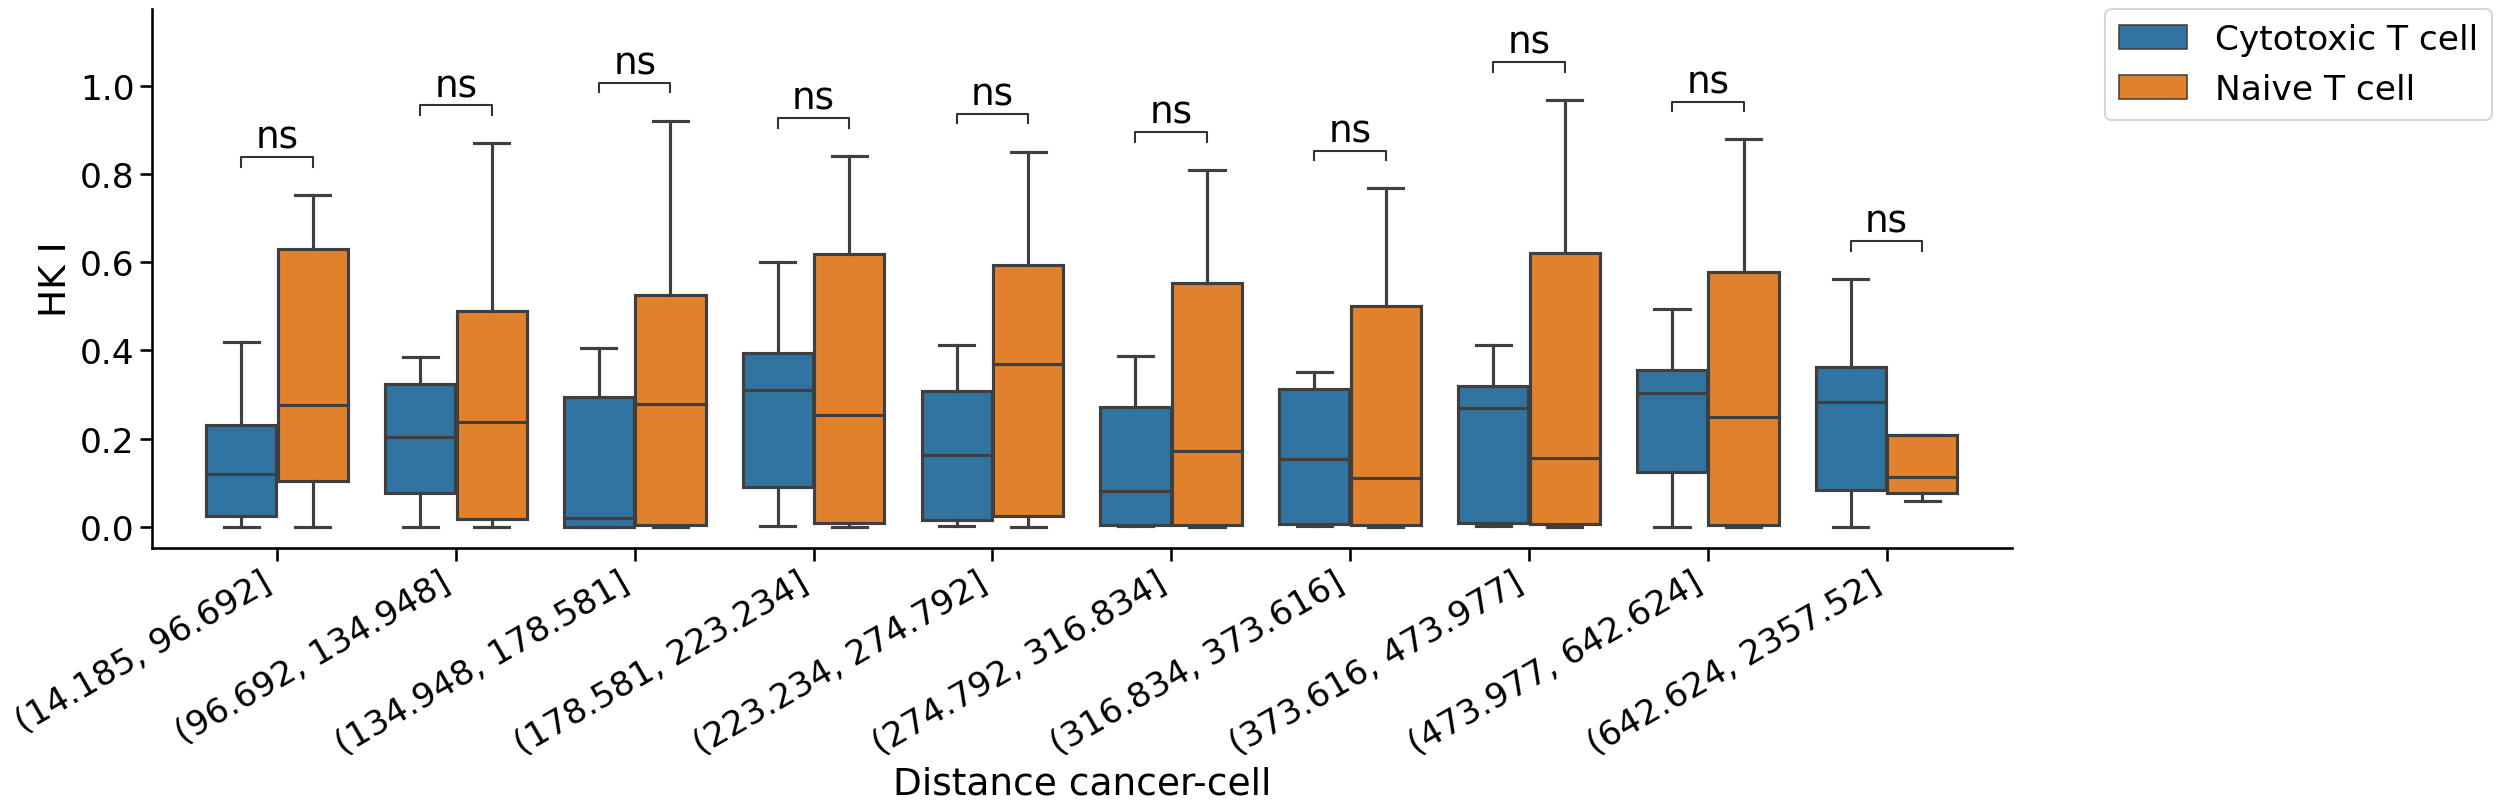

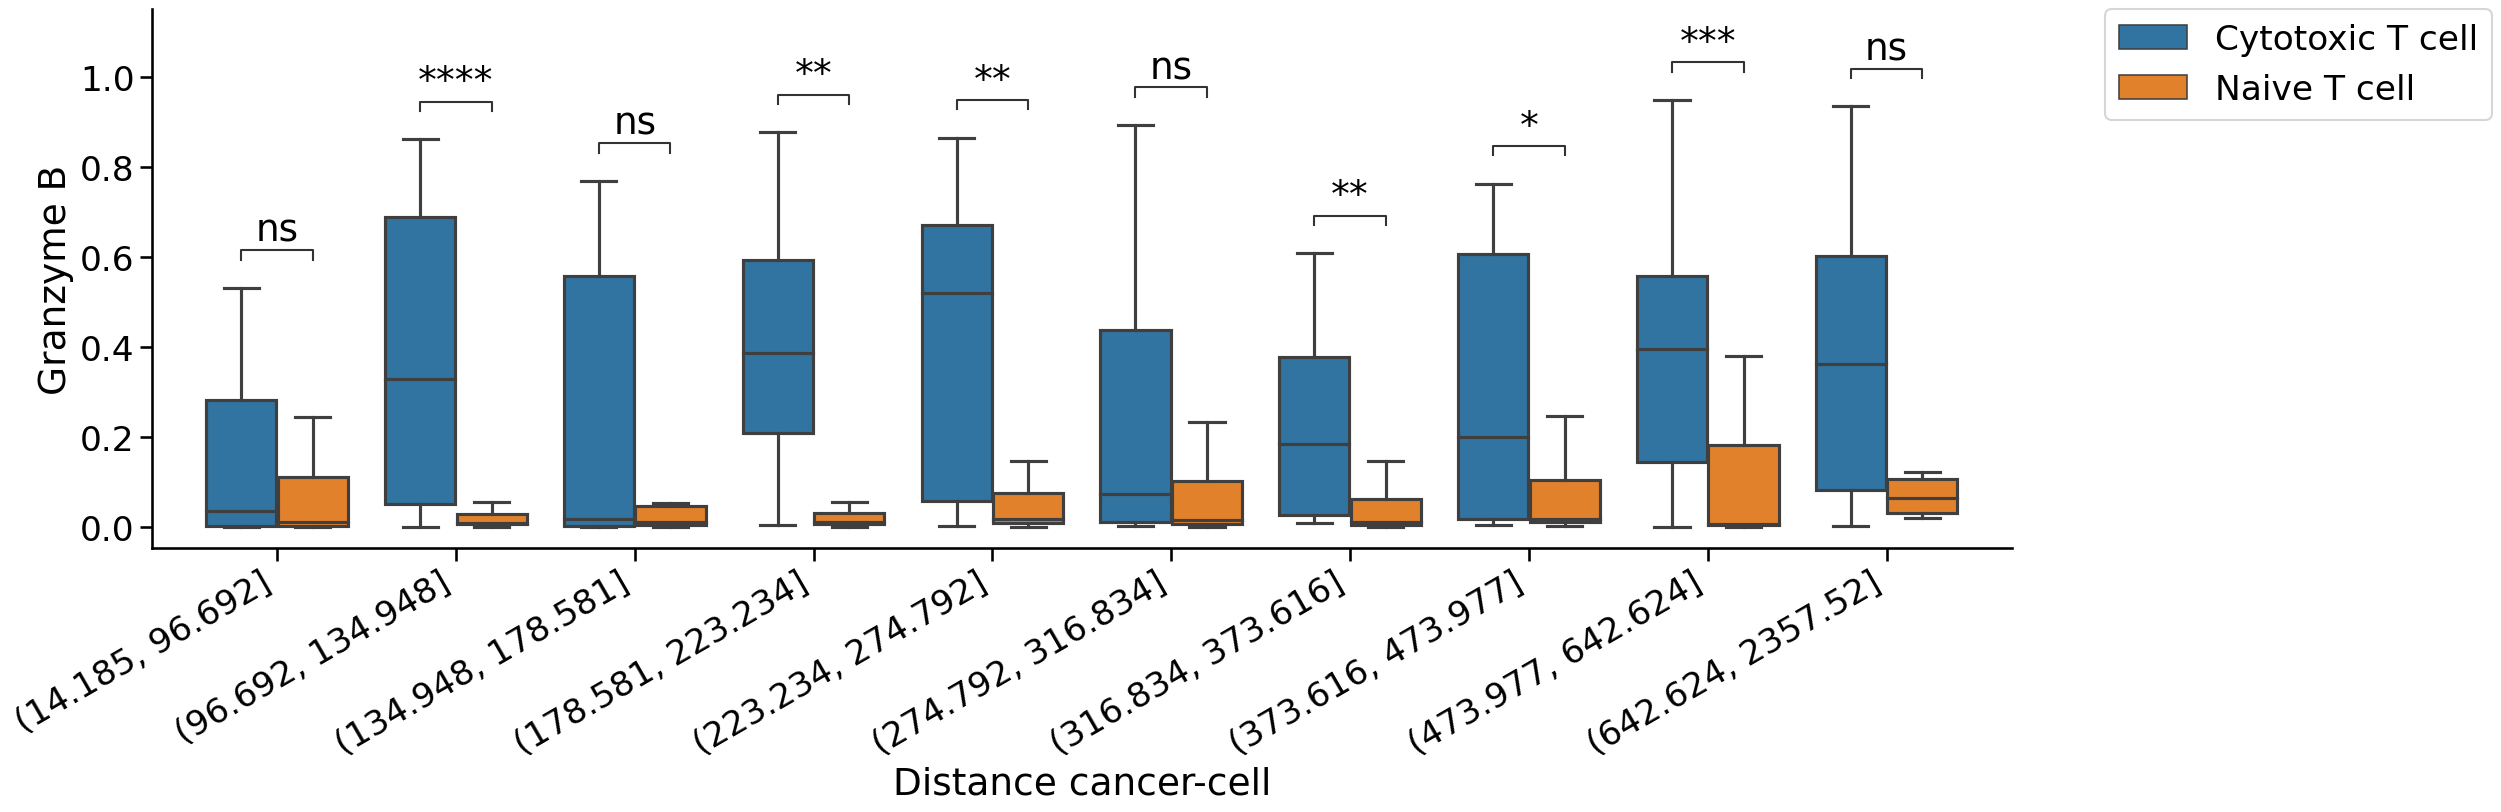

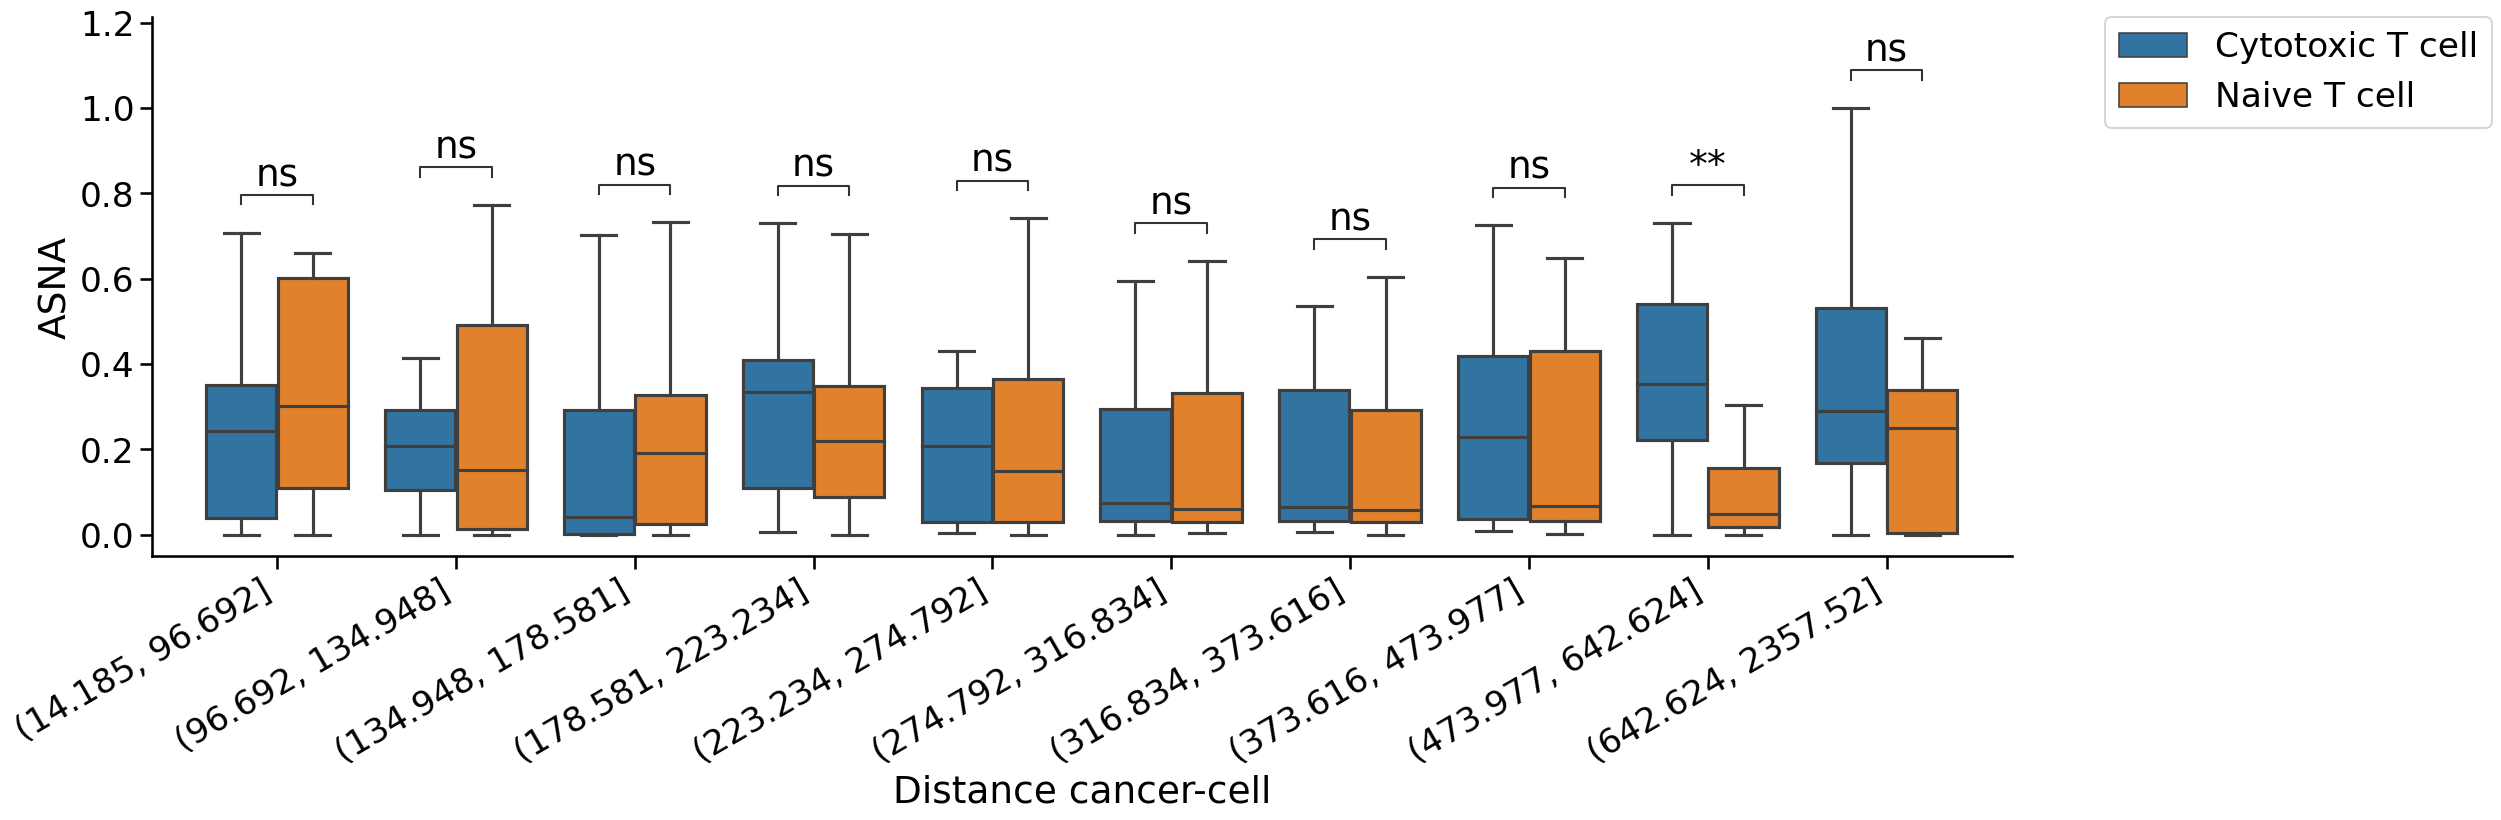

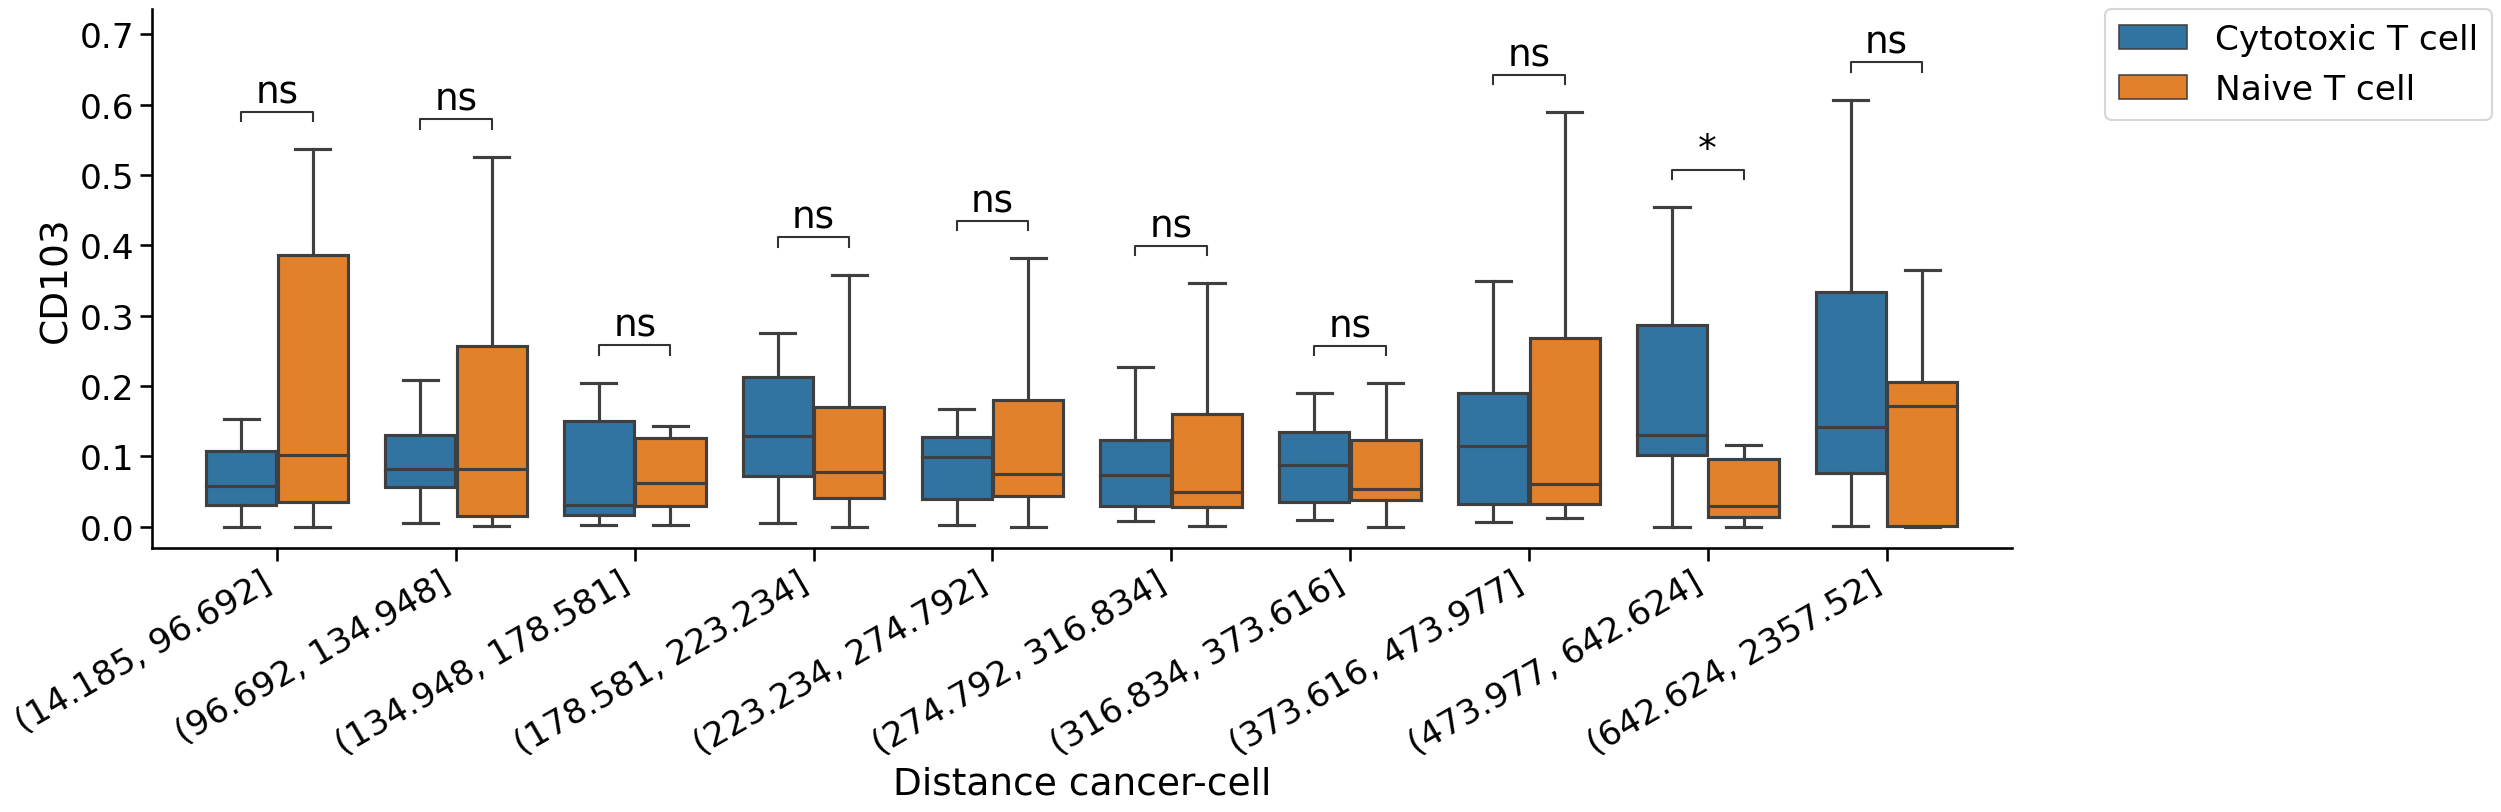

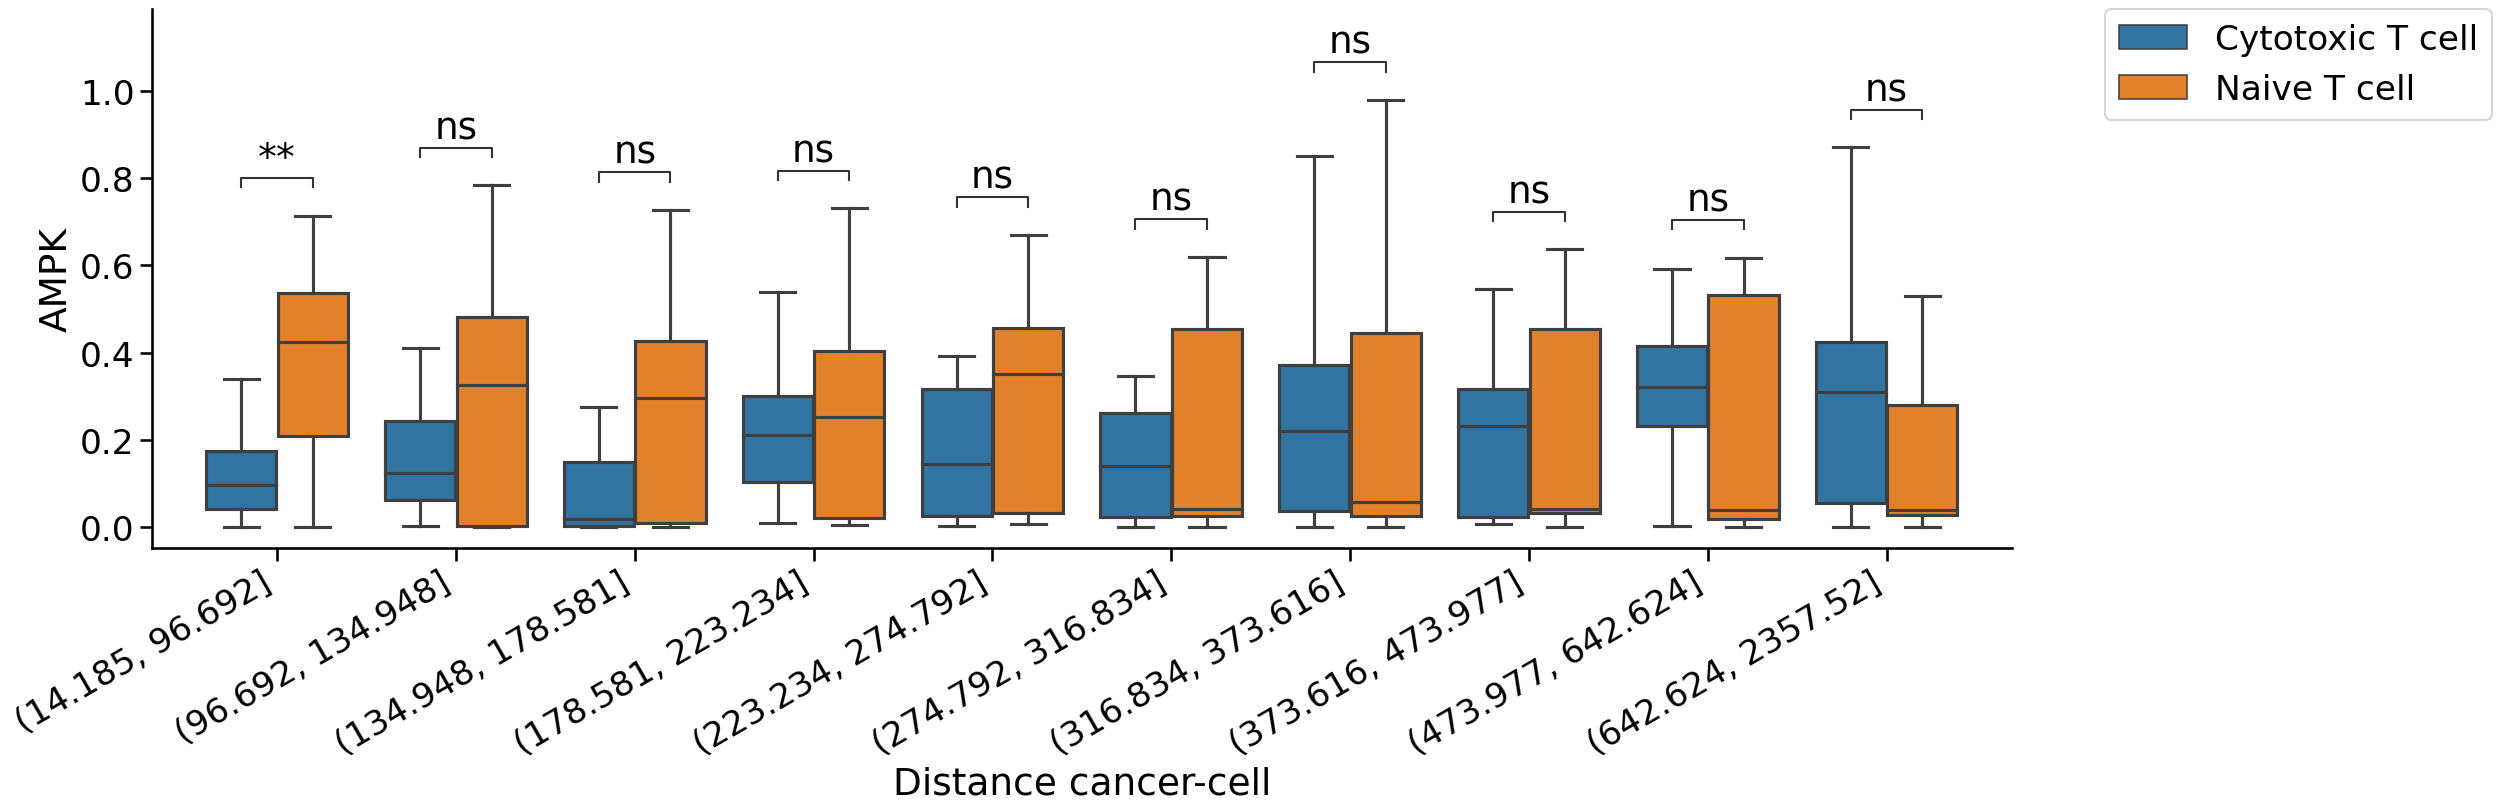

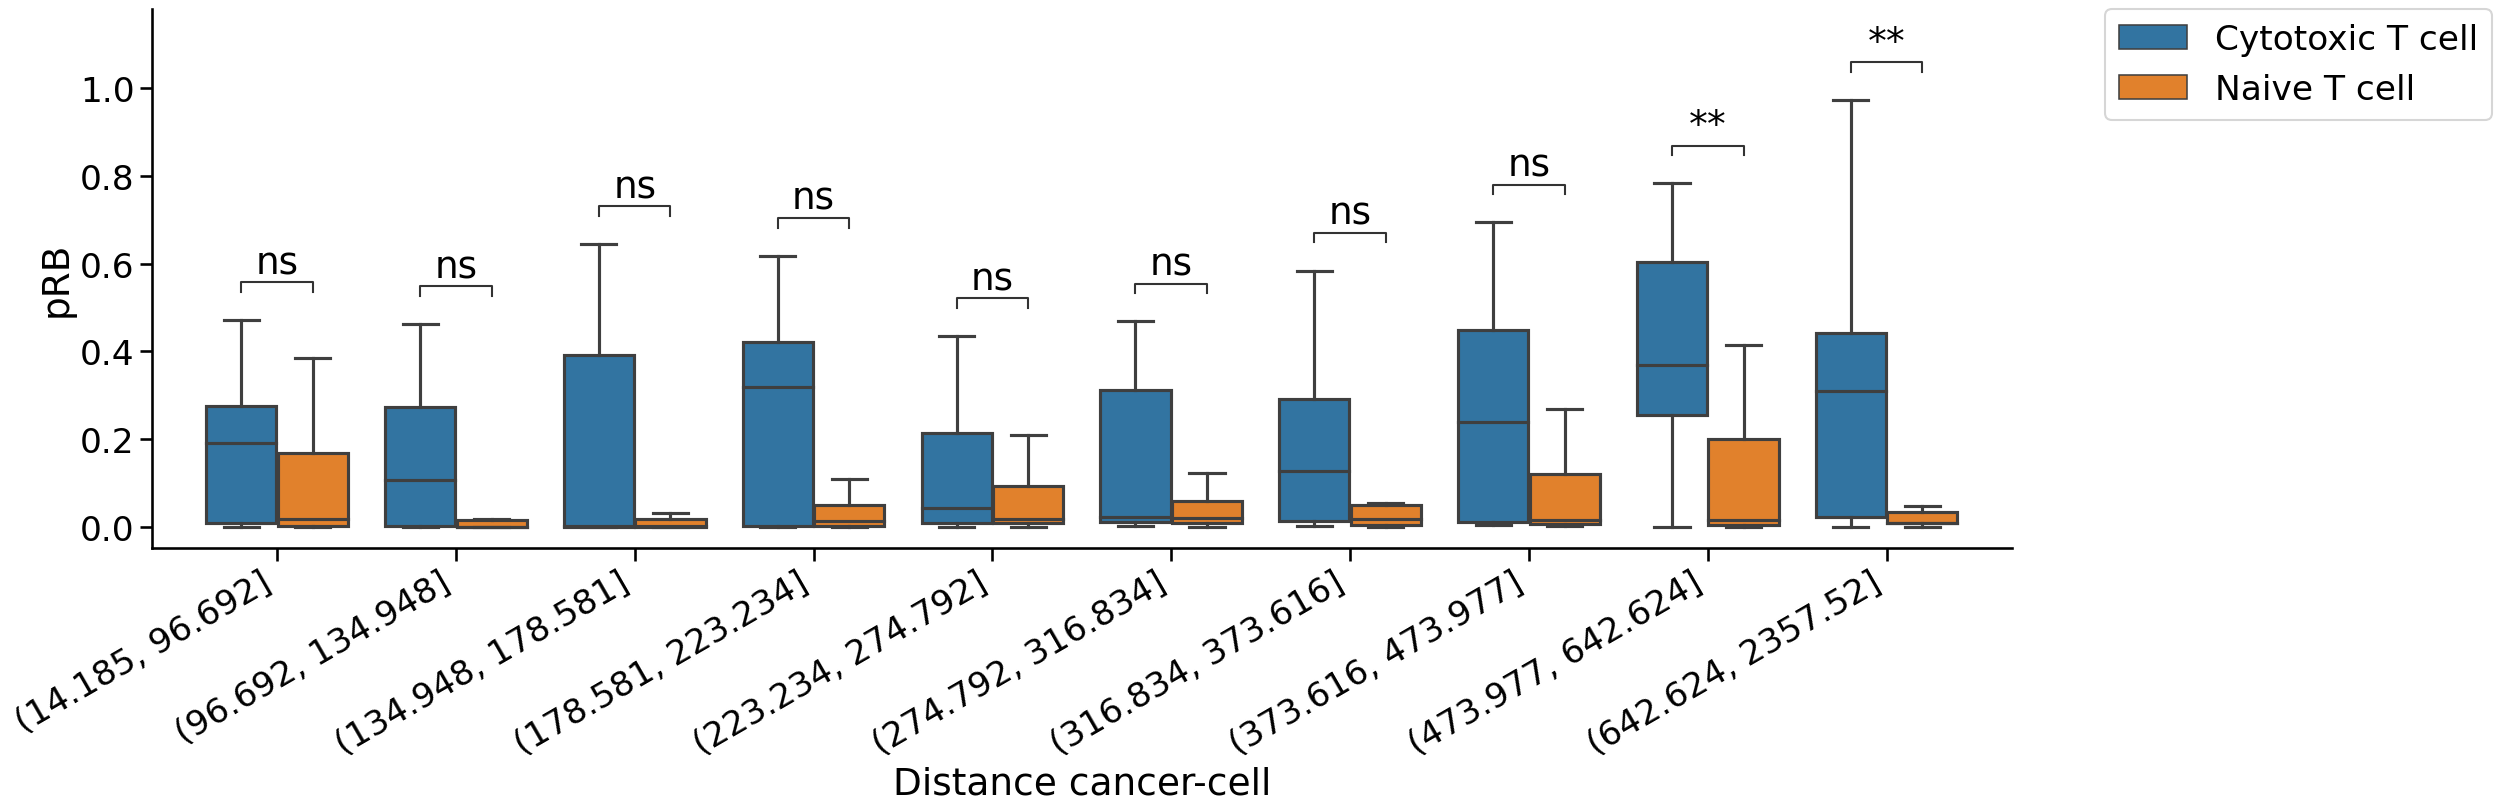

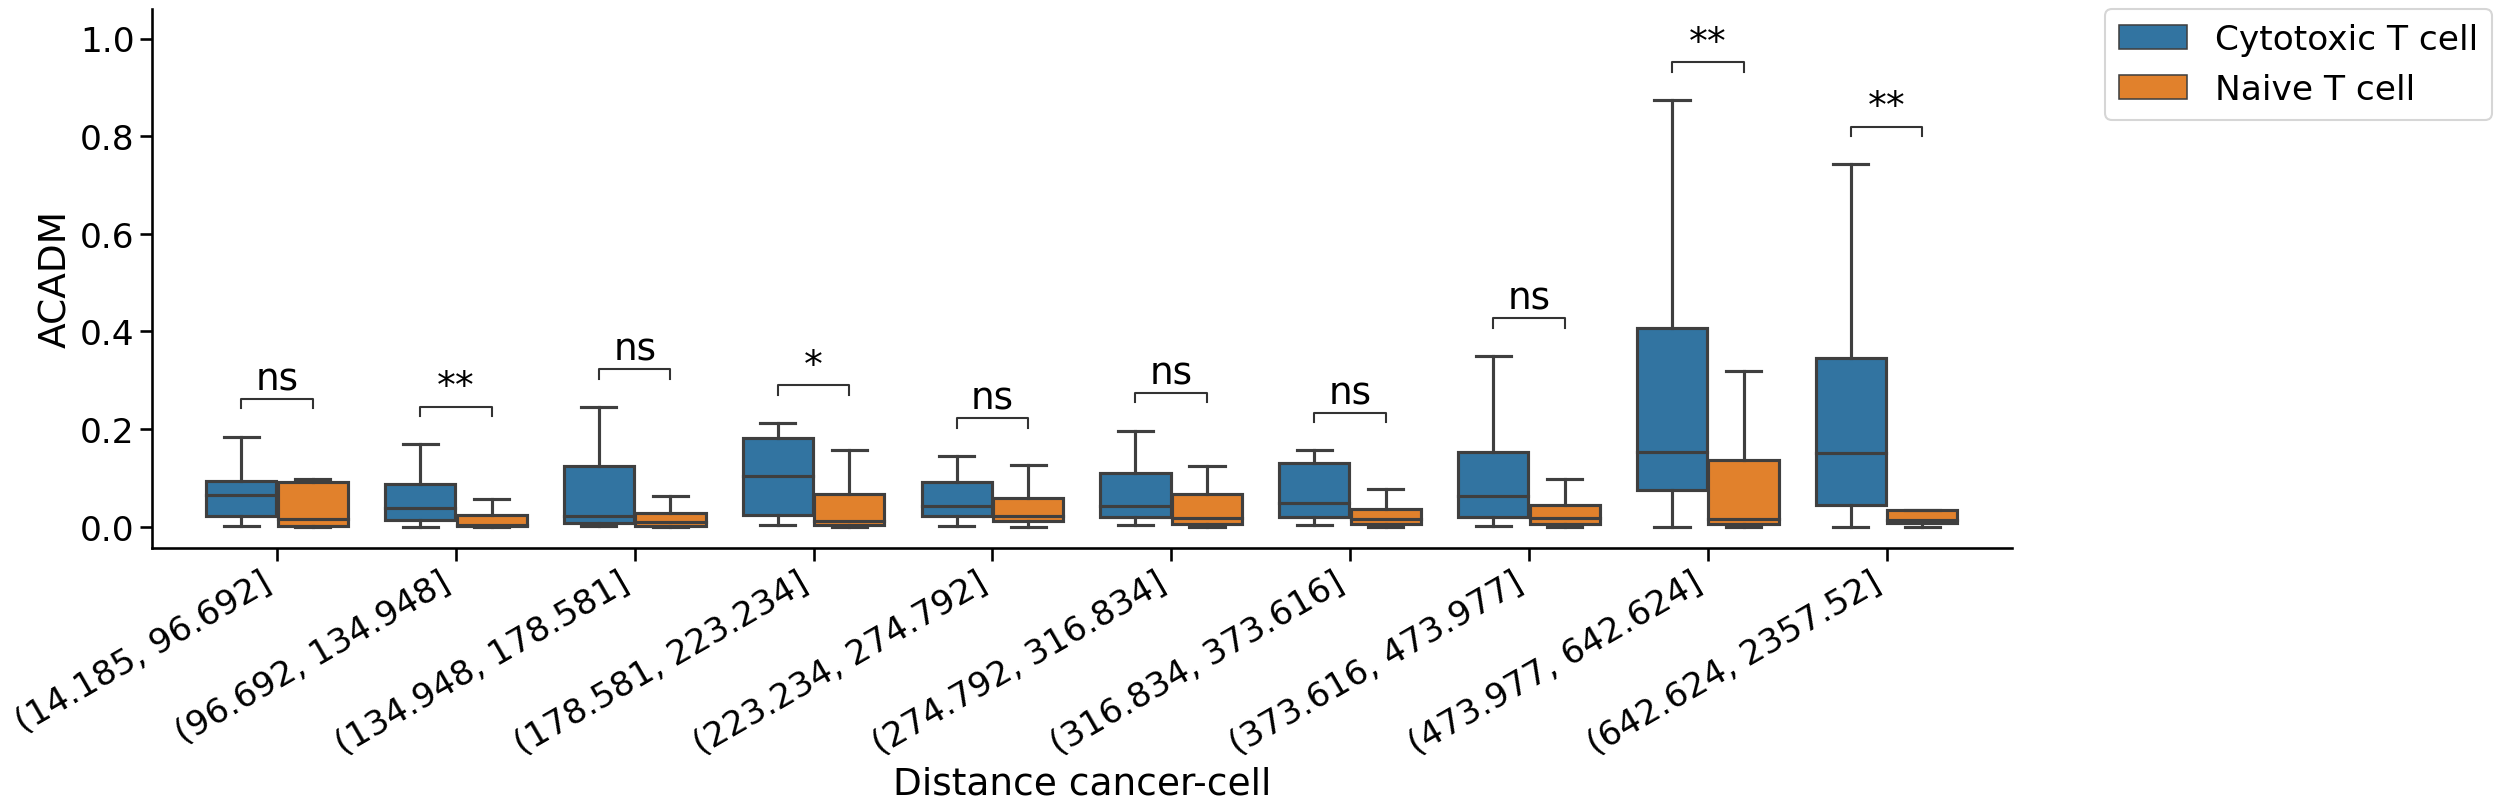

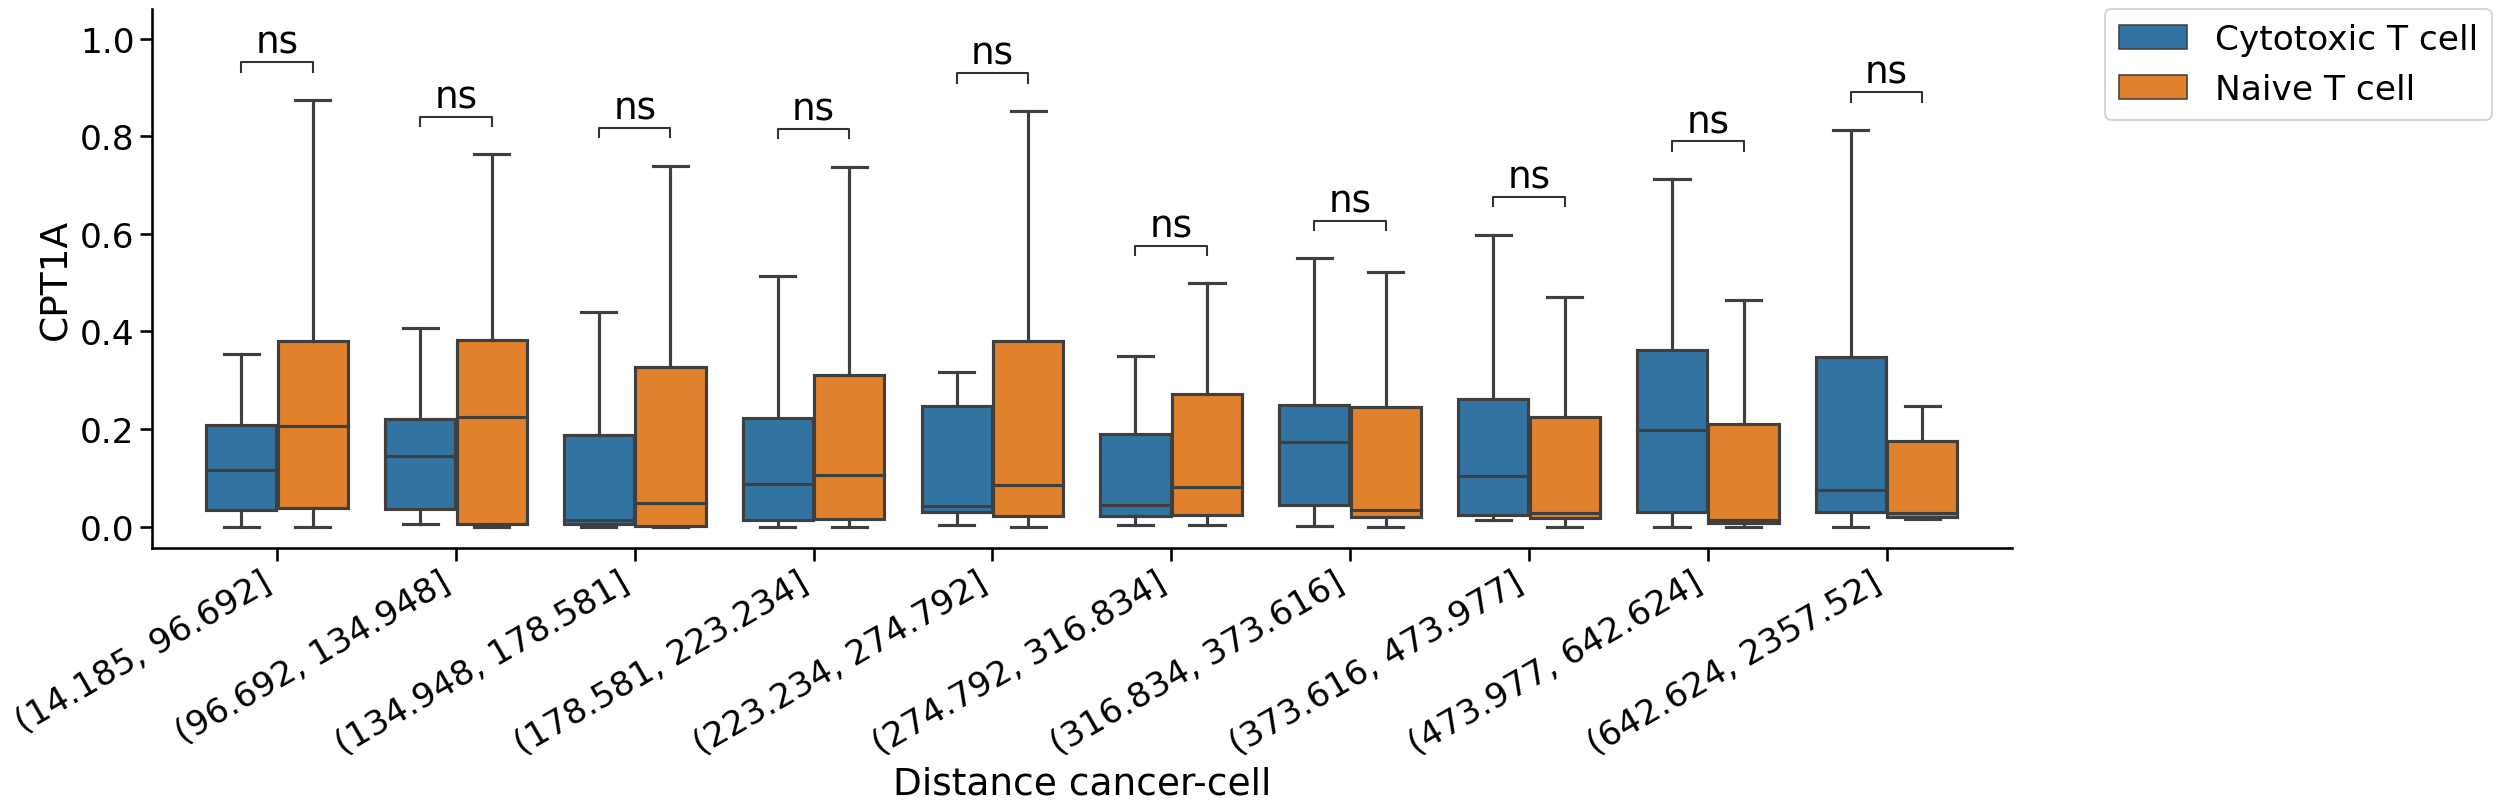

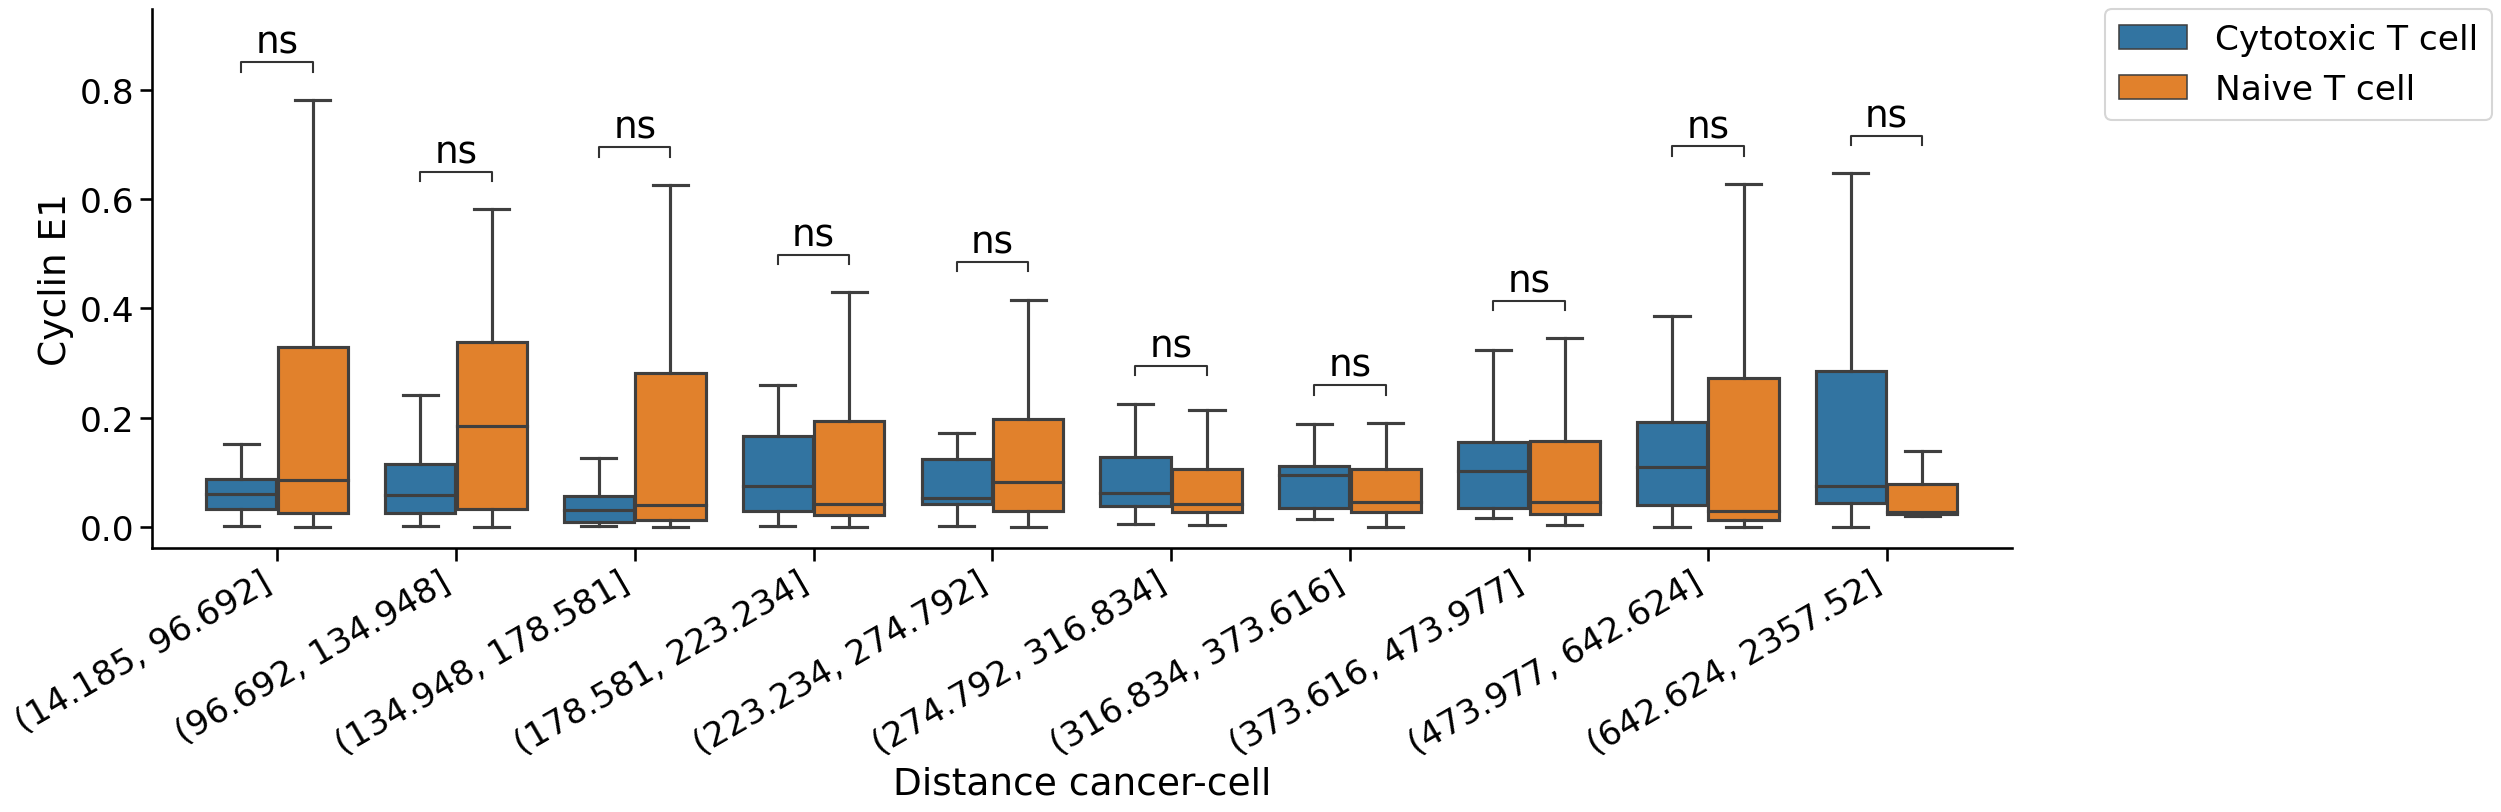

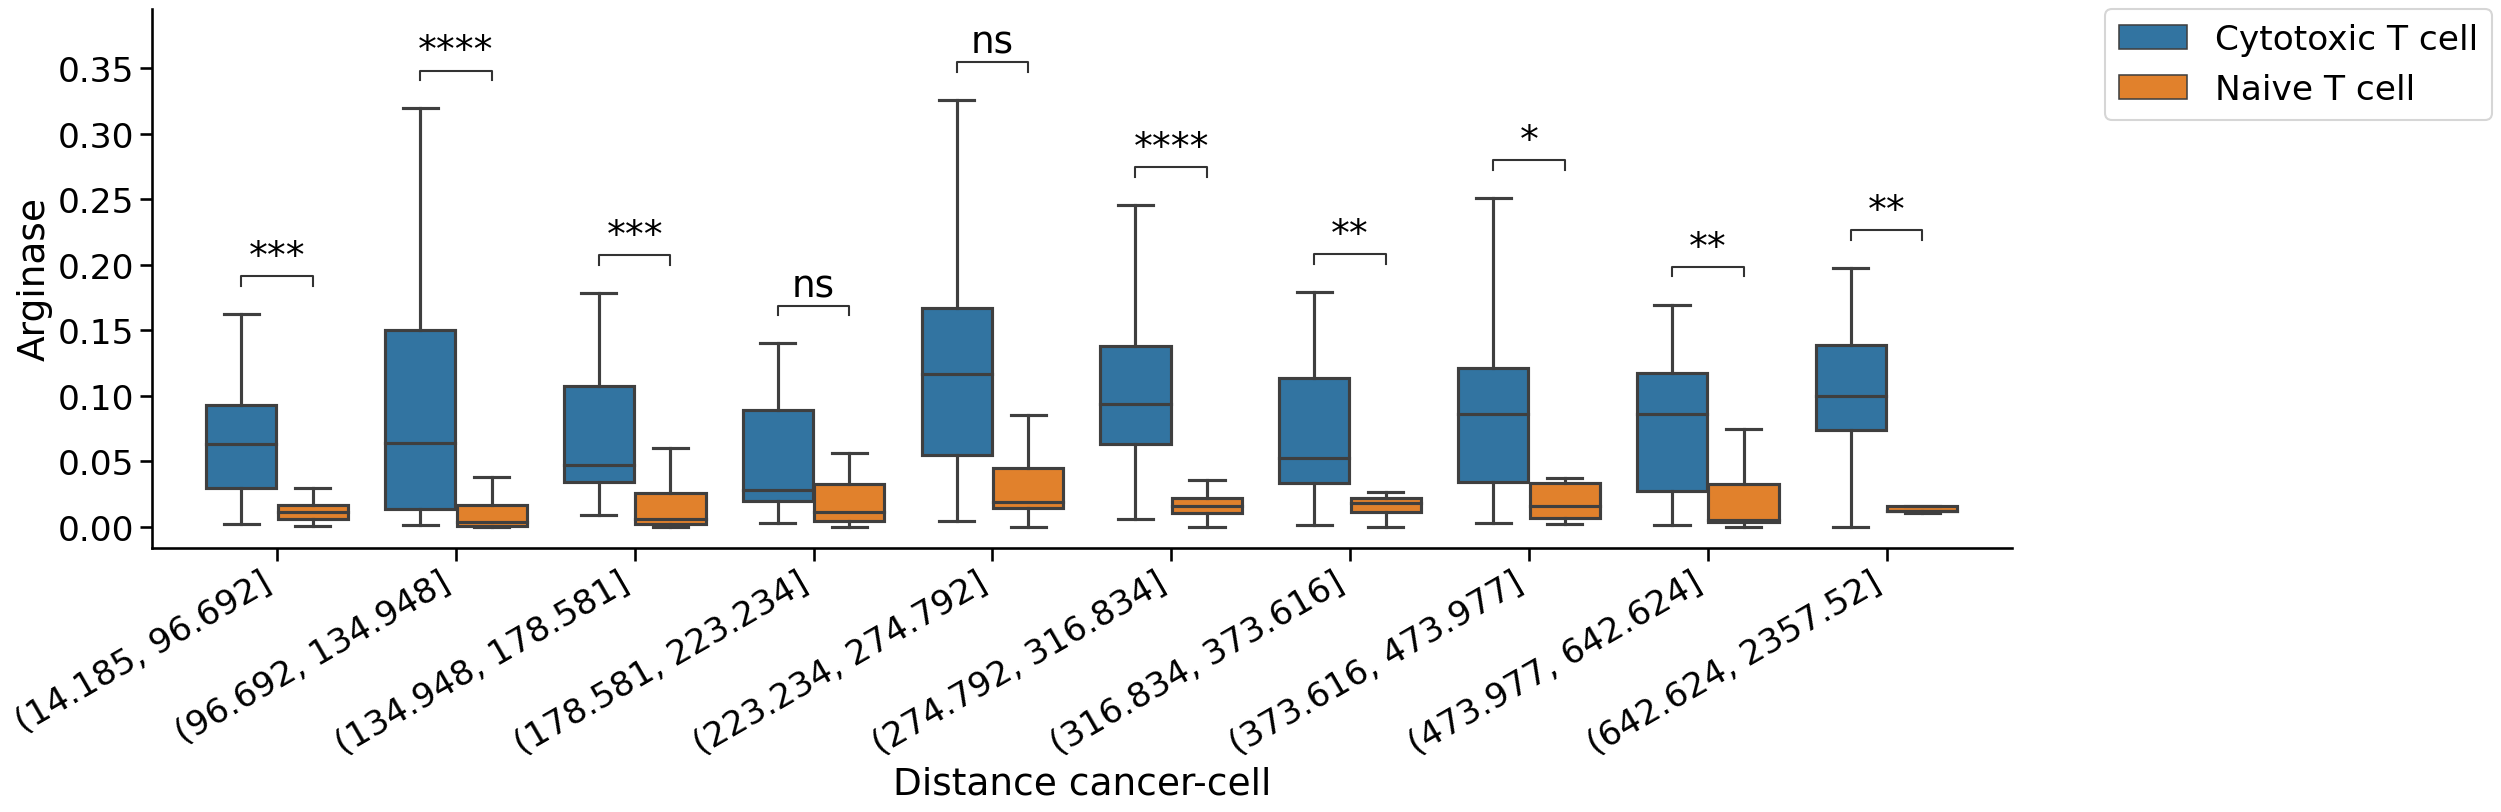

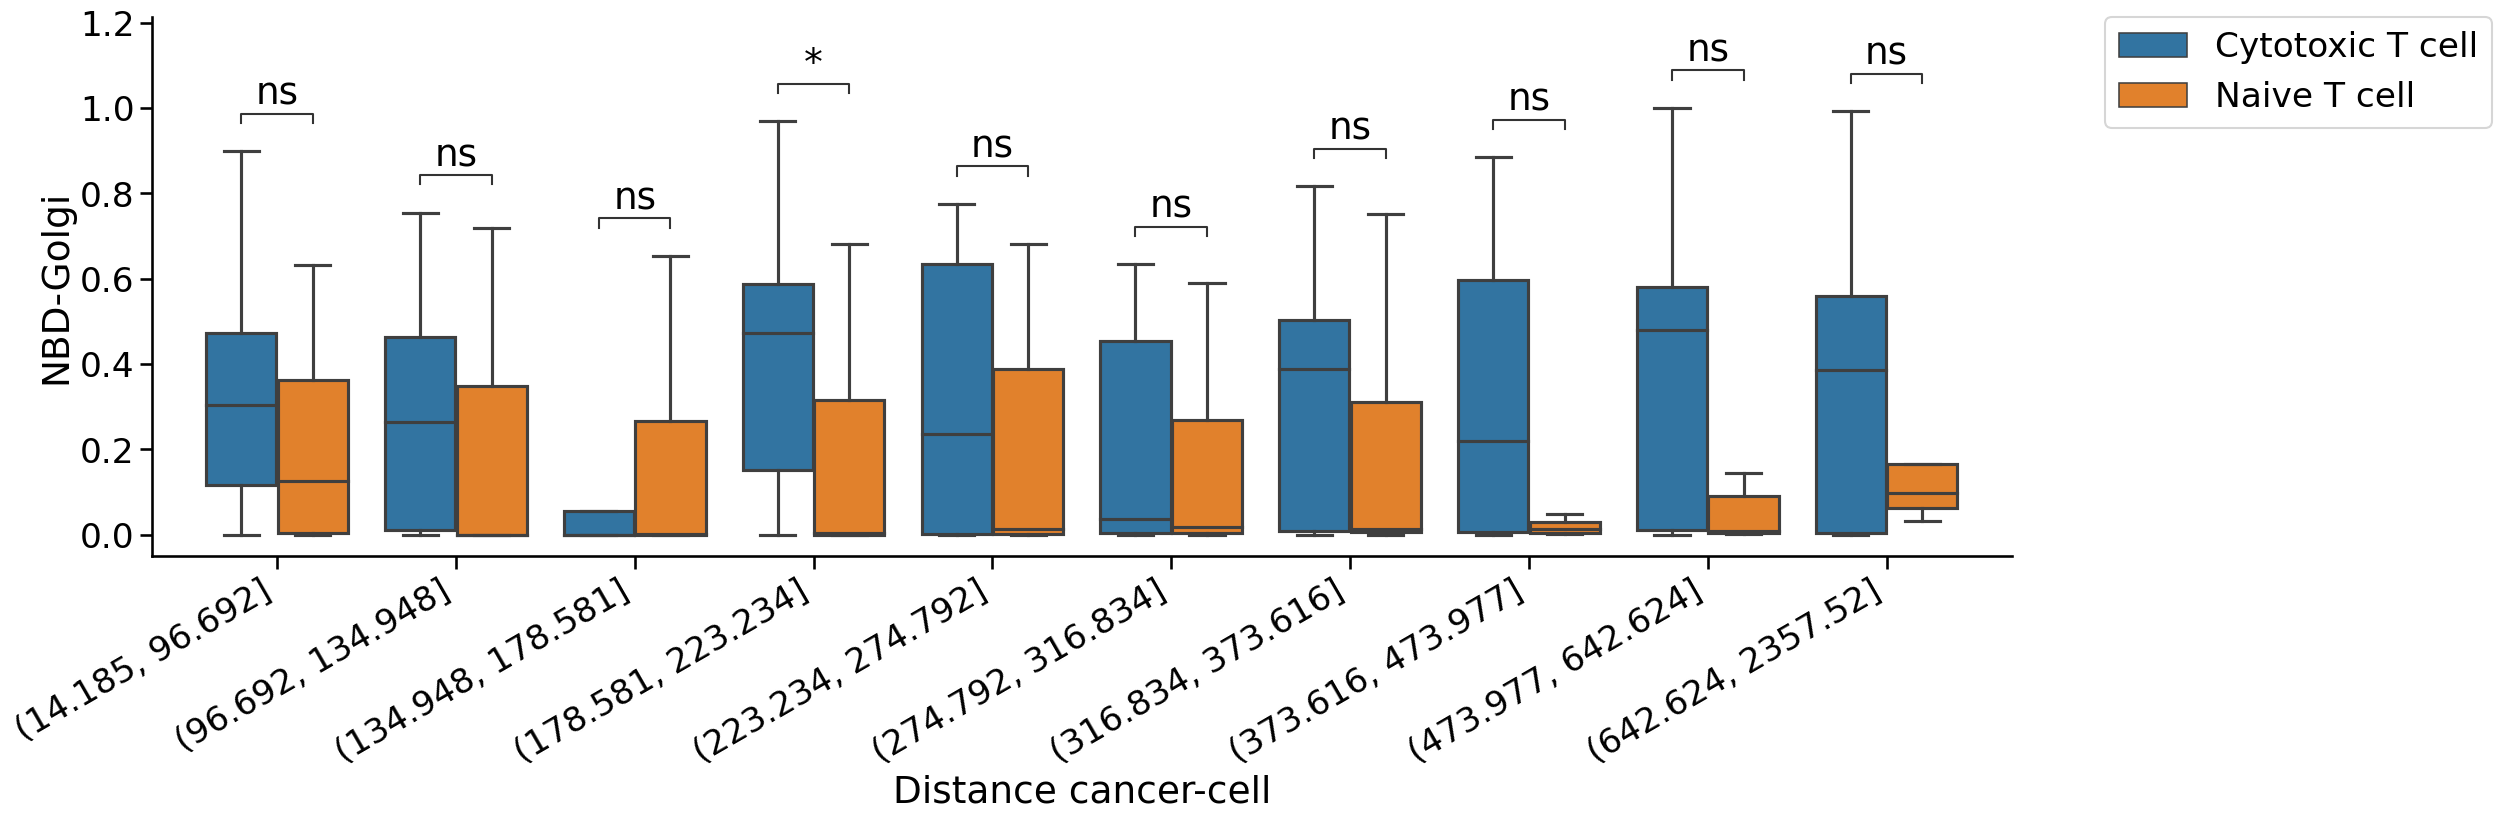

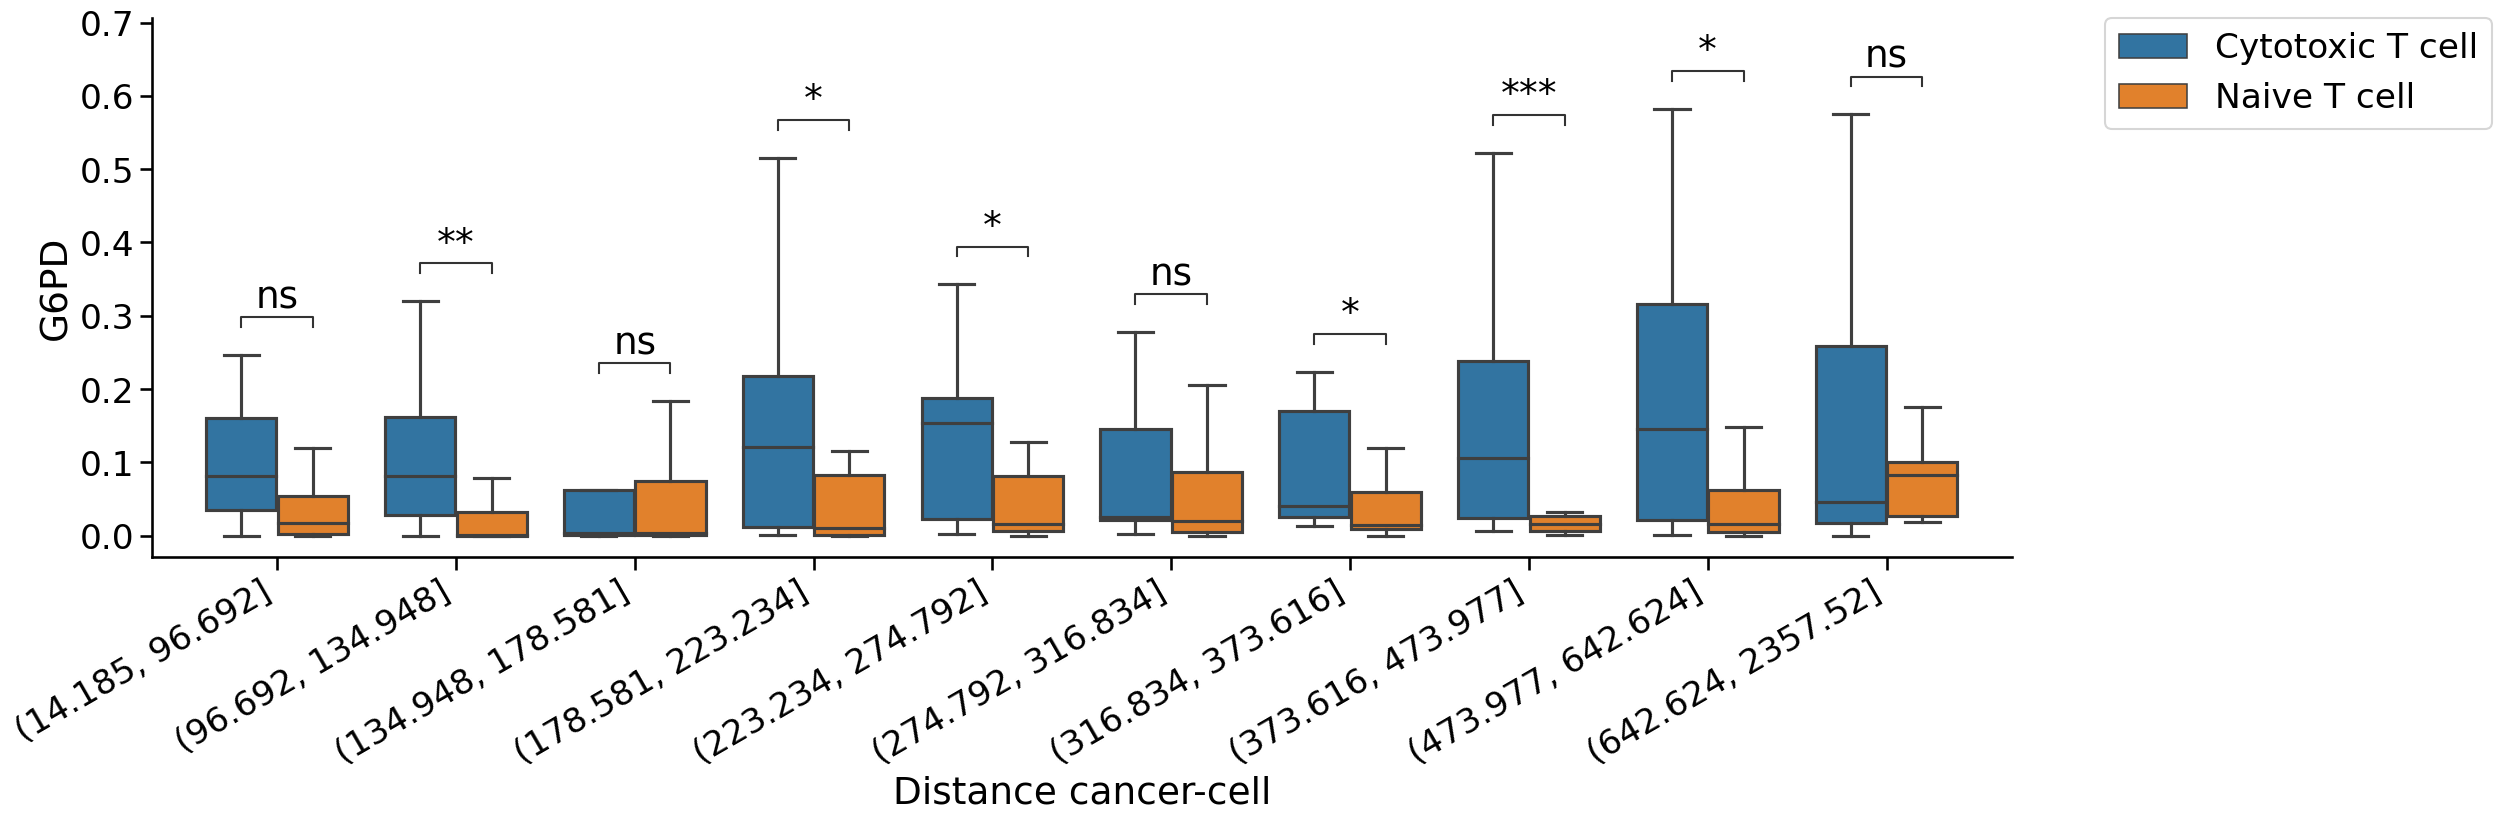

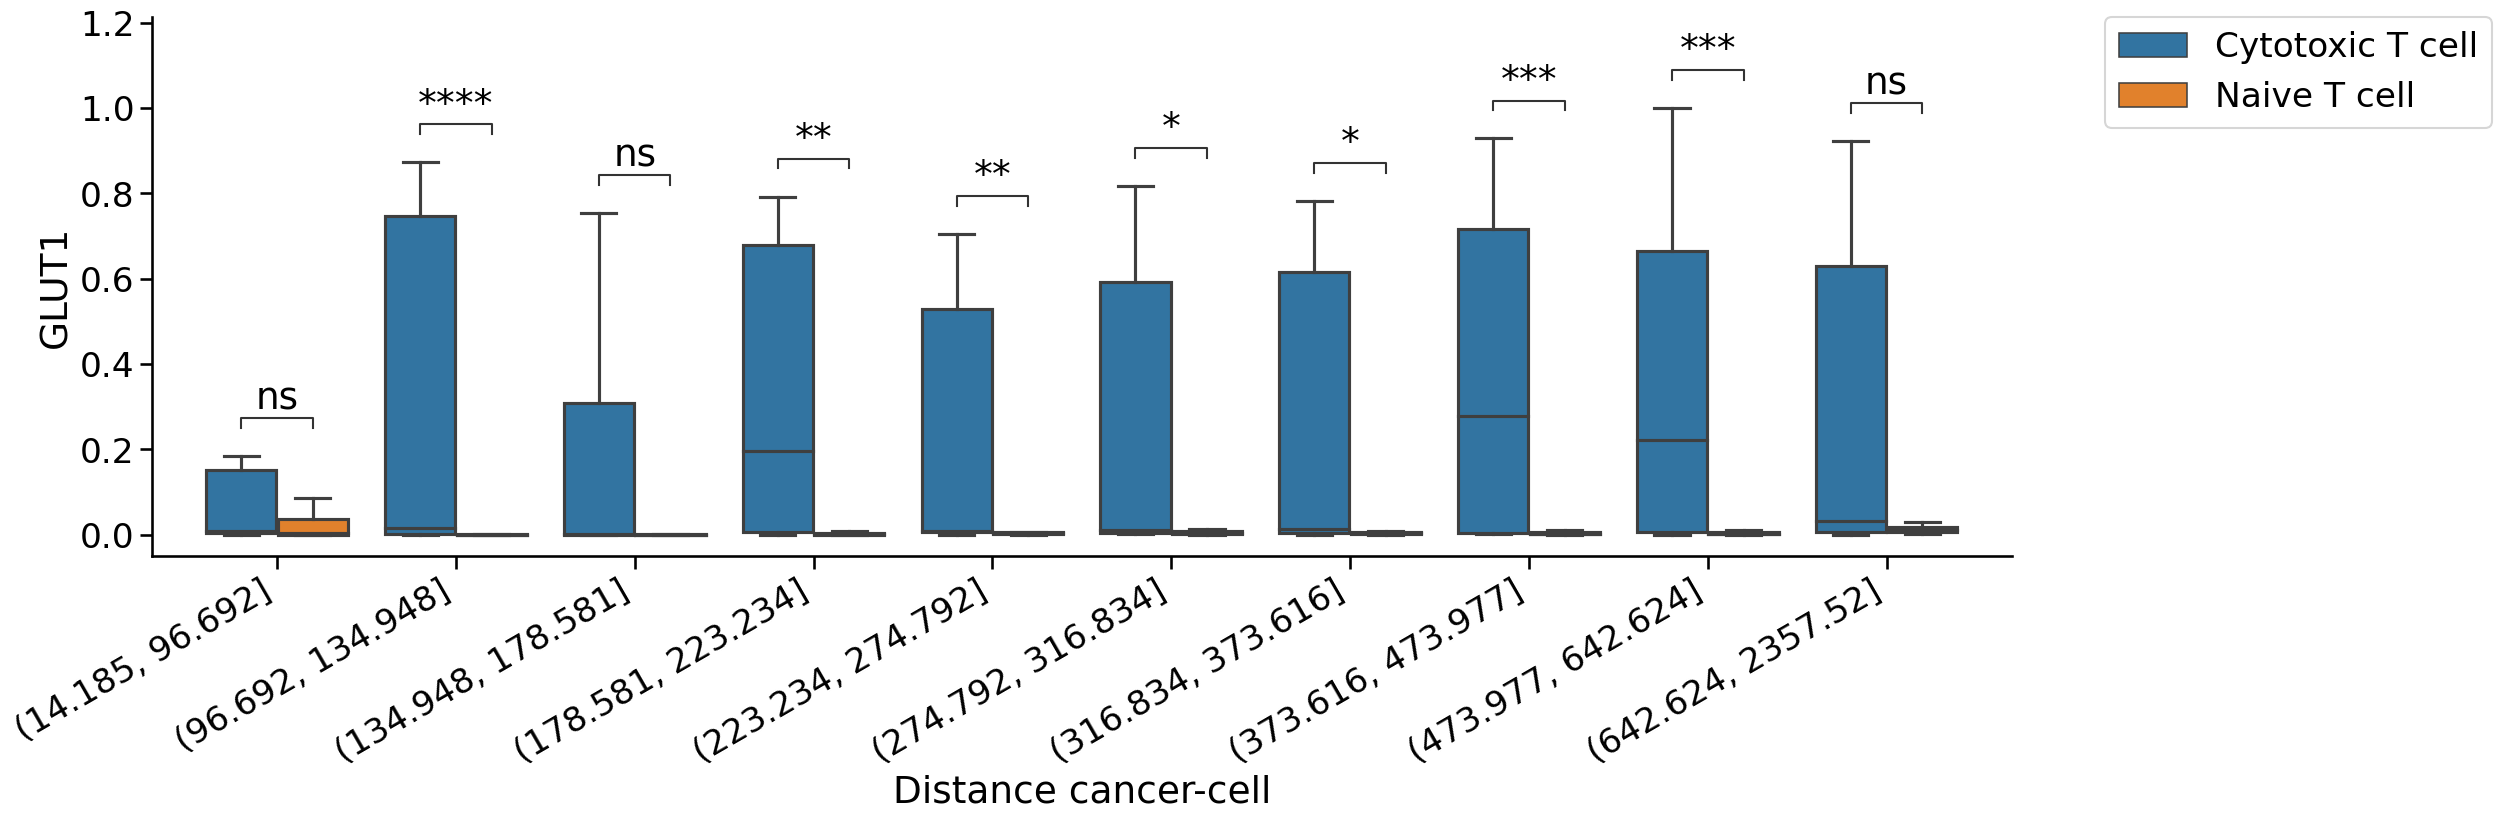

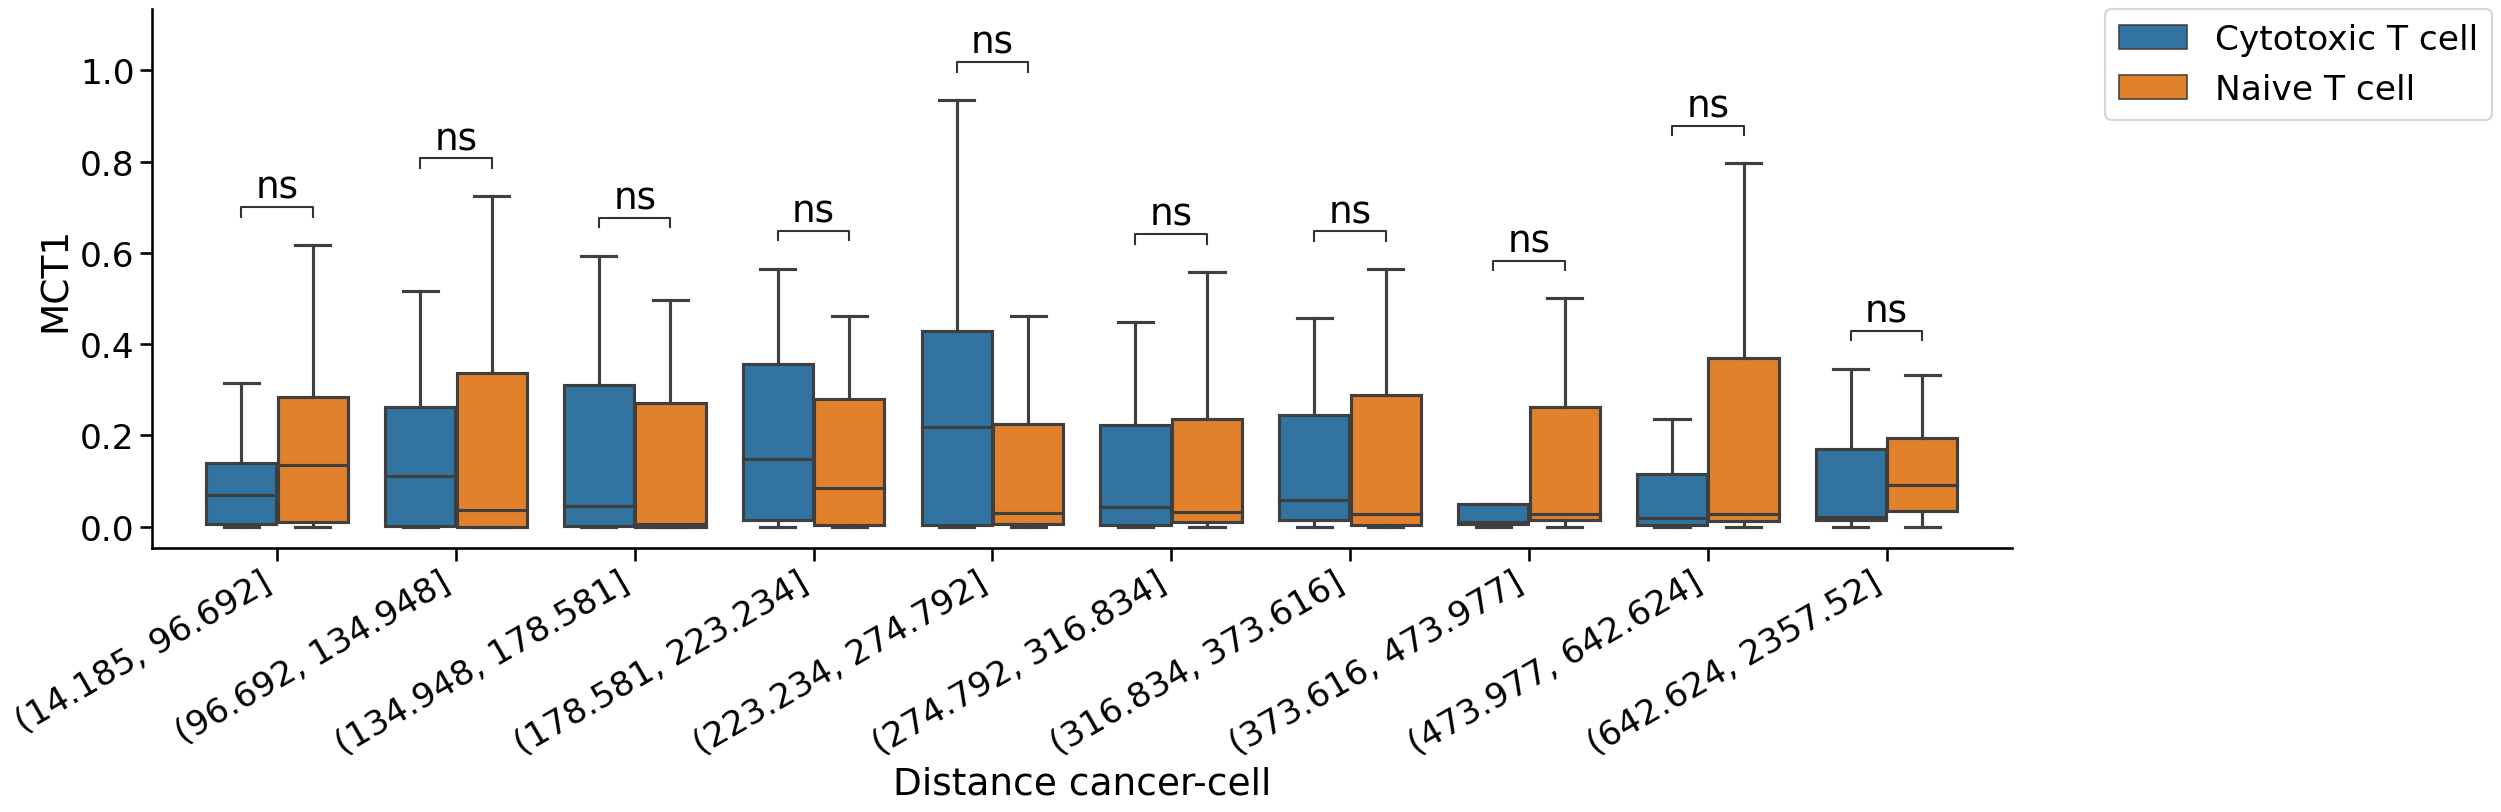

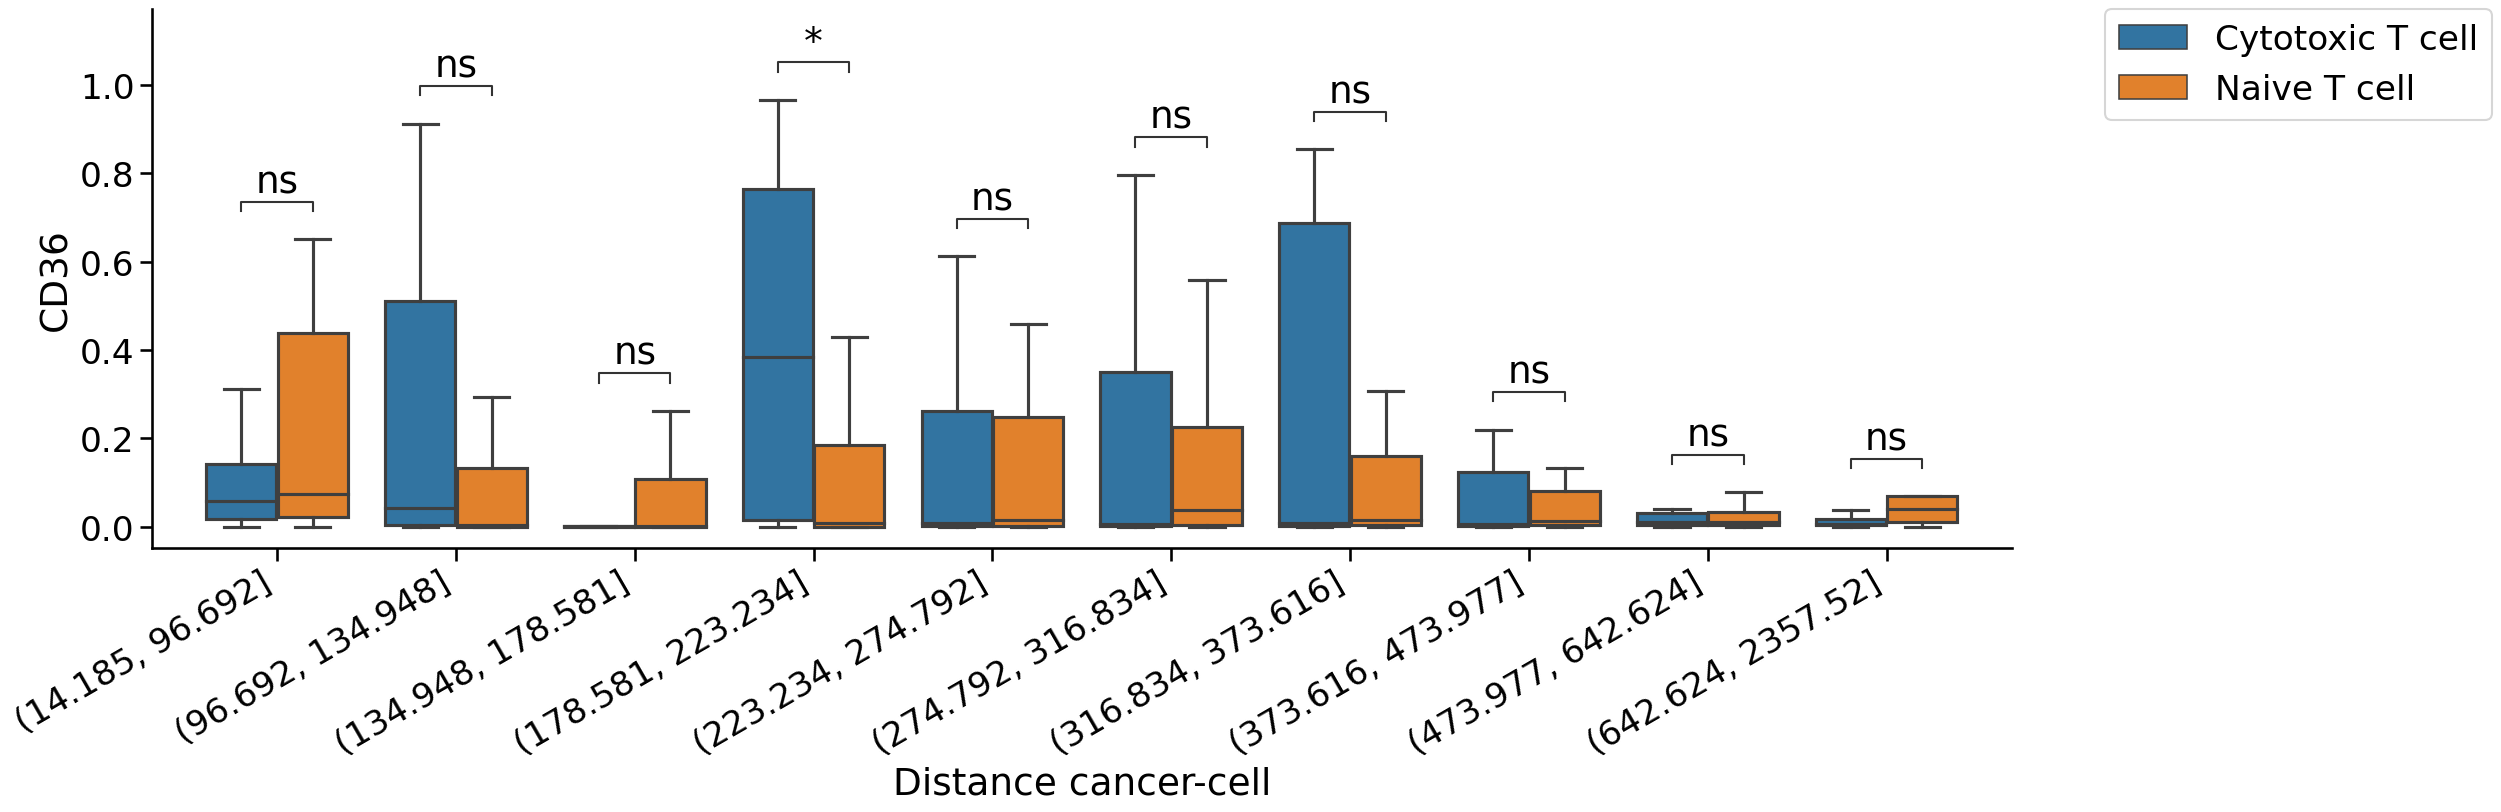

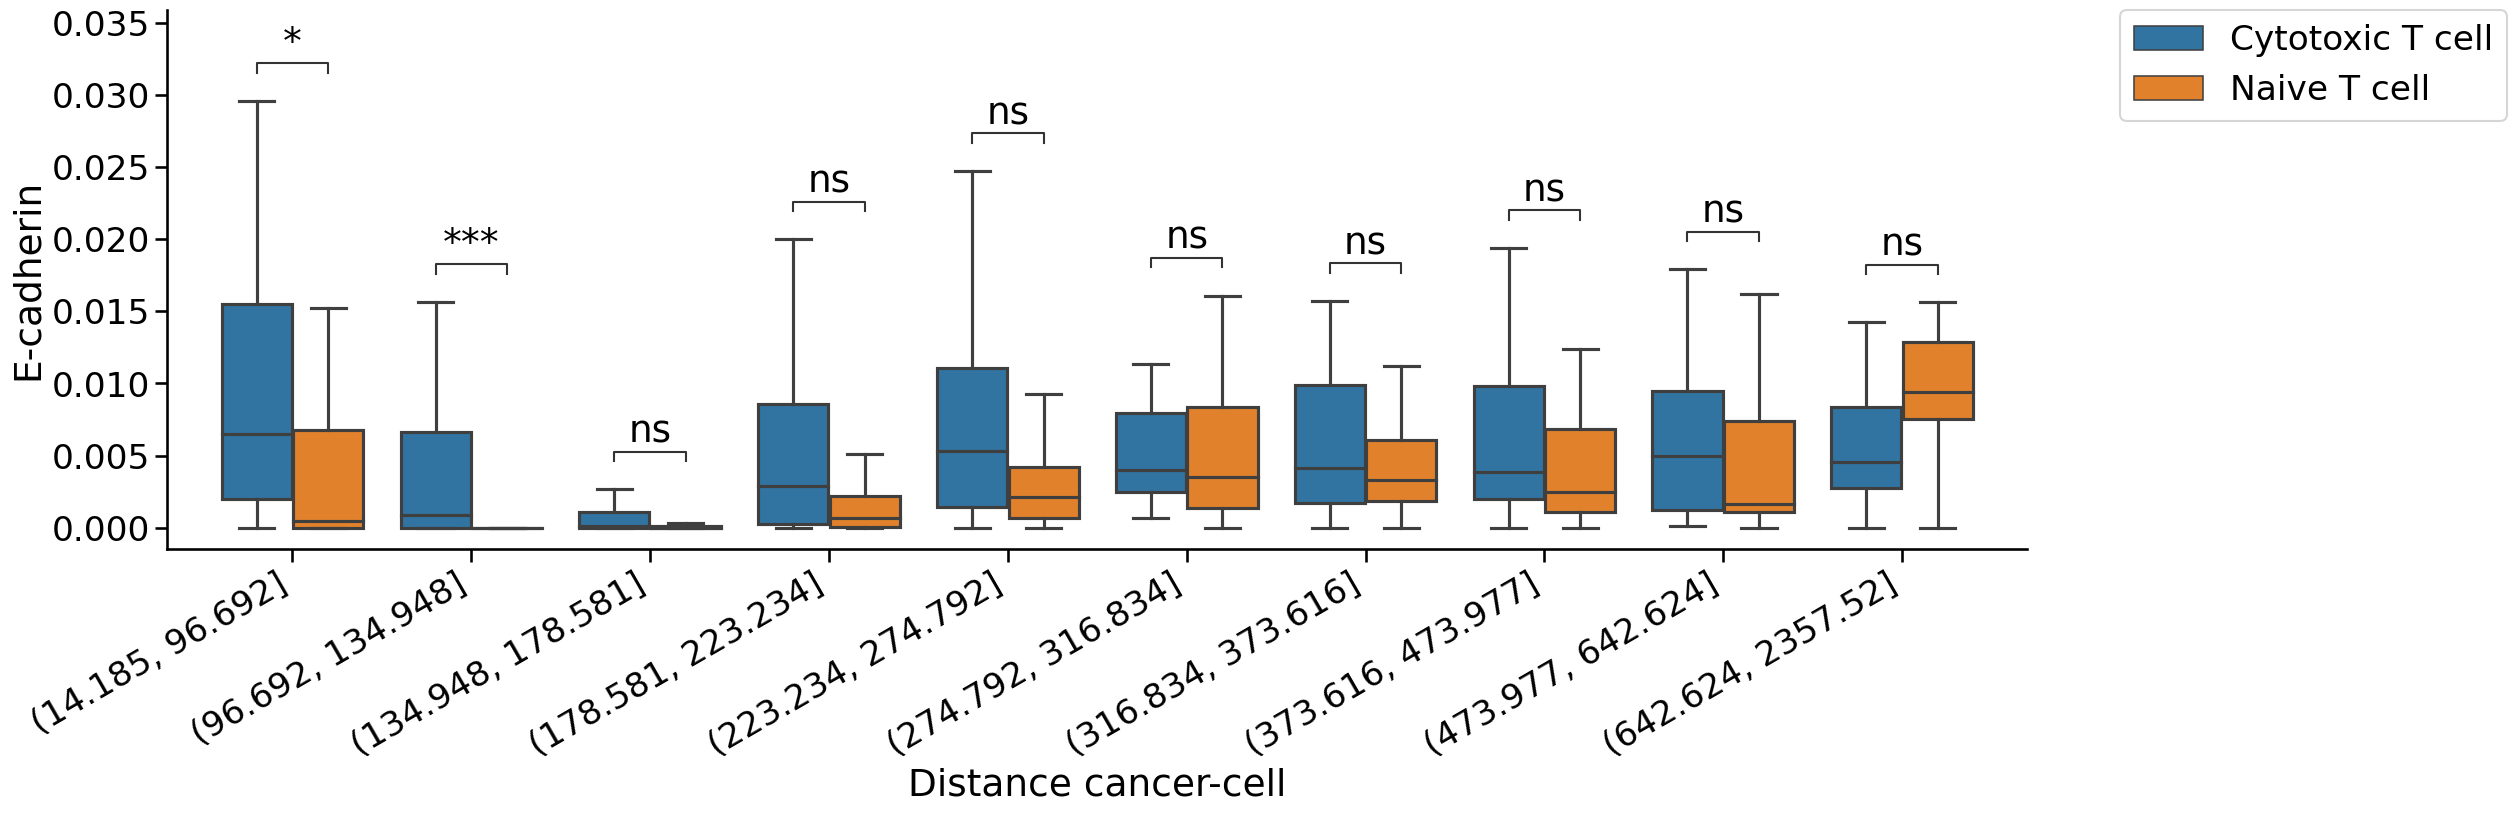

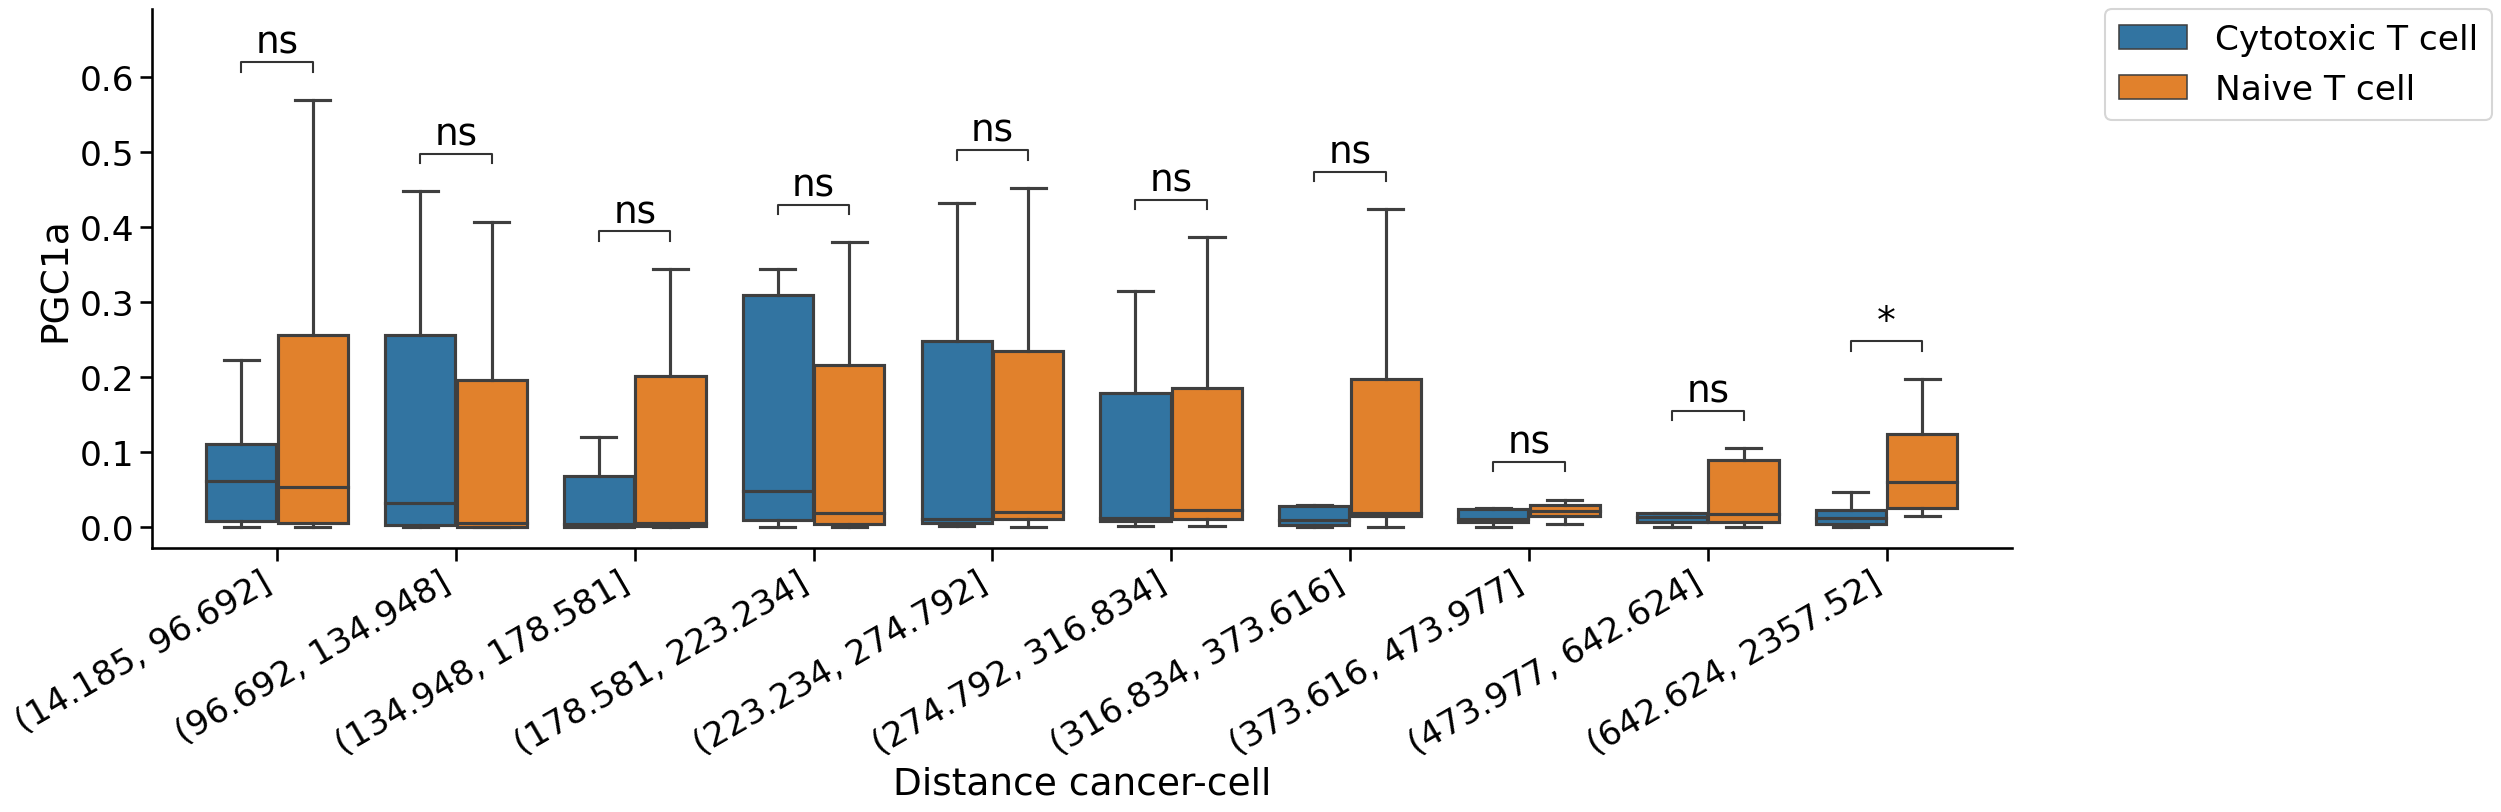

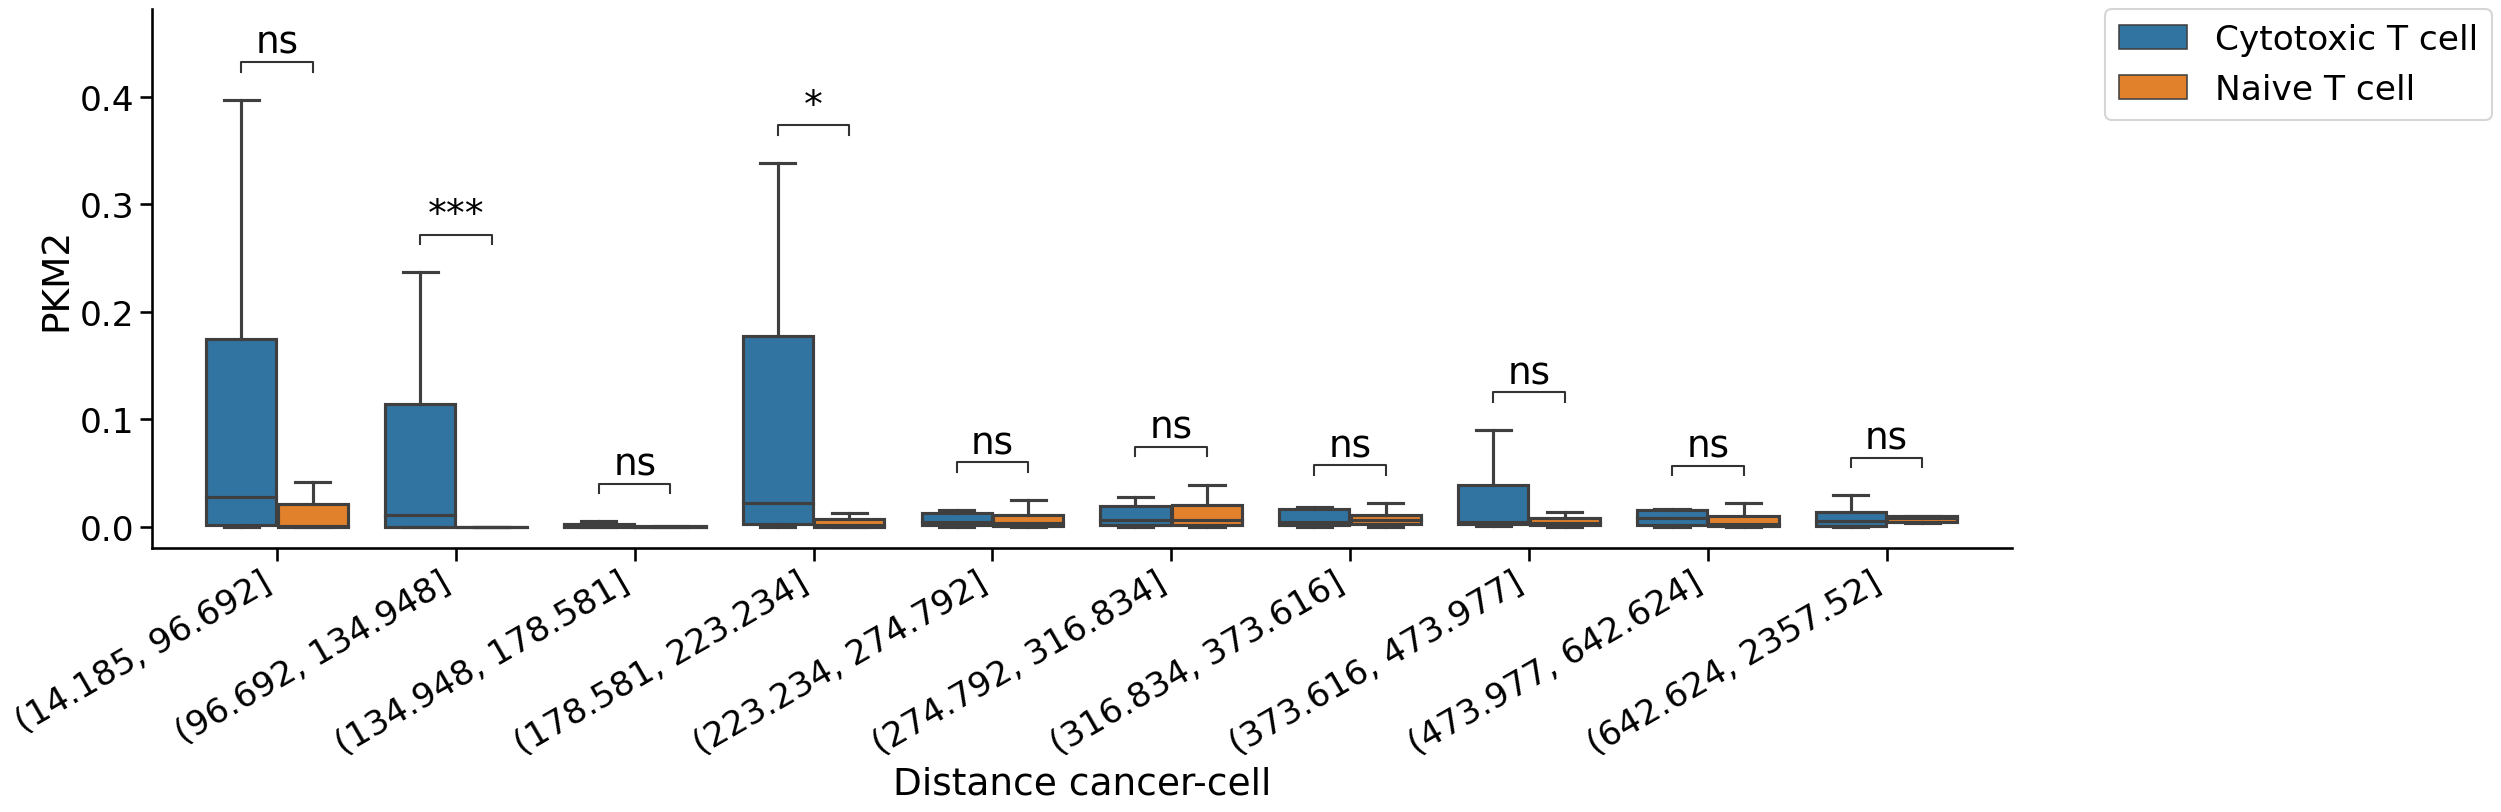

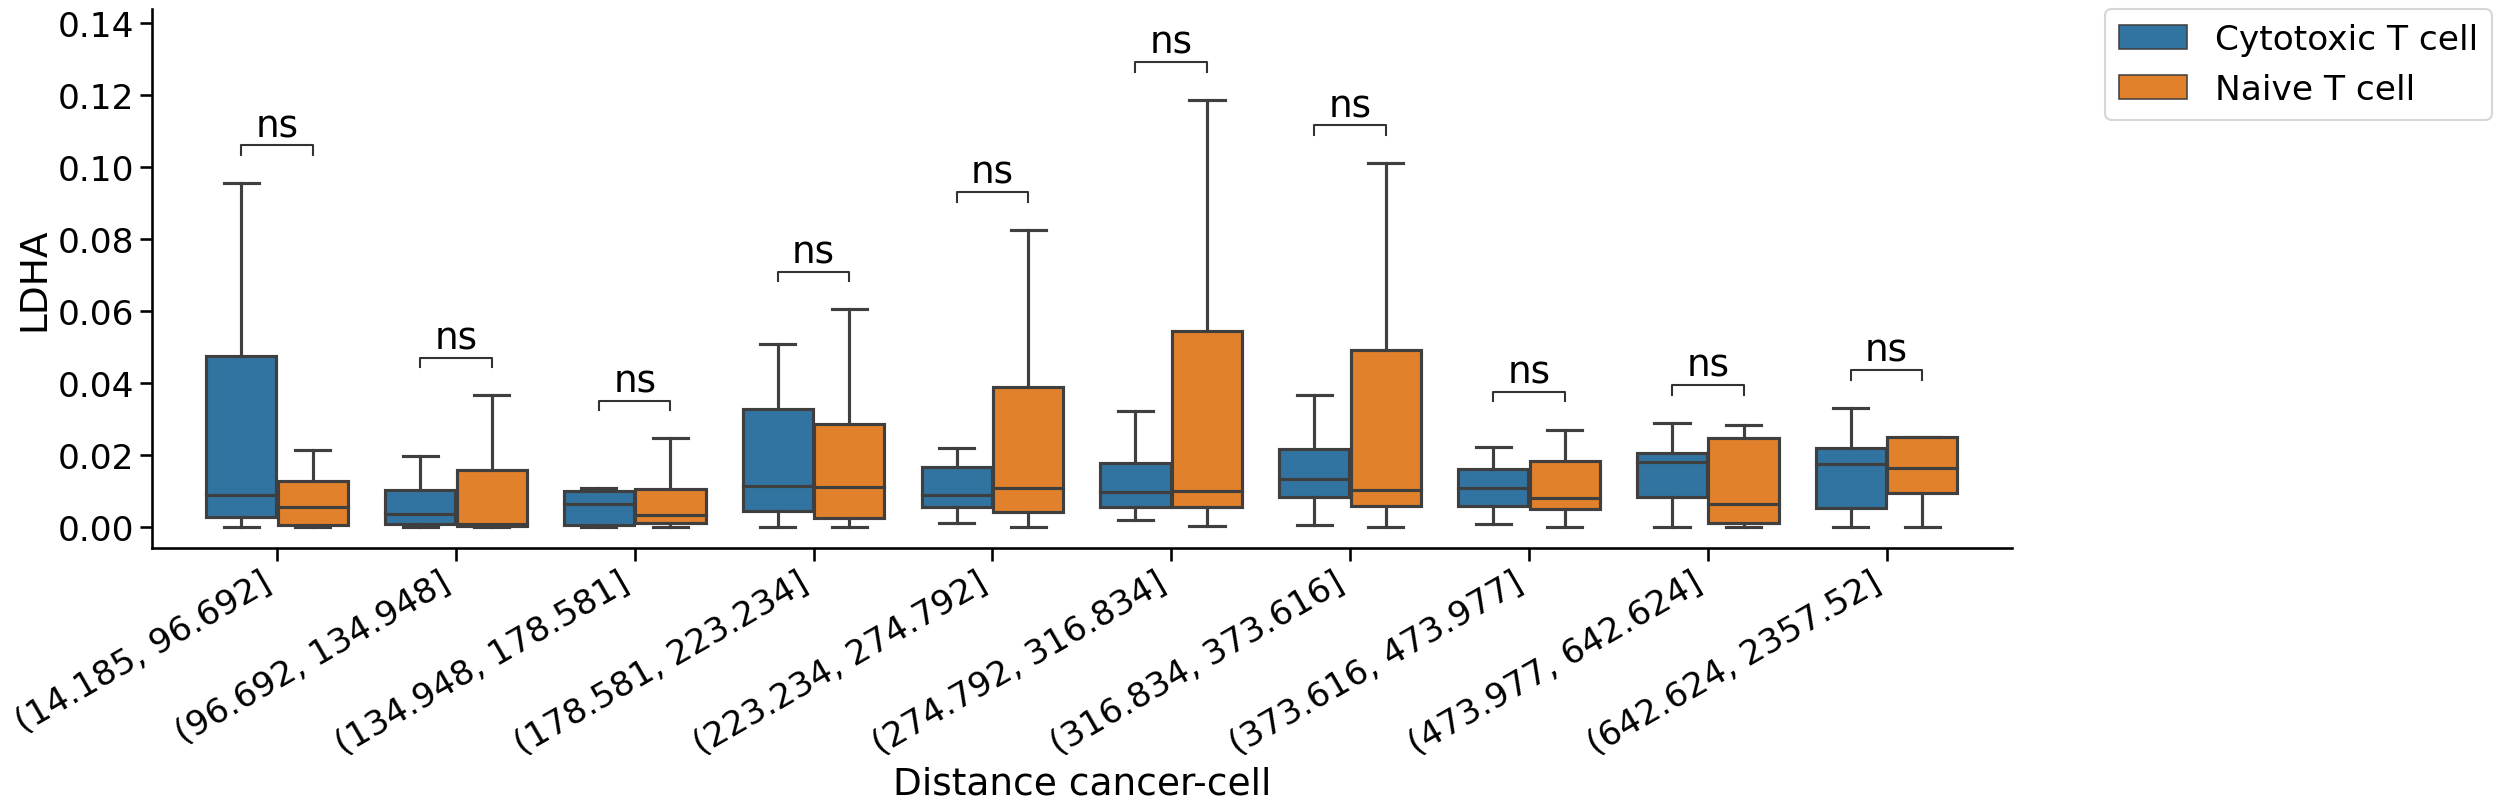

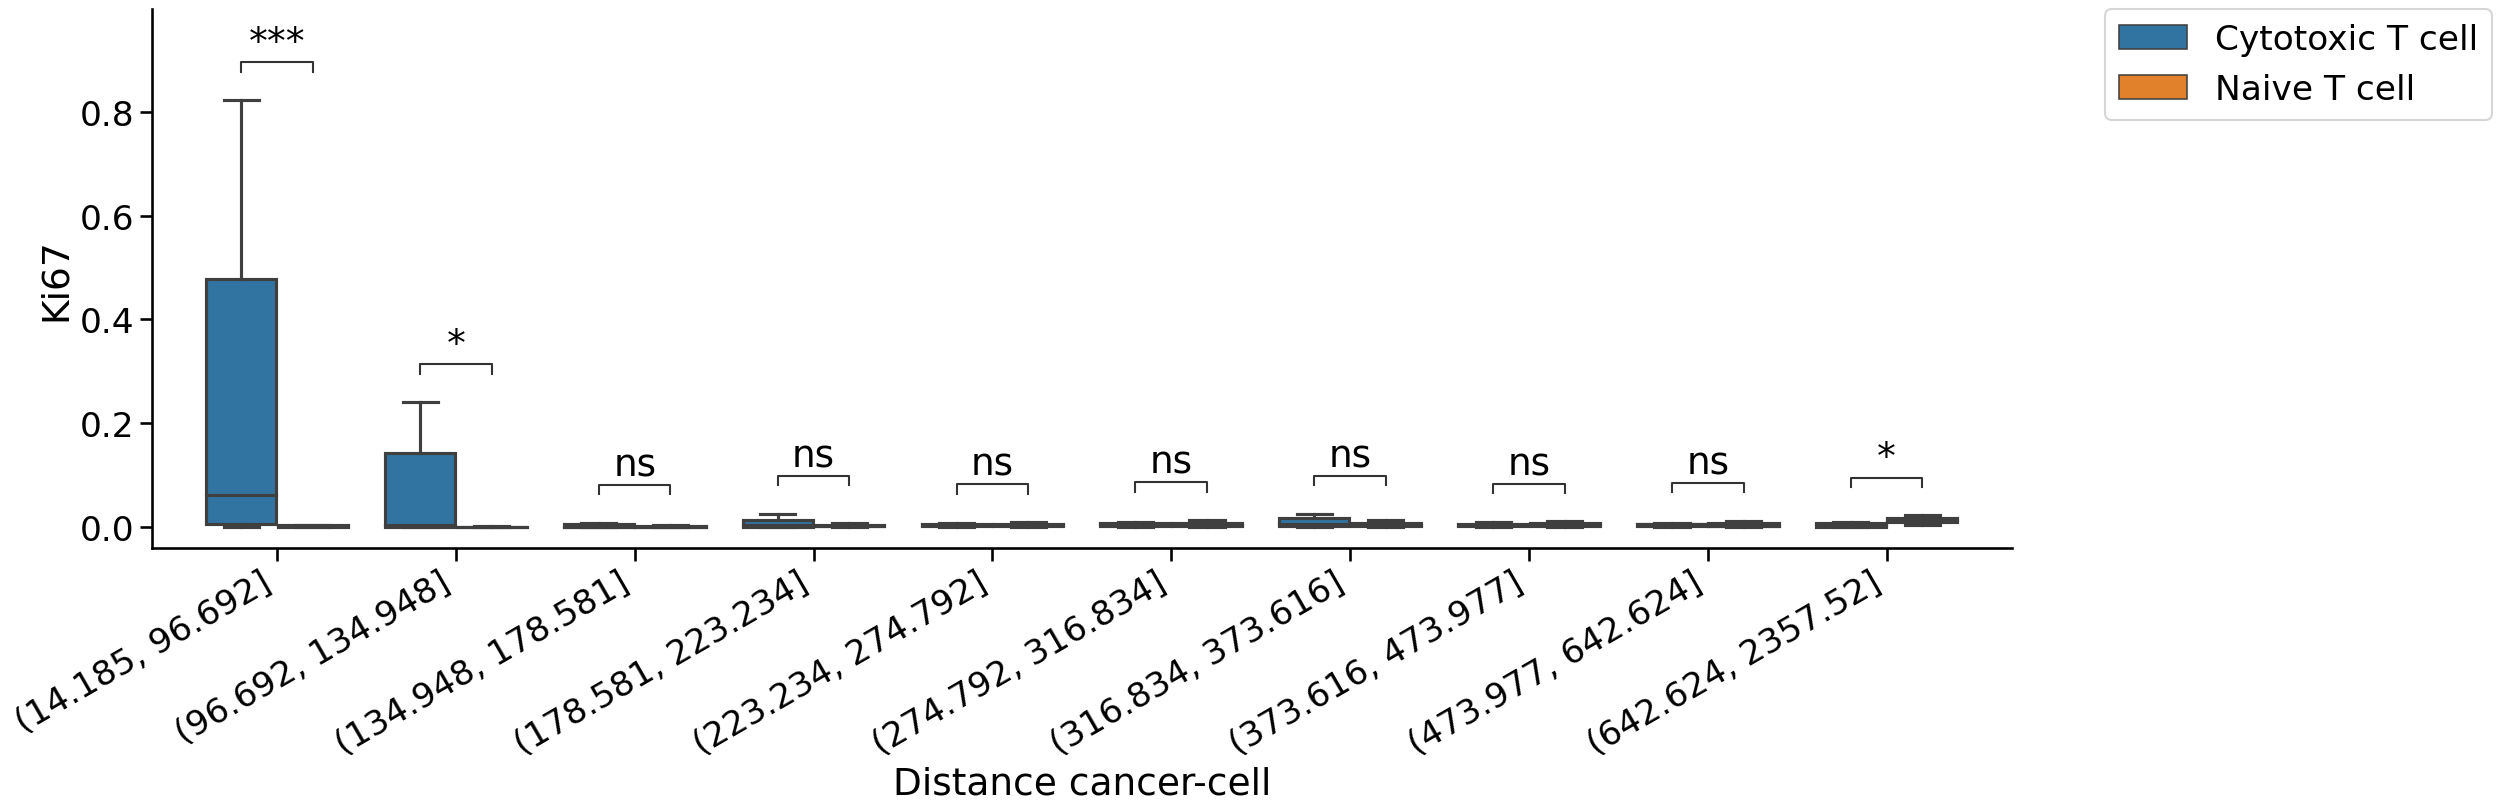

In [97]:
# Boxplot per cell
save_path = r"Y:\coskun-undergrads\Mingshuang\Thomas\CoCulture\results\T_cell_comparison"
for i in df_all_T_corrected:
    print(i)
    if (i == 'Cell_type_name') | (i == 'Distance cancer-cell') | (i == 'Distance to cancer-cell') | (i == 'Distance cancer-cell bucket'):
        continue
    A = df_all_T_corrected[[i, 'Cell_type_name',"Distance cancer-cell"]]
    plotting = {
        "data": A,
        "x": "Distance cancer-cell",
        "y": i,
        "hue": "Cell_type_name"
    }
    full_path = os.path.join(save_path, f'T_{i}')

    plot(plotting, full_path)
    sns.despine()

In [74]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

all_ratio_df = pd.DataFrame(columns = ['0', '1', '2', '3', '4','marker'])
all_p_val_df = pd.DataFrame(columns = ['0', '1', '2', '3', '4','marker'])
for i in df_all_cancer_corrected:
    
    if (i == 'neighbor') | (i == 'Distance T-cell') | (i == 'Distance to T-cell') | (i == 'Distance T-cell bucket'):
        continue
#     print(i)
    df = df_all_cancer_corrected[[i, 'neighbor',"Distance T-cell bucket"]]
    groups = df.groupby(['Distance T-cell bucket'])


    medians_cytotoxic = []
    medians_naive = []
    ratio = []
    p_values = []
    distances = []


    for (distance), data in groups:
        cytotoxic_data = data[data['neighbor'] == 'Cytotoxic T cell'][i]
        naive_data = data[data['neighbor'] == 'Naive T cell'][i]
        stat, p_value = mannwhitneyu(cytotoxic_data, naive_data)
        medians_cytotoxic.append(cytotoxic_data.median() + 0.01)
        medians_naive.append(naive_data.median() + 0.01)
        ratio.append((cytotoxic_data.median() + 0.01)/(naive_data.median() + 0.01))
        p_values.append(p_value)
        distances.append(distance)
    reject, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')
    ratio.append(i)
    corrected_p_values = corrected_p_values.tolist()
    corrected_p_values.append(i)
    
    all_ratio_df = all_ratio_df.append(pd.Series(ratio, index=all_ratio_df.columns), ignore_index=True)
    all_p_val_df = all_p_val_df.append(pd.Series(corrected_p_values, index=all_ratio_df.columns), ignore_index=True)

C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1594027950.py:23: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (distance), data in groups:
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1594027950.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_ratio_df = all_ratio_df.append(pd.Series(ratio, index=all_ratio_df.columns), ignore_index=True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1594027950.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_p_val_df = all_p_val_df.append(pd.Series(corrected_p_values, index=all_ratio_df.columns), ignore_index=True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_4727

C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1594027950.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_ratio_df = all_ratio_df.append(pd.Series(ratio, index=all_ratio_df.columns), ignore_index=True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1594027950.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_p_val_df = all_p_val_df.append(pd.Series(corrected_p_values, index=all_ratio_df.columns), ignore_index=True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1594027950.py:23: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (distance), data in groups:
C:\Users\mwang698\AppData\Local\Temp\ipykernel_4727

C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1594027950.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_ratio_df = all_ratio_df.append(pd.Series(ratio, index=all_ratio_df.columns), ignore_index=True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1594027950.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_p_val_df = all_p_val_df.append(pd.Series(corrected_p_values, index=all_ratio_df.columns), ignore_index=True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1594027950.py:23: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (distance), data in groups:
C:\Users\mwang698\AppData\Local\Temp\ipykernel_4727

In [84]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# all_ratio_df = pd.DataFrame(columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','marker'])
# all_p_val_df = pd.DataFrame(columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','marker'])
all_df = pd.DataFrame(columns = ['Marker', 'Distance', 'Cytotoxic Median', 'Naive Median', 'p-val'])
for i in df_all_cancer_corrected:
    
    if (i == 'neighbor') | (i == 'Distance T-cell') | (i == 'Distance to T-cell') | (i == 'Distance T-cell bucket'):
        continue
#     print(i)
    df = df_all_cancer_corrected[[i, 'neighbor',"Distance T-cell bucket"]]
    groups = df.groupby(['Distance T-cell bucket'])

    df_temp = pd.DataFrame(columns = ['Marker', 'Distance', 'Cytotoxic Median', 'Naive Median'])
    p_values = []
    for (distance), data in groups:
        cytotoxic_data = data[data['neighbor'] == 'Cytotoxic T cell'][i]
        naive_data = data[data['neighbor'] == 'Naive T cell'][i]
        stat, p_value = mannwhitneyu(cytotoxic_data, naive_data)
        df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ignore_index = True)
        p_values.append(p_value)
#         all_df = df_temp.append(new_row, ignore_index=True)
    reject, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')
    df_temp['p-val'] = corrected_p_values
    all_df = all_df.append(df_temp)
#         medians_cytotoxic.append(cytotoxic_data.median() + 0.01)
#         medians_naive.append(naive_data.median() + 0.01)
#         ratio.append((cytotoxic_data.median() + 0.01)/(naive_data.median() + 0.01))
#         p_values.append(p_value)
#         distances.append(distance)
#     reject, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')
#     ratio.append(i)
#     corrected_p_values = corrected_p_values.tolist()
#     corrected_p_values.append(i)
    
#     all_ratio_df = all_ratio_df.append(pd.Series(ratio, index=all_ratio_df.columns), ignore_index=True)
#     all_p_val_df = all_p_val_df.append(pd.Series(corrected_p_values, index=all_ratio_df.columns), ignore_index=True)

C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\2899542696.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (distance), data in groups:
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\2899542696.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ignore_index = True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\2899542696.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ign

C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\2899542696.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ignore_index = True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\2899542696.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ignore_index = True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\2899542696.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], inde

In [70]:

# all_df['Cytotoxic Median'] = -1 * np.log2(all_df['Cytotoxic Median'])
# all_df['Naive Median'] = -1 * np.log2(all_df['Naive Median'])


In [ ]:
all_p_val_df.index = all_p_val_df['marker']
all_p_val_df = all_p_val_df.drop(['marker'], axis = 1)
all_ratio_df.index = all_ratio_df['marker']
all_ratio_df = all_ratio_df.drop(['marker'], axis = 1)

# all_ratio_df = all_ratio_df.applymap(lambda x: np.log2(x))

In [143]:
def size_function(value):
    if value > 0.05:
        return 0.03
    elif value > 0.01:
        return 0.15
    elif value > 0.005:
        return 0.25
    else:
        return 0.35
# df = df.applymap(size_function)


C:\Users\mwang698\AppData\Local\Temp\ipykernel_90456\2798382008.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


[[0.84781398 0.97966445 1.00808645 1.04564707 1.40354626]
 [0.85126063 0.89694322 0.90976998 1.00328135 1.02410489]
 [0.91181184 1.00759376 0.88039295 1.01058632 1.04111856]
 [0.92237682 0.94526504 0.93838595 1.03133966 1.13214651]
 [0.37165747 0.43833567 0.44968252 0.5200762  0.5592072 ]
 [0.8958283  0.94810942 0.91991805 0.96094795 1.03724211]
 [1.07250376 2.08109484 1.67426084 1.83348014 2.82230059]
 [0.71411043 0.75524057 0.86890255 0.915224   0.975374  ]
 [0.61430416 0.65503389 0.69038109 0.72568816 0.82150959]
 [1.19705763 1.15915918 1.17092238 1.37951611 1.4972767 ]
 [0.57329235 0.63173024 0.65790659 0.71654916 0.77908498]
 [0.35602019 0.39114988 0.40128532 0.42617092 0.4791422 ]
 [0.88045197 1.28046585 1.04795915 1.11985279 1.38857264]
 [0.68576673 0.76488371 0.82436399 0.85484811 0.92710916]
 [0.36758296 0.476403   0.46699162 0.51520701 0.61491512]
 [0.47169459 0.55742747 0.61635915 0.64681054 0.70263506]
 [0.83065067 0.87843042 0.84309549 0.9334991  1.02812374]
 [0.83343835 1

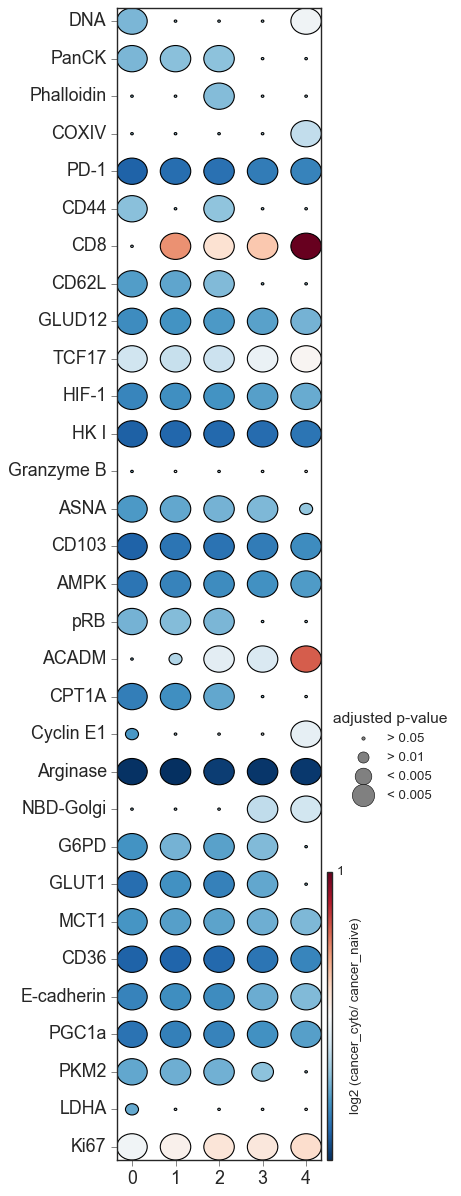

In [149]:
from matplotlib.collections import PatchCollection
import matplotlib
from matplotlib import pyplot as plt, patches

plt.style.use("classic")
plt.style.use("seaborn-white")

xlabels = all_ratio_df.columns.tolist()
ylabels = all_ratio_df.index.tolist()
M = len(xlabels)
N = len(ylabels)

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = all_p_val_df.applymap(size_function).values
c = all_ratio_df.values
print(c)
# norm = mcolors.CenteredNorm(halfrange = 1.5)
norm = mcolors.CenteredNorm(vcenter = 1)
c = norm(c)
print(c)

# Get size and color
# R = s / s.max(axis=1)[:, np.newaxis] / 2.5
R = s

circles = [plt.Circle((j, i), radius=r, ec='none') for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="RdBu_r")

# Plot image
fig, ax = plt.subplots(figsize=(3.3, 18))
ax.add_collection(col)
ax.set(
    xticks=np.arange(M), yticks=np.arange(N), xticklabels=xlabels, yticklabels=ylabels
)
ax.set_xticks(np.arange(M + 1) - 0.2, minor=True)
ax.set_yticks(np.arange(N + 1) - 0.1, minor=True)
ax.set_xticklabels(xlabels,  ha="center")
ax.tick_params(which="major", length=5)
ax.tick_params(top=False, right=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.invert_yaxis()

# Color legend
# cbar = fig.colorbar(col, cax=fig.add_axes([0.92, 0.1, 0.02, 0.2]), ticks=[0, 0.5, 1])
# cbar.ax.set_yticklabels(["0", "0.5", "1.0"])
# cbar.set_label("Expression")

cbar = fig.colorbar(col, cax=fig.add_axes([0.92, 0.1, 0.02, 0.2]), ticks=[0.1, 1, 2])
cbar.ax.set_yticklabels(["0.1", '1', "2"])
cbar.set_label("log2 (cancer_cyto/ cancer_naive)")
# # Size legend
# h = [
#     ax.plot([], [], color="gray", marker="o", ms=i , ls="", label = (i/10 - 0.08) * 2 * s.max() )[0]
#     for i in [3, 10, 15, 20]
# ]
thresholds = [0.05, 0.01, 0.005]

h = [
    ax.plot([], [], color="gray", marker="o", ms=i , ls="", 
            label=("> " + str(threshold)) if threshold != thresholds[-1] else ("< " + str(threshold)))[0]
    for i, threshold in zip([3, 10, 15, 20], thresholds + [thresholds[-1]])
]


leg = ax.legend(
    handles=h, loc="lower left", bbox_to_anchor=(1.0, 0.3, 0.02, 0.4), fontsize="medium"
)
leg.set_title("adjusted p-value", prop={"size": 14})

plt.show()


In [56]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import random
import numpy as np
import pandas as pd
from matplotlib.pyplot import scatter
from matplotlib.pyplot import Line2D
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.rcParams['figure.dpi'] = 600
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import textwrap

In [62]:
# def get_color_df(original_usage):
#     color = pd.DataFrame()
#     for column_name in original_usage.columns:
#         color[column_name] = np.log2(original_usage[column_name] / original_usage.iloc[:, 0])
#     return color.values

In [59]:
def dotplot_v2(df, key1, key2, title):
    #########################################################################################
    def custom_wrap(text, width):
        lines = []
        for line in text.split('\\'):
            lines.extend(textwrap.wrap(line, width=width))
        return '\n'.join(lines)
    #########################################################################################
#     df['Cell Type'] = df['Cell Type'].str.replace('Unknown/low quality myeloid', 'Unknown myeloid')

    color_dict = {0: 'seashell', 3.33: 'lightsalmon', 6.66: 'tomato', 10: 'red'}
#     df = df.replace(0, 1e-5)
    df['ratio'] = df[key1]/df[key2]
#     mask_abs = (df[key1] - df[key2] > 0.01) | (df[key1] - df[key2] < -0.01)
#     mask_ratio = ((df[key1] / df[key2]) > 1.5) | ((df[key1] /df[key2]) < 1/1.5)
#     df = df[mask_abs & mask_ratio]
    all_usage = df['Marker'].unique()

    fig, ax = plt.subplots(figsize=(3, len(all_usage) * 0.1))

#     color_bar_para = get_color_df(df[[key1, key2]])
    color_bar_para = df['p-val']
    y_width = 0.4
    x_width = 0.4
    y_pad = 0.1
    x_pad = 0.2
    scaling_factor = 20.0
    
    y_base = 0

#     color_values = get_color_df(df[[key1, key2]])

#     color_values = df['p-val']
#     norm = mcolors.CenteredNorm(vcenter = 7)
#     colors = norm(color_values)
    
#     print(colors)
#     print(colors)
#     print(color_values.values)
    colors = df['p-val'].values

    all_cell_counts = 0
    for i in all_usage:
        curr_usage = df[df['Marker'] == i]
        cell_type = np.array(curr_usage['Distance'])
        function = np.array(curr_usage['Marker'])

        num_cells = len(curr_usage)
        num_rows = 1
        num_cols = num_cells

        cell_counts = 1

        for column in range(num_cols):
            for inner_row in range(num_rows):
                x_left = (2 * x_width + x_pad) * column
                x_right = x_left + x_width + 0.01
                y = y_base + inner_row * y_width
                #y = y_base + (inner_row + 1) * 0.5 * y_width # y axis for paired dots
                #x = x_width if column == 0 else x_width + column * (x_width + x_pad) # x width is the right most end of two dots
                # ax.scatter(x, y, color=plt.cm.coolwarm(c), marker='o', s= 0.1 + s, edgecolors=plt.cm.coolwarm(c))
                # ax.scatter(x, y, color=plt.cm.coolwarm(c), marker='o', s= 0.1 + s, edgecolors=plt.cm.coolwarm(c))
                if cell_counts <= num_cells:
                    ax.add_patch(Rectangle((x_right, y), x_width, y_width, color = 'steelblue') )
                    ax.add_patch(Rectangle((x_left, y), x_width, y_width, color = 'darkorange') )

                    s1 = scaling_factor * (curr_usage.iloc[cell_counts - 1, :])[key1]
                    s2 = scaling_factor * (curr_usage.iloc[cell_counts - 1, :])[key2]
#                     c1 = plt.cm.coolwarm(colors[all_cell_counts])
#                     c1 = plt.cm.afmhot(colors[all_cell_counts])
#                     c2 = plt.cm.afmhot(colors[all_cell_counts])
                    c1 = color_dict[colors[all_cell_counts]]
                    c2 = color_dict[colors[all_cell_counts]]
#                     c1 = plt.cm.coolwarm(colors[all_cell_counts, 0])
#                     c2 = plt.cm.coolwarm(colors[all_cell_counts, 1])

                    ax.scatter(x_left + 0.5 * x_width, y + 0.5 * y_width, s = s1, color =  c1, edgecolors=c1)
                    ax.scatter(x_right + 0.5 * x_width, y + 0.5 * y_width, s = s2, color = c2, edgecolors=c2)
                    if all_cell_counts < 5:
                        ax.text(x_right, y - 0.4,cell_type[cell_counts - 1], ha = 'center', fontsize = 3, weight = 'bold')
                cell_counts = cell_counts + 1
                all_cell_counts = all_cell_counts + 1
        # func = textwrap.fill(function[0], width=15)
        func = custom_wrap(function[0], 25)
        ax.text(-0.1, y_base + 0.3 * y_width,func, ha = 'right', fontsize = 3, wrap = True, weight = 'bold')
        y_base = y_base + y_width * num_rows 
        # ax.text(-0.1, y_base - 0.3 , i, fontsize = 3)
        y_base = y_base + y_pad
    
#     sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=np.min(color_bar_para), vmax=np.max(color_bar_para)))
#     sm.set_array([])  # Dummy array for the colorbar
    legend_colors = [Patch(facecolor='darkorange', edgecolor='darkorange',label='Cytotoxic T'),
                    Patch(facecolor='steelblue', edgecolor='steelblue',label='Naive T'),
                     Line2D([0], [0], marker='o', color="w", label='> 0.05', markerfacecolor=color_dict[0], markersize=5),
                     Line2D([0], [0], marker='o', color="w", label='> 0.01', markerfacecolor=color_dict[3.33], markersize=5),
                     Line2D([0], [0], marker='o', color="w", label='> 0.005', markerfacecolor=color_dict[6.66], markersize=5),
                    Line2D([0], [0], marker='o', color="w", label='< 0.005', markerfacecolor=color_dict[10], markersize=5)]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    # lg = ax.legend(handles=legend_elements, bbox_to_anchor=(1.6, 1),
    #                      loc='upper left', borderaxespad=0.)
    leg_color = plt.legend(handles=legend_colors, loc='upper left', prop={'size': 4},bbox_to_anchor=(1.05, 1))
    leg_color.get_frame().set_linewidth(0.0)

#     cbar = plt.colorbar(sm, ax=ax, shrink = 0.75, fraction=0.046, pad=0.1)
#     cbar.ax.tick_params(labelsize=3)
#     cbar.outline.set_visible(False)
#     cbar.set_label(label='p-val',size=3)
    plt.title(title, fontsize = 8)
    plt.show()

In [55]:
def size_function(value):
    if value > 0.05:
        return 0
    elif value > 0.01:
        return 3.33
    elif value > 0.005:
        return 6.66
    else:
        return 10
# df = df.applymap(size_function)


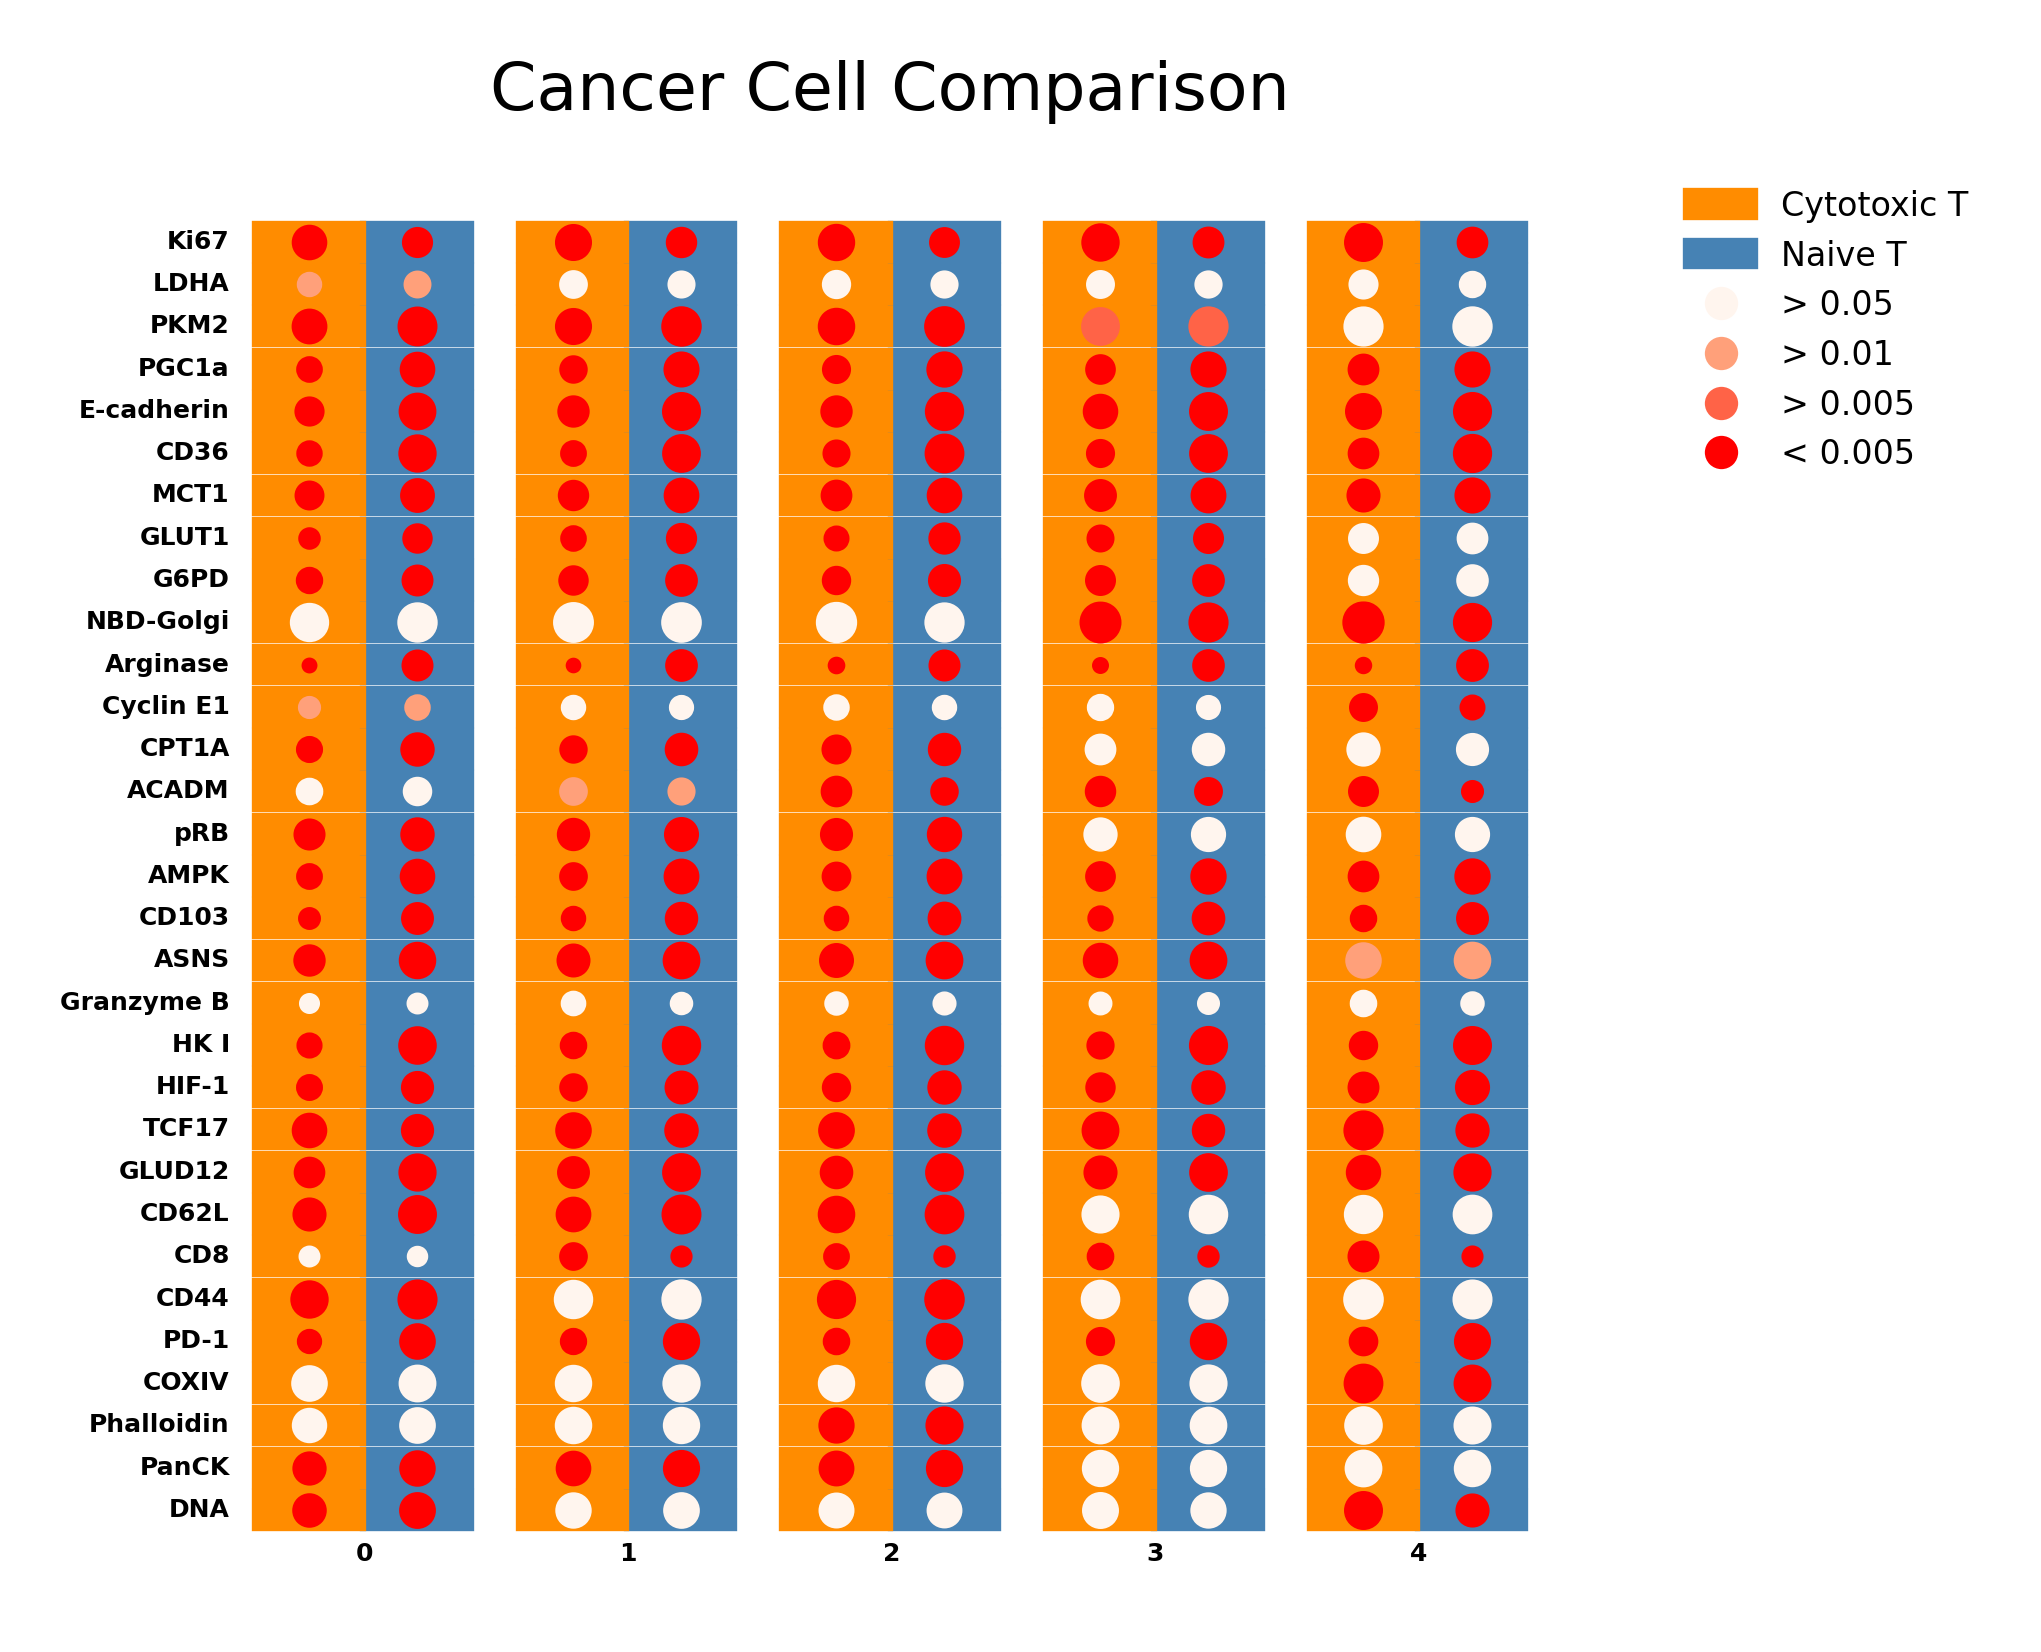

In [85]:
all_df['p-val'] = pd.DataFrame(all_df['p-val']).applymap(size_function)
all_df['Marker'] = all_df['Marker'].replace('ASNA', 'ASNS')
dotplot_v2(all_df, 'Cytotoxic Median', 'Naive Median', 'Cancer Cell Comparison')

In [53]:
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# all_ratio_df = pd.DataFrame(columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','marker'])
# all_p_val_df = pd.DataFrame(columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','marker'])
all_df = pd.DataFrame(columns = ['Marker', 'Distance', 'Cytotoxic Median', 'Naive Median', 'p-val'])
for i in df_all_T_corrected:
    
    if (i == 'Cell_type_name') | (i == 'Distance cancer-cell') | (i == 'Distance to cancer-cell') | (i == 'Distance cancer-cell bucket'):
        continue
#     print(i)
    df = df_all_T_corrected[[i, 'Cell_type_name',"Distance cancer-cell bucket"]]
    groups = df.groupby(['Distance cancer-cell bucket'])

    df_temp = pd.DataFrame(columns = ['Marker', 'Distance', 'Cytotoxic Median', 'Naive Median'])
    p_values = []
    for (distance), data in groups:
        cytotoxic_data = data[data['Cell_type_name'] == 'Cytotoxic T cell'][i]
        naive_data = data[data['Cell_type_name'] == 'Naive T cell'][i]
        stat, p_value = mannwhitneyu(cytotoxic_data, naive_data)
        df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ignore_index = True)
        p_values.append(p_value)
#         all_df = df_temp.append(new_row, ignore_index=True)
    reject, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')
    df_temp['p-val'] = corrected_p_values
    all_df = all_df.append(df_temp)
#         medians_cytotoxic.append(cytotoxic_data.median() + 0.01)
#         medians_naive.append(naive_data.median() + 0.01)
#         ratio.append((cytotoxic_data.median() + 0.01)/(naive_data.median() + 0.01))
#         p_values.append(p_value)
#         distances.append(distance)
#     reject, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni')
#     ratio.append(i)
#     corrected_p_values = corrected_p_values.tolist()
#     corrected_p_values.append(i)
    
#     all_ratio_df = all_ratio_df.append(pd.Series(ratio, index=all_ratio_df.columns), ignore_index=True)
#     all_p_val_df = all_p_val_df.append(pd.Series(corrected_p_values, index=all_ratio_df.columns), ignore_index=True)

C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1207339436.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (distance), data in groups:
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1207339436.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ignore_index = True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1207339436.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ign

C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1207339436.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ignore_index = True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1207339436.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ignore_index = True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1207339436.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], inde

C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1207339436.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ignore_index = True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1207339436.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series([i, distance, cytotoxic_data.median(), naive_data.median()], index=df_temp.columns), ignore_index = True)
C:\Users\mwang698\AppData\Local\Temp\ipykernel_47272\1207339436.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(df_temp)


In [56]:
all_df['p-val'] = pd.DataFrame(all_df['p-val']).applymap(size_function)

In [61]:
all_df['Marker'] = all_df['Marker'].replace('ASNA', 'ASNS')

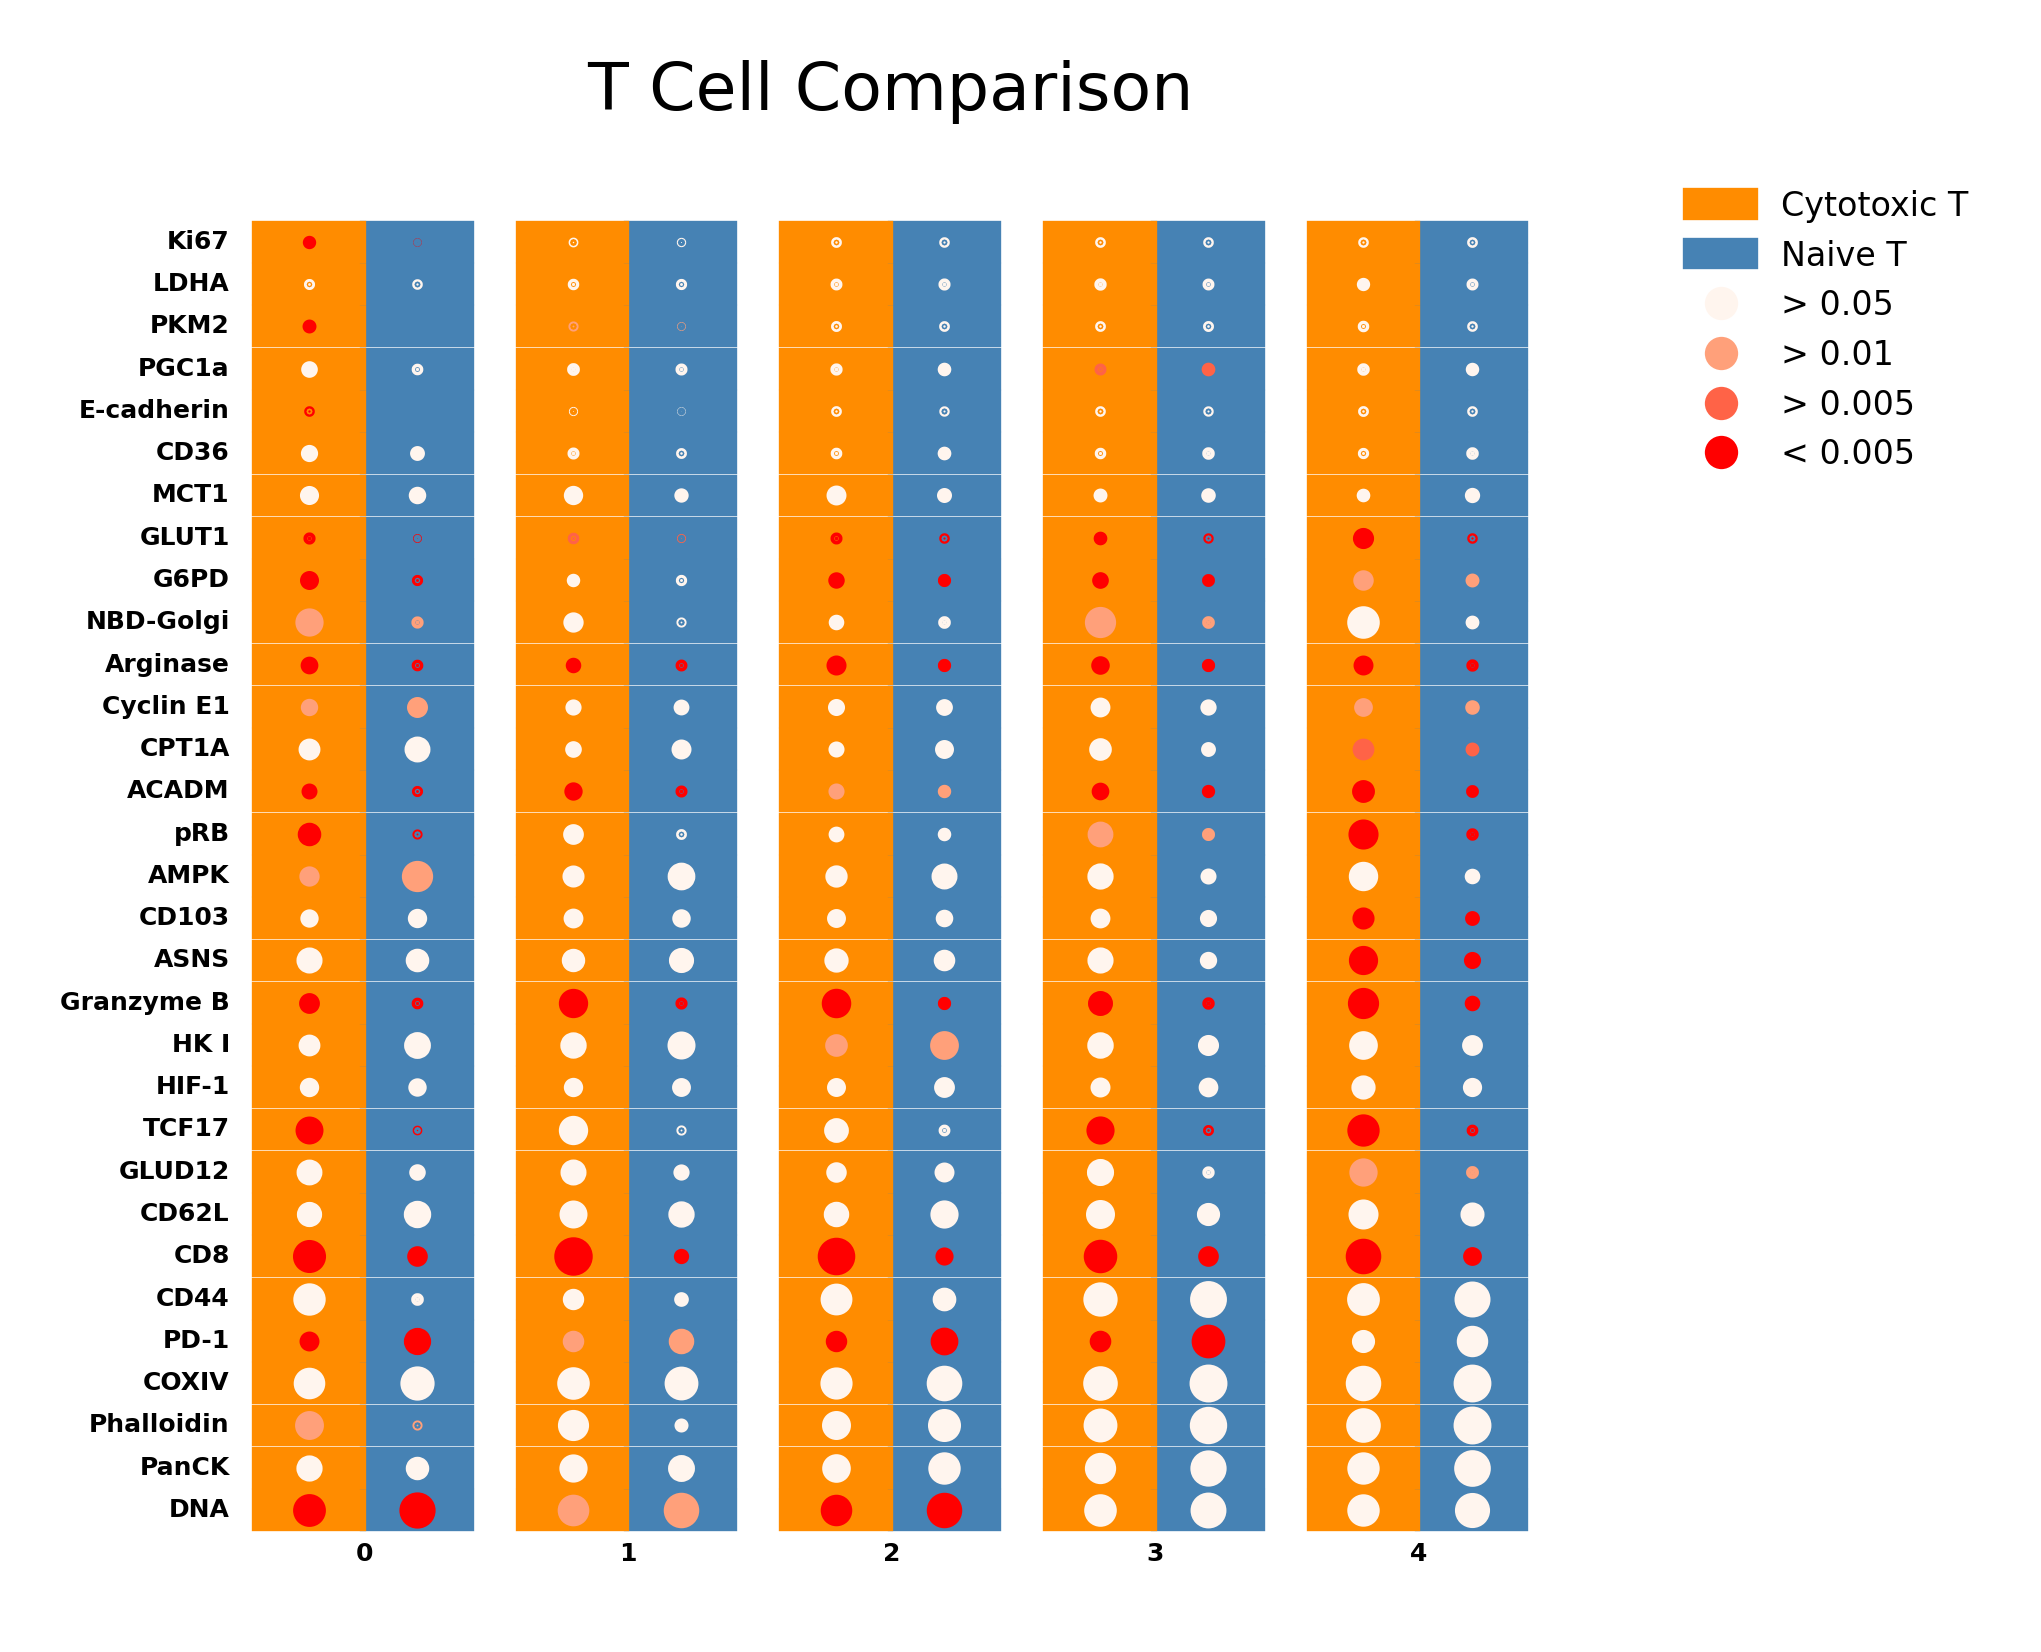

In [62]:
dotplot_v2(all_df, 'Cytotoxic Median', 'Naive Median', 'T Cell Comparison')

In [129]:
# all_p_val_df.index = all_p_val_df['marker']
# all_p_val_df = all_p_val_df.drop(['marker'], axis = 1)
# all_ratio_df.index = all_ratio_df['marker']
# all_ratio_df = all_ratio_df.drop(['marker'], axis = 1)

# all_ratio_df = all_ratio_df.applymap(lambda x: np.log2(x))